We want to study the tapering method on the Hamiltonian of the anti-ferromagnetic Heinsenberg model for a "bow-tie" lattice with zero field. The hamiltonian is given by:

$$ H=\sum_{\langle i,j \rangle} \{X_i X_j+Y_iY_j+Z_iZ_j\}$$

where $\{X_i,Y_i,Z_i\}$ are the Pauli matrices acting on site $i$ and $\langle i,j\rangle$ refers to the sum on the nearest neighbours of each site, namely the sum on the couples $\{(0,1),(0,2),(1,2),(2,3),(2,4),(3,4)\}$.

For the moment we use the $\textbf{WeightedPauliOperator}$ class instead of using the $\textbf{SummedOp}$ class.

In [17]:
import numpy  as np
from   qiskit                 import *
from   qiskit.quantum_info    import Pauli
from   qiskit.aqua.operators  import WeightedPauliOperator
from   qiskit.aqua.algorithms import NumPyEigensolver, NumPyMinimumEigensolver
import matplotlib.pyplot      as plt
def generate_pauli(idx_x,idx_z,n):
    '''
    Args:
       n   (integer)
       idx (List)
    Returns:
       tensor product of X operators acting on qubits in idx
       Y = (-i) XZ
       P0 P1 P2 P3 P4
       Pi = (X)^a (Z)^b
    '''
    xmask = [0]*n
    zmask = [0]*n
    for i in idx_x: xmask[i] = 1
    for i in idx_z: zmask[i] = 1
    a_x = np.asarray(xmask,dtype=np.bool)
    a_z = np.asarray(zmask,dtype=np.bool)
    return Pauli(a_z,a_x)

def generate_Heisenberg(nqubit,nn_list):
    pauli_list = []
    for (i,j) in nn_list:
        xixj = generate_pauli([i,j],[],nqubit);    pauli_list.append((1.0,xixj))
        yiyj = generate_pauli([i,j],[i,j],nqubit); pauli_list.append((1.0,yiyj))
        zizj = generate_pauli([],[i,j],nqubit);    pauli_list.append((1.0,zizj))
    H = WeightedPauliOperator(pauli_list)
    return H

def generate_spin_operators(nqubit):
    spins = []
    for i in range(nqubit):
        xi = generate_pauli([i],[],nqubit);  spins.append( (str(i)+'x',WeightedPauliOperator([(1.0,xi)])) )
        yi = generate_pauli([i],[i],nqubit); spins.append( (str(i)+'y',WeightedPauliOperator([(1.0,yi)])) )
        zi = generate_pauli([],[i],nqubit);  spins.append( (str(i)+'z',WeightedPauliOperator([(1.0,zi)])) )
    return spins

def diagonalize_H(H,aux_operators):
    '''
    k = numero di autovalori/autovettori da calcolare
    H |ci) = Ei |ci)
    Ai = (ci|A|ci)
    aux_ops: list of length k; each element is an array of shape (nprops,2) for real, imaginary part
    '''
    ee = NumPyEigensolver(operator=H,k=2**H.num_qubits,aux_operators=[s for name_s,s in aux_operators])
    ee = ee.run()
    energies = np.real(ee['eigenvalues'])
    psi      = ee['eigenstates']
    aux_ops  = ee['aux_operator_eigenvalues']

    '''
    for i,(ei,ai) in enumerate(zip(energies,aux_ops)):
        print("eigenstate, energy ",i,round(ei,6))
        for js,(name_s,s) in enumerate(aux_operators):
            print("    spin ",name_s,round(ai[js][0],6))
        print("eigenvector")
        psi_i = psi[i].primitive.to_dict()
        for k in psi_i.keys():
            print("     ",k,psi_i[k])
    '''
    return energies,psi,aux_ops

# Tapering

In [2]:
from qiskit                                        import *
from qiskit.aqua.operators                         import Z2Symmetries
from qiskit.aqua.algorithms                        import ExactEigensolver
from qiskit.aqua.algorithms                        import NumPyEigensolver
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.aqua                                   import aqua_globals
from qiskit.tools                                  import parallel_map
from prettytable                                   import PrettyTable
from qiskit.aqua.operators                         import WeightedPauliOperator,commutator
from itertools                                     import permutations,product
from qiskit.aqua.operators.legacy                  import op_converter

def taper(qubit_op,A_op,outf,sector=0):

    z2_symmetries  = Z2Symmetries.find_Z2_symmetries(qubit_op) # <---- search of symmetry operators
    the_ancillas   = A_op
    nsym           = len(z2_symmetries.sq_paulis)
    the_tapered_op = qubit_op
    sqlist         = Z2Symmetries([],[],[],[])
    z2syms         = Z2Symmetries([],[],[],[])

    outf.write('\n\n Start tapering... \n\n')
    print('\n\n Start tapering... \n\n')
    
    outf.write('Number of detected symmetries : %d\n' % nsym)
    print('Number of detected symmetries : %d\n' % nsym)

    if(nsym>0):
        outf.write('Z2 symmetries found:\n')
        print('Z2 symmetries found:\n')
        for symm in z2_symmetries.symmetries:
            outf.write(symm.to_label()+'\n')
            print(symm.to_label()+'\n')
        outf.write('Single qubit operators found:\n')
        print('Single qubit operators found:\n')
        for sq in z2_symmetries.sq_paulis:
            outf.write(sq.to_label()+'\n')
            print(sq.to_label()+'\n')
        outf.write('Cliffords found:\n')
        print('Cliffords found:\n')
        for clifford in z2_symmetries.cliffords:
            outf.write(clifford.print_details()+'\n')
            print(clifford.print_details()+'\n')
        outf.write('Single-qubit list: {}\n'.format(z2_symmetries.sq_list))
        print('Single-qubit list: {}\n'.format(z2_symmetries.sq_list))

        # But are the symmetries effectively symmetries?
        for s in z2_symmetries.symmetries:
            Ps = WeightedPauliOperator(paulis=[[1.0,s]])
            cmm_s = commutator(qubit_op,Ps).chop(1e-6)
            outf.write("Does the symmetry "+str(s)+" commute with H? "+str(cmm_s.is_empty())+"\n")
            print("Does the symmetry "+str(s)+" commute with H? "+str(cmm_s.is_empty())+"\n")

        for s in z2_symmetries.symmetries:
            Ps = WeightedPauliOperator(paulis=[[1.0,s]])
            for t in z2_symmetries.symmetries:
                Pt = WeightedPauliOperator(paulis=[[1.0,t]])
                cmm_st = commutator(Pt,Ps).chop(1e-6)
                outf.write("Do the symmetries "+str(s)+" and "+str(t)+" commute? "+str(cmm_st.is_empty())+"\n")
                print("Do the symmetries "+str(s)+" and "+str(t)+" commute? "+str(cmm_st.is_empty())+"\n")
       
        # Removal of qubit associated with the symmetries
        print("Reduction of UHU*")
        tapered_ops = z2_symmetries.taper(qubit_op) # <---- reduction of Ham. UHU* + projection on "sectors"
        for tapered_op in tapered_ops:
            #print(tapered_op.print_details())
            outf.write("Number of qubits of tapered qubit operator: {}\n".format(tapered_op.num_qubits))
            print("Number of qubits of tapered qubit operator: {}\n".format(tapered_op.num_qubits))

        ee = NumPyEigensolver(qubit_op,k=2**qubit_op.num_qubits)
        ee = ee.run()
        energies = np.real(ee['eigenvalues'])

        outf.write('Full H diagonalization \n')
        print('Full H diagonalization \n')
        for e in energies:
            outf.write('%f\n' % e)
            print('%f\n' % e)

        # Spectrum exam of H in each "sector" = eigenspace of the symmetry operator
        energies = []

        for idx in range(len(tapered_ops)):
            ee = NumPyEigensolver(tapered_ops[idx],k=2**tapered_ops[idx].num_qubits)
            ee = ee.run()
            energies.append(np.real(ee['eigenvalues']))

        t = PrettyTable(['eigenvalue']+['sector '+str(i) for i in range(len(energies))])
        for i in range(2**tapered_ops[0].num_qubits):
            ei = [es[i] for es in energies]
            t.add_row([str(i)]+[str(round(x,6)) for x in ei])
        outf.write(str(t))
        print(str(t))
        outf.write("\n")
        print("\n")

        # Choice of a specific sector (e.g. sector 0 or 1 or 2 or 3)
        smallest_idx = sector
 
        # Tapering on the Hamiltonian
        the_tapered_op = tapered_ops[smallest_idx]
        the_coeff      = tapered_ops[smallest_idx].z2_symmetries.tapering_values
        sqlist = the_tapered_op.z2_symmetries.sq_list
        z2syms = the_tapered_op.z2_symmetries

        # Tapering on the 'properties' (e.g. single spin)
        the_ancillas = []
        for name_A,A in A_op:
            cmm = True
            for s in z2_symmetries.symmetries:
                Ps = WeightedPauliOperator(paulis=[[1.0,s]])
                cmm_s = commutator(A,Ps).chop(1e-6)
                if(not cmm_s.is_empty()): cmm=False
            if(not cmm):
                the_ancillas.append(WeightedPauliOperator(paulis=[[0.0,z2_symmetries.symmetries[0]]]))
            else:
                A_taper = z2_symmetries.taper(A)
                if(type(A_taper)==list): the_ancillas.append(A_taper[smallest_idx])
                else: the_ancillas.append((name_A,A_taper))
    outf.write('\n\n...finish tapering \n\n')
    print('\n\n...finish tapering \n\n')
   
    return the_tapered_op,the_ancillas,z2syms,sqlist 

In [3]:
nqubit  = 5
nn_list = [(0,1),(1,2),(0,2),(2,3),(2,4),(3,4)]

H = generate_Heisenberg(nqubit,nn_list)
print("Hamiltonian operators:")
print(H.print_details())

Hamiltonian operators:
IIIXX	(1+0j)
IIIYY	(1+0j)
IIIZZ	(1+0j)
IIXXI	(1+0j)
IIYYI	(1+0j)
IIZZI	(1+0j)
IIXIX	(1+0j)
IIYIY	(1+0j)
IIZIZ	(1+0j)
IXXII	(1+0j)
IYYII	(1+0j)
IZZII	(1+0j)
XIXII	(1+0j)
YIYII	(1+0j)
ZIZII	(1+0j)
XXIII	(1+0j)
YYIII	(1+0j)
ZZIII	(1+0j)



In [4]:
spins = generate_spin_operators(nqubit)
print("Spin Operators:")
for name_s,s in spins:
    print(name_s+' '+s.print_details()) 

Spin Operators:
0x IIIIX	(1+0j)

0y IIIIY	(1+0j)

0z IIIIZ	(1+0j)

1x IIIXI	(1+0j)

1y IIIYI	(1+0j)

1z IIIZI	(1+0j)

2x IIXII	(1+0j)

2y IIYII	(1+0j)

2z IIZII	(1+0j)

3x IXIII	(1+0j)

3y IYIII	(1+0j)

3z IZIII	(1+0j)

4x XIIII	(1+0j)

4y YIIII	(1+0j)

4z ZIIII	(1+0j)



Now we show the permutation unitaries and the Pauli operators that commute with the given Hamiltonian. 

In [40]:
outf = open("tapering_H.out","w")

mat_H = op_converter.to_matrix_operator(H)._matrix.todense()

# for every permutation of [0,1,2,3,4]
# represent the permutation in terms of swap gates
# determine if the corresponding unitary
# and determine which permutation unitaries commute with H

print("Permutation unitaries commuting with H")
get_bin = lambda x,n: [int(x) for x in format(x,'b').zfill(n)]
for sigma in permutations([i for i in range(nqubit)]):
    U_sigma = np.zeros(mat_H.shape)    
    for i in range(2**nqubit):
        xi = get_bin(i,5)
        sigma_xi = [xi[sigma[m]] for m in range(nqubit)]
        sigma_i  = int(''.join([str(x) for x in sigma_xi]),2)
        U_sigma[sigma_i,i] = 1.0
    comm_sigma = np.dot(U_sigma,mat_H)-np.dot(mat_H,U_sigma)
    comm_sigma = np.abs(comm_sigma).max()
    if(np.abs(comm_sigma)<1e-3): print("sigma ",sigma,"|[U,H]| = ",comm_sigma)

print("\nPauli operators commuting with H")
for mu in product([0,1,2,3],repeat=nqubit):
    idx_x = []
    idx_z = []
    for i in range(nqubit):
        if(mu[i]==1 or mu[i]==2): idx_x.append(i)
        if(mu[i]==2 or mu[i]==3): idx_z.append(i)
    sigma_mu = generate_pauli(idx_x,idx_z,nqubit)
    sigma_mu = WeightedPauliOperator([(1.0,sigma_mu)])
    c_mu = commutator(H,sigma_mu).chop(1e-6)
    if(c_mu.is_empty()):
        print(str(sigma_mu.print_details()))

Permutation unitaries commuting with H
sigma  (0, 1, 2, 3, 4) |[U,H]| =  0.0
sigma  (0, 1, 2, 4, 3) |[U,H]| =  0.0
sigma  (1, 0, 2, 3, 4) |[U,H]| =  0.0
sigma  (1, 0, 2, 4, 3) |[U,H]| =  0.0
sigma  (3, 4, 2, 0, 1) |[U,H]| =  0.0
sigma  (3, 4, 2, 1, 0) |[U,H]| =  0.0
sigma  (4, 3, 2, 0, 1) |[U,H]| =  0.0
sigma  (4, 3, 2, 1, 0) |[U,H]| =  0.0

Pauli operators commuting with H
IIIII	(1+0j)

XXXXX	(1+0j)

YYYYY	(1+0j)

ZZZZZ	(1+0j)



In [41]:
tap_H,tap_spins,z2syms,sqlist = taper(H,spins,outf,sector=0)



 Start tapering... 


Number of detected symmetries : 2

Z2 symmetries found:

ZZZZZ

XXXXX

Single qubit operators found:

IIIIX

IIIIZ

Cliffords found:

ZZZZZ	(0.7071067811865475+0j)
IIIIX	(0.7071067811865475+0j)


XXXXX	(0.7071067811865475+0j)
IIIIZ	(0.7071067811865475+0j)


Single-qubit list: [0, 0]

Does the symmetry ZZZZZ commute with H? True

Does the symmetry XXXXX commute with H? True

Do the symmetries ZZZZZ and ZZZZZ commute? True

Do the symmetries ZZZZZ and XXXXX commute? False

Do the symmetries XXXXX and ZZZZZ commute? False

Do the symmetries XXXXX and XXXXX commute? True

Reduction of UHU*
Number of qubits of tapered qubit operator: 4

Number of qubits of tapered qubit operator: 4

Number of qubits of tapered qubit operator: 4

Number of qubits of tapered qubit operator: 4

Full H diagonalization 

-6.000000

-6.000000

-6.000000

-6.000000

-6.000000

-6.000000

-4.000000

-4.000000

-4.000000

-4.000000

-2.000000

-2.000000

-0.000000

-0.000000

-0.000000

-0.00

In [42]:
print("The tapered hamiltonian of sector 0:")
print(tap_H.print_details())

The tapered hamiltonian of sector 0:
XXXI	(0.9999999999999997+0j)
YYYI	(-0.9999999999999997+0j)
ZZZI	(-0.9999999999999997+0j)
IIXX	(0.9999999999999997+0j)
IIYY	(0.9999999999999997+0j)
IIZZ	(0.9999999999999997+0j)
XXIX	(0.9999999999999997+0j)
YYIY	(-0.9999999999999997+0j)
ZZIZ	(-0.9999999999999997+0j)
IXXI	(0.9999999999999997+0j)
IYYI	(0.9999999999999997+0j)
IZZI	(0.9999999999999997+0j)
XIXI	(0.9999999999999997+0j)
YIYI	(0.9999999999999997+0j)
ZIZI	(0.9999999999999997+0j)
XXII	(0.9999999999999997+0j)
YYII	(0.9999999999999997+0j)
ZZII	(0.9999999999999997+0j)



As we can see the tapering makes us turn into a system of $4$ qubits where we have also $3$-local terms in the tapered Hamiltonian. However a problem arises: with $4$ qubits we lose the geometry of our "bow-tie" lattice. This could suggest that tapering is not a good idea for our job.

# Optimization of $E=\frac{\langle \psi|\Pi H \Pi|\psi \rangle}{\langle \psi|\Pi|\psi \rangle}$

By using the VQE algorithm we want to optimize the expectation value given by:

$$E=\frac{\langle \psi_T|\Pi H \Pi|\psi_T \rangle}{\langle \psi_T|\Pi|\psi_T \rangle}$$

where $\Pi$ is the projector on the eigenspace of a symmetry operator, $\psi_T$ is a trial state of our problem and $H$ is the Heisenberg Hamiltonian.

In particular we are interested into the symmetry operators corresponding to the horizontal and vertical reflection on our "bow-tie" lattice. They are given by

$$R_h=S_{01}S_{34} \quad\quad R_v=S_{03}S_{14}$$

to which we can associate the corresponding projection operators

$$\Pi_{a,b}=\frac{1+(-1)^a R_v}{2}\frac{1+(-1)^b R_h}{2} = \frac{1}{4}\big\{ \underbrace{\mathbb{1}}_{\Pi_{a,b}^{(0)}} + \underbrace{(-1)^a R_v}_{\Pi_{a,b}^{(1)}} + \underbrace{(-1)^b R_h}_{\Pi_{a,b}^{(2)}} + \underbrace{(-1)^{a+b}R_v R_h}_{\Pi_{a,b}^{(3)}} \big\}$$

where $(-1)^a,(-1)^b$ $(a,b=0,1)$, refer to the eigenvalues of $R_v$ and $R_h$ ($\pm1$). We have given the decomposition of $\Pi_{a,b}$ in $4$ terms because we need to run the VQE on each of them to get the final result. Now we can rewrite the expression of the expected energy:

$$E(a,b)=\frac{\langle \psi_T| \big(\sum_{i=0}^3 \Pi_{a,b}^{(i)}\big) H \big(\sum_{j=0}^3 \Pi_{a,b}^{(j)}\big)|\psi_T \rangle}{\langle \psi_T|\big(\sum_{i=0}^3 \Pi_{a,b}^{(i)}\big)\big(\sum_{j=0}^3 \Pi_{a,b}^{(j)}\big)|\psi_T \rangle} $$

In the following we will evaluate $\Pi_{a,b}^{(i)}$ for $i=0,1,2,3$.

In [43]:
from qiskit.circuit.library                   import RYGate,U3Gate,TwoLocal,RealAmplitudes, WeightedAdder
from qiskit.aqua.components.optimizers        import L_BFGS_B,COBYLA,CG,ADAM,SPSA,AQGD
from qiskit.aqua.components.initial_states    import *
from qiskit.aqua.algorithms                   import VQE
from qiskit.aqua                              import QuantumInstance,aqua_globals
from qiskit.aqua.operators                    import SummedOp,PauliOp, CircuitOp

#import logging
#from qiskit.aqua import set_qiskit_aqua_logging
#set_qiskit_aqua_logging(logging.DEBUG) 

import math
import matplotlib 
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [44]:
# Algorithm execution

# 1. On classical computer WITHOUT statistical uncertainties, namely (Psi|H|Psi) algebraically evaluated
backend_1          = Aer.get_backend('statevector_simulator') # <----
quantum_instance_1 = QuantumInstance(backend=backend_1)

# 2. On classical computer WITH statistical uncertainties and hopefully decoherence model
backend_2          = Aer.get_backend('qasm_simulator') # <---- (Psi|H|Psi) sampled
quantum_instance_2 = QuantumInstance(backend=backend_2,shots=8000)

# 3. On quantum computer 
# ...

Definition of the **SO4 variational form**.

In [45]:
from  typing import List, Optional, Union
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit import ParameterVector, Parameter
from qiskit.aqua.components.variational_forms import VariationalForm
from qiskit.aqua.components.initial_states import InitialState

class so4(VariationalForm): # definition of the variational ansatz
    def __init__(self, num_qubits: Optional[int] = None, reps: int = 1,
                 connections: Union[str, List[int]] = 'full',
                 initial_state: Optional[InitialState] = None) -> None:
        super().__init__()
        self._num_qubits = num_qubits
        self._reps = reps
        self._initial_state = initial_state
        self._connections = connections
        self._num_parameters = len(connections)*reps*6
        self._bounds = [(-np.pi,np.pi)]*self._num_parameters

    @property
    def num_qubits(self) -> int:
        return self._num_qubits

    @num_qubits.setter
    def num_qubits(self, num_qubits: int) -> None:
        self._num_qubits = num_qubits

    def append_so4(self,circuit,qubit1,qubit2,parameters):
        circuit.s(qubit1)
        circuit.s(qubit2)
        circuit.h(qubit2)
        circuit.cx(qubit2,qubit1)
        circuit.u(parameters[0],parameters[1],parameters[2],qubit1)
        circuit.u(parameters[3],parameters[4],parameters[5],qubit2)
        circuit.cx(qubit2,qubit1)
        circuit.h(qubit2)
        circuit.sdg(qubit1)
        circuit.sdg(qubit2)

    # Given the parameters (theta), we build a circuit which returns Psi(theta)

    def construct_circuit(self, parameters: Union[np.ndarray, List[Parameter], ParameterVector],
                          q: Optional[QuantumRegister] = None) -> QuantumCircuit:
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))

        if self._num_qubits is None:
            raise ValueError('The number of qubits is None and must be set before the circuit '
                             'can be created.')

        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)

        m = 0
        for l in range(self._reps):
            for [i,j] in self._connections:
                self.append_so4(circuit,i,j,parameters[6*m:6*(m+1)])
                m += 1
        return circuit

**The idea** 
To use the VQE algorithm we convert the operator $H$ and $\Pi_{a,b}^{(i)}$ into matrices and we calculate the matrix product in $\big(\sum_{i=0}^3 \Pi_{a,b}^{(i)}\big) H \big(\sum_{j=0}^3 \Pi_{a,b}^{(j)}\big)$ and $\big(\sum_{i=0}^3 \Pi_{a,b}^{(i)}\big) \big(\sum_{j=0}^3 \Pi_{a,b}^{(j)}\big)$. At the end we transform the two resulting matrices into the operators to be used as arguments of VQE function.

## Optimization of $E(a=0,b=0)$ 

### Building the matrices

Here we show the matrix representation of the Hamiltonian $H$.

In [6]:
import sys
np.set_printoptions()

#print(H.print_details())
from qiskit.aqua.operators import op_converter
mat_H = op_converter.to_matrix_operator(H).dense_matrix
print(mat_H)

[[6.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 2.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 2.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 2.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 2.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 6.+0.j]]


Now we want to create the matrices associated with the following operators: 

$$\Pi_{a,b}^{(0)}=\mathbb{1}, \quad \Pi_{a,b}^{(1)}=(-1)^a R_v = (-1)^a S_{03}S_{14}, \quad \Pi_{a,b}^{(2)}=(-1)^b R_h = (-1)^b S_{01}S_{34}, \quad \Pi_{a,b}^{(3)}=(-1)^{a+b}R_v R_h = (-1)^{a+b} S_{03}S_{14}S_{01}S_{34}$$

In this regard we build the quantum circuit associated with each of the latter operators, then we create the corresponding matrix.

In [7]:
from qiskit import BasicAer
from qiskit.aqua.operators.legacy import MatrixOperator

backend = BasicAer.get_backend('unitary_simulator')

#Here we set the eigenvalues of our symmetry operators, (-1)^a for R_v and (-1)^b for R_h
a=0
b=0

#circuit_list=[]
#Pi_list=[]

mat_P=np.zeros((2**H.num_qubits,2**H.num_qubits),dtype='complex128')
Id=np.identity(2**H.num_qubits)

for i in range(4):
    c_T = QuantumCircuit(QuantumRegister(H.num_qubits,'q') )
    if i==0:
        #Creation of the matrix associated with the corresponding circuit
        job = execute(c_T, backend)
        M=job.result().get_unitary(c_T, decimals=3)
        mat_P=np.add(mat_P,M)
    if i==1:
        c_T.swap(1,4)
        c_T.swap(0,3)
        #Creation of the matrix associated with the corresponding circuit
        job = execute(c_T, backend)
        M=job.result().get_unitary(c_T, decimals=3)
        mat_P=np.add(mat_P,np.dot((-1)**a,M))
    if i==2:
        c_T.swap(3,4)
        c_T.swap(0,1)
        #Creation of the matrix associated with the corresponding circuit
        job = execute(c_T, backend)
        M=job.result().get_unitary(c_T, decimals=3)
        mat_P=np.add(mat_P,np.dot((-1)**b,M))
    if i==3:
        c_T.swap(3,4)
        c_T.swap(0,1)
        c_T.swap(1,4)
        c_T.swap(0,3)
        #Creation of the matrix associated with the corresponding circuit
        job = execute(c_T, backend)
        M=job.result().get_unitary(c_T, decimals=3)
        mat_P=np.add(mat_P,np.dot((-1)**(a+b),M))
    
    #Definition of symmetry operator R_v and R_h
    if i==1:
        Rv=M
    if i==2:
        Rh=M
        
    print("Matrix associated with operator i =",i)
    print(M)
    
    print("Circuit associated with operator i =",i)
    print(c_T.draw())
    #Transformation of the matrix into an operator
    #If we add .to_pauli_op() at the end we can obtain the SummedOp of PauliOp associated with the circuit
    #Pi_list.append(MatrixOperator(M).to_opflow())
    
    #By this way we can create a SummedOp of operators described directly by the circuits
    #circuit_list.append(CircuitOp(c_T))
    
print("Projection matrix (sum of all matrices above)")
print(mat_P)
#P=SummedOp(circuit_list)
#print(P)

Matrix associated with operator i = 0
[[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 1.+0.j]]
Circuit associated with operator i = 0
     
q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     
q_4: 
     
Matrix associated with operator i = 1
[[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 1.+0.j]]
Circuit associated with operator i = 1
           
q_0: ────X─
         │ 
q_1: ─X──┼─
      │  │ 
q_2: ─┼──┼─
      │  │ 
q_3: ─┼──X─
      │    
q_4: ─X────
           
Matrix associated with operator i = 2
[[1.+0.j 0

### Properties

#### $[R_v,R_h]=0$

Using $a=0$ and $b=0$ we can verify that $[R_v,R_h]=[\Pi_{0,0}^{(1)},\Pi_{0,0}^{(2)}]=0$ using their matrix representation.

In [8]:
comm=np.dot(Rv,Rh)-np.dot(Rh,Rv)
if np.all(comm==0):
    print(comm)
    print("They commute!")

[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
They commute!


#### $[R_v,H]=0=[R_h,H]$

In [49]:
comm=np.dot(Rv,mat_H)-np.dot(mat_H,Rv)
if np.all(comm==0):
    print("R_v and H commute!")
    
comm=np.dot(Rh,mat_H)-np.dot(mat_H,Rh)
if np.all(comm==0):
    print("R_h and H commute!")

R_v and H commute!
R_h and H commute!


#### $\Pi_{0,0}=\Pi_{0,0}^{\dagger}$

In [50]:
P=np.dot(1/4,mat_P)
if np.all(P==np.conjugate(np.transpose(P))):
    print("P is equal to its adjoint!")

P is equal to its adjoint!


#### Idempotence:  $\Pi_{0,0}^2=\Pi_{0,0}$

In [51]:
if np.all(P==np.dot(P,P)):
    print("They are the same!")

They are the same!


#### Eigenvalues of the symmetry operator, $\Pi_{0,0}$

In [52]:
P=MatrixOperator(np.dot(1/4,mat_P)).to_opflow().to_pauli_op()
P_result = NumPyEigensolver(operator=P,k=2**H.num_qubits).run()

As expected we will obtain a list of $0$ and $1$ as eigenvalues.

In [53]:
for en in P_result['eigenvalues']:
    print(np.round(abs(en),15),end=' ')

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 

Therefore the eigenspace of $\Pi_{0,0}$ corresponding to eigenvalue $1$ is of dimension $14$.

In [54]:
#We remind that P_result[1] gives the eigenvectors
P_eigv=[]
for i in range(len(P_result['eigenvalues'])):
    if np.round(abs(P_result['eigenvalues'][i]),15)==1.:
        print("Energy: ",np.round(abs(P_result['eigenvalues'][i]),15))
        psi_i = P_result['eigenstates'][i].primitive.to_dict()
        for k in psi_i.keys():
            print("     ",k,psi_i[k])
        #By the following way we print the eigenvector corresponding to the eigenstate
        P_eigv.append(P_result['eigenstates'][i].primitive.data)

Energy:  1.0
      00001 (-3.7507507815384455e-17-1.6948183510607676e-32j)
      00010 (1.5182347178444477e-18+1.1303509524404533e-34j)
      00011 (-7.092086737044762e-18-4.678879303017423e-34j)
      00101 (8.872709451184207e-17+2.69630192214213e-33j)
      00110 (-2.52922722081965e-17-6.162975822039155e-33j)
      01000 (-1.432428963497165e-17+2.157041537713704e-32j)
      01001 (0.7071067811865476+0j)
      01010 (-6.469590510913666e-17+4.5341114667723485e-50j)
      01011 (1.7431364886491204e-16-4.084439139629752e-49j)
      01100 (-1.0273616996459578e-16-3.0814879110195774e-33j)
      01101 (-2.3731370464550164e-33-1.5159553700949577e-66j)
      01110 (-1.4059028884009965e-33+4.288504088177788e-66j)
      01111 (-1.9775608430237158e-17+7.703719777548943e-34j)
      10000 (6.159067203181987e-17+3.274080905458301e-33j)
      10001 (-2.351161021368069e-16+1.1754747786307715e-48j)
      10010 (0.7071067811865474-2.69630192214213e-33j)
      10011 (-2.886897136527127e-17+6.06969834798

In [55]:
print("Eigenspace dimension: ",len(P_eigv))
print("Eigenvectors with eigenvalue 1: ")
for el in P_eigv:
    print(el)

Eigenspace dimension:  14
Eigenvectors with eigenvalue 1: 
[-0.00000000e+00+0.00000000e+00j -3.75075078e-17-1.69481835e-32j
  1.51823472e-18+1.13035095e-34j -7.09208674e-18-4.67887930e-34j
 -0.00000000e+00+0.00000000e+00j  8.87270945e-17+2.69630192e-33j
 -2.52922722e-17-6.16297582e-33j -0.00000000e+00+0.00000000e+00j
 -1.43242896e-17+2.15704154e-32j  7.07106781e-01+0.00000000e+00j
 -6.46959051e-17+4.53411147e-50j  1.74313649e-16-4.08443914e-49j
 -1.02736170e-16-3.08148791e-33j -2.37313705e-33-1.51595537e-66j
 -1.40590289e-33+4.28850409e-66j -1.97756084e-17+7.70371978e-34j
  6.15906720e-17+3.27408091e-33j -2.35116102e-16+1.17547478e-48j
  7.07106781e-01-2.69630192e-33j -2.88689714e-17+6.06969835e-50j
  3.60417081e-17-4.90829722e-50j  1.40590289e-33-5.47545006e-66j
  2.37313705e-33+1.51595537e-66j -1.97756084e-17+7.70371978e-34j
 -6.28445261e-18-4.67887930e-34j -2.88689714e-17+6.06969835e-50j
 -2.88689714e-17+6.06969835e-50j -0.00000000e+00+0.00000000e+00j
 -0.00000000e+00+0.00000000e+00

#### Eigenvalues of $R_v$ and $R_h$

In [56]:
outf=open("Matrices_components.out","w")
for i in range(32):
    for j in range(32):
        outf.write(str(i)+" "+str(j)+" "+str(Rv[i,j])+" "+str(Rh[i,j])+" "+str(mat_H[i,j])+"\n")

In [57]:
Rv_result = NumPyEigensolver(operator=MatrixOperator(Rv).to_opflow().to_pauli_op(),k=2**H.num_qubits).run()

for en in Rv_result['eigenvalues']:
    print(np.round(en,15),end=' ')

(-1+0j) (-1+0j) (-1+0j) (-1+0j) (-1+0j) (-1+0j) (-1+0j) (-1+0j) (-1+0j) (-1+0j) (-1+0j) (-1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) 

In [58]:
Rh_result = NumPyEigensolver(operator=MatrixOperator(Rh).to_opflow().to_pauli_op(),k=2**H.num_qubits).run()

for en in Rh_result['eigenvalues']:
    print(np.round(en,15),end=' ')

(-1+0j) (-1+0j) (-1+0j) (-1+0j) (-1+0j) (-1+0j) (-1+0j) (-1+0j) (-1+0j) (-1+0j) (-1+0j) (-1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) (1+0j) 

### VQE energy

We create the numerator operator and the denominator operator in the expression of $E(a,b)$. These two will feed our algorithm.

In [59]:
num_op=MatrixOperator(np.dot(np.dot(mat_P,mat_H),mat_P)).to_opflow()
den_op=MatrixOperator(np.dot(mat_P,mat_P)).to_opflow()                 
print("Matrix representation of the operator in the numerator of E")
print(num_op)
print("\nMatrix representation of the operator in the denominator of E")
print(den_op)

Matrix representation of the operator in the numerator of E
Operator([[96.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j, 16.+0.j, 16.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j, 16.+0.j, 16.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
          ...,
          [ 0.+0.j,  0.+0.j,  0.+0.j, ..., 16.+0.j, 16.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, ..., 16.+0.j, 16.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j, 96.+0.j]],
         input_dims=(2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2))

Matrix representation of the operator in the denominator of E
Operator([[16.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  4.+0.j,  4.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  4.+0.j,  4.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j],
          ...,
          [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  4.+0.j,  4.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  4.+0.j,  4.+0.j,  0.+0.j],

We underline that we use the $\textbf{qasm_simulator}$ backend and the $\textbf{L_BFGS_B}$ optimizer. Besides, we choose the state $|\psi\rangle=|0\rangle^{\otimes 5}$ as the initial one.

In [60]:
psi_1 = Zero(H.num_qubits)                   # tensor product of zeros: |0)|0)|0)|0)|0)
var_form  = so4(num_qubits=H.num_qubits,reps=1,connections=nn_list,initial_state=psi_1)
algo = VQE(num_op, var_form, L_BFGS_B(maxiter=1000), include_custom=True)
algo_result = algo.run(quantum_instance_2)   

We use the $\textbf{find_minimum}$ method of the $\textbf{VQE}$ algorithm to find the minimum of $E(a,b)$. We note that this method needs as argument the $\textbf{cost_fn}$ function, which works with the parameters of the chosen variational form as argument. In our case we have $36$ parameters for the variational form.

In [61]:
from qiskit.aqua.operators import CircuitStateFn,StateFn,CircuitSampler,PauliExpectation
from qiskit.aqua.operators import MatrixExpectation

#If we want to transform psi_1 into a vector we use this function
#vec0=psi_1.construct_circuit(mode='vector')

def VQE_E(x):
    #Here we convert the circuit corresponding to the variational state into a vector 
    circ=var_form.construct_circuit(x)
    circ_v=CircuitStateFn(circ).to_matrix()
    #print(circ_v)
    
    mat_num=np.dot(np.dot(mat_P,mat_H),mat_P)
    mat_den=np.dot(mat_P,mat_P)
    
    #Evaluation of <circ_v|PHP|circ_v> and <circ_v|P|circ_v>
    #Warning: order is important!
    num=np.dot(np.dot(circ_v,mat_num),circ_v)
    den=np.dot(np.dot(circ_v,mat_den),circ_v)
    
    return num/den

def norm(x):
    #print(x)
    return np.linalg.norm(x)**2
    
min_val=algo.find_minimum(cost_fn=VQE_E,optimizer=L_BFGS_B(maxiter=10000))

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/lbfgsb.py:351: ComplexWarning: Casting complex values to real discards the imaginary part
  _lbfgsb.setulb(m, x, low_bnd, upper_bnd, nbd, f, g, factr,


In [62]:
VQE_E=np.real(min_val['optimal_value'])
print("VQE_E: ", VQE_E)
#print("Number of optimizer evaluations: ", np.real(min_val['optimizer_evals']))

VQE_E:  -5.99998350349279


### Comparison with the exact energy

In the first place we evaluate the eigenvalues of the numerator and denominator operators by exactly diagonalizing the matrices that appear on both numerator and denominator. We expect that the denominator operator eigenvalues are equal to $0$ and $16$ because of our initial assumptions. We know that the evaluation must produce: $E_{GS}=-6$. 

Moreover, we define the spin operators in order to evaluate the spin direction on the eigenvalues of our Heisenberg Hamiltonian.

In [63]:
num_result=diagonalize_H(num_op.to_pauli_op(),spins)

In [64]:
den_result=diagonalize_H(den_op.to_pauli_op(),spins)

In [65]:
print("Numerator operator eigenvalues:")
for en in num_result[0]:
    print(np.round(np.real(en),10), end=' ')

Numerator operator eigenvalues:
-96.0 -96.0 -64.0 -64.0 -64.0 -64.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 32.0 32.0 96.0 96.0 96.0 96.0 96.0 96.0 

In [66]:
print("Denominator operator eigenvalues:")
for en in den_result[0]:
    print(np.round(abs(en),10),end=' ')

Denominator operator eigenvalues:
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 16.0 16.0 16.0 16.0 16.0 16.0 16.0 16.0 16.0 16.0 16.0 16.0 16.0 16.0 

Therefore we expect that the optimal value of the $\textbf{VQE}$ algorithm converges to $\frac{-96}{16}=-6$, the exact ground state energy of the Heisenberg Hamiltonian, as we expected.

In [67]:
print("Precision) E-VQE_E = ",-6-VQE_E)

Precision) E-VQE_E =  -1.649650721002871e-05


# Simultaneous eigenstates of $H$, $R_v$ and $R_h$

#### $\sum_{a=0}^1\sum_{b=0}^1 \Pi_{a,b}=\mathbb{1}$.

In [68]:
P00=np.add(np.add(Id,Rv),np.add(Rh,np.dot(Rv,Rh)))
P10=np.add(np.add(Id,np.dot(-1,Rv)),np.add(Rh,np.dot(-1,np.dot(Rv,Rh))))
P01=np.add(np.add(Id,Rv),np.add(np.dot(-1,Rh),np.dot(-1,np.dot(Rv,Rh))))
P11=np.add(np.add(Id,np.dot(-1,Rv)),np.add(np.dot(-1,Rh),np.dot(Rv,Rh)))

if np.all(np.dot(1/4,np.add(np.add(P00,P01),np.add(P10,P11)))==Id):
    print("The sum gives identity!")

The sum gives identity!


## Finding the common eigenstates

We know that $U_v$ and $U_h$ are the matrices that diagonalize the symmetry operators:

$$U_v^{-1}R_vU_v=diag\{r_i\}_{i=0}^{31} \quad U_h^{-1}R_h U_h=diag\{h_i\}_{i=0}^{31}$$

where $r_i=(-1)^a$ ($a=1$ for $i=0,...,11$ and $a=0$ for $i=12,...,31$) and $h_i=(-1)^b$ ($b=1$ for $i=0,...,11$ and $b=0$ for $i=12,...,31$).

In [9]:
from scipy import linalg as LA

n = 2**5

# diagonalize symmetries
sigmav,Uv = LA.eigh(Rv)
sigmah,Uh = LA.eigh(Rh)

print("Eigenvalues of Rv")
print(sigmav)
print("Eigenvalues of Rh")
print(sigmah)

# We can diagonalize the symmetries Rv and Rh using Uv and Uh
print("Diagonalized symmetry Rv")
print(np.dot(np.dot(LA.inv(Uv),Rv),Uv))
print("Diagonalized symmetry Rh")
print(np.dot(np.dot(LA.inv(Uh),Rh),Uh))

Eigenvalues of Rv
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Eigenvalues of Rh
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Diagonalized symmetry Rv
[[-1.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ...  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  1.+0.j]]
Diagonalized symmetry Rh
[[-1.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ...  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.

We want to diagonalize $H$ on the symmetry operator $R_v$ eigenspaces by making the following operation: $U_v^{-1} H U_v$. We will obtain a block matrix with two blocks, $H_{a=1}$ (eigenvalue $-1$ of $R_v$) and $H_{a=0}$ (eigenvalue $+1$ of $R_v$). $H_{a=1}$ is of dimension $12 \times 12$,while $H_{a=0}$ is $20 \times 20$.

$$
U_v^{-1} H U_v =
\begin{pmatrix}
H_{a=1} & \mathbb{0} \\
\mathbb{0} & H_{a=0}
\end{pmatrix}
$$

In [10]:
mat_Hv=np.dot(np.dot(LA.inv(Uv),mat_H),Uv)

#Diagonalization of the block matrices H_{-1} and H_{1} correspondig to Rv

#Block matrix corresponding to eigenvalue -1 of Rv
mat_Hv1=np.zeros((12,12),dtype=np.complex_)
#Block matrix corresponding to eigenvalue 1 of Rv
mat_Hv2=np.zeros((20,20),dtype=np.complex_)

for i in range(12):
    for j in range(12):
        mat_Hv1[i,j]=mat_Hv[i,j]
for i in range(20):
    for j in range(20):
        mat_Hv2[i,j]=mat_Hv[12+i,12+j]

Now we diagonalize $R_h$ on symmetry operator $R_v$ eigenspaces by calculating: $U_v^{-1} R_h U_v$.

$$
U_v^{-1} R_h U_v =
\begin{pmatrix}
R_{h,a=1} & \mathbb{0} \\
\mathbb{0} & R_{h,a=0}
\end{pmatrix}
$$

In [11]:
Rh_v=np.dot(np.dot(LA.inv(Uv),Rh),Uv)

#Diagonalization of the block matrices Rh_{-1} and Rh_{1} where +1/-1 refer to Rv

#Block matrix corresponding to eigenvalue -1 of Rv
Rh_v1=np.zeros((12,12),dtype=np.complex_)
#Block matrix corresponding to eigenvalue 1 of Rv
Rh_v2=np.zeros((20,20),dtype=np.complex_)

for i in range(12):
    for j in range(12):
        Rh_v1[i,j]=Rh_v[i,j]
for i in range(20):
    for j in range(20):
        Rh_v2[i,j]=Rh_v[12+i,12+j]

In [12]:
sigmaRh_v1,_=LA.eigh(Rh_v1)
sigmaRh_v2,_=LA.eigh(Rh_v2)
print("Eigenvalues of R_{h,a=1}")
print(sigmaRh_v1)
print("Eigenvalues of R_{h,a=0}")
print(sigmaRh_v2)

Eigenvalues of R_{h,a=1}
[-1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.]
Eigenvalues of R_{h,a=0}
[-1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]


Firstly we find the matrices $V_{h,a=1}$ and $V_{h,a=0}$, where $a=0,1$ refers to the eigenvalues of $R_v$,that diagonalize each block of the latter matrix $U_v^{-1} R_h U_v$. Then we use $V_{h,a=1}$ and $V_{h,a=0}$ on each block of $U_v^{-1} H U_v$, $H_{a=1}$ and $H_{a=0}$. We will obtain a matrix composed by $4$ blocks: $H_{a=1,b=1}$ (dimension $6 \times 6$), $H_{a=1,b=0}$ (dimension $6 \times 6$), $H_{a=0,b=1}$ (dimension $6 \times 6$) and $H_{a=0,b=0}$ (dimension $14 \times 14$). We diagonalize each block.

$$
\begin{pmatrix}
V_{h,a=1}^{-1}H_{a=1}V_{h,a=1} & \mathbb{0} \\
\mathbb{0} & V_{h,a=0}^{-1}H_{a=0}V_{h,a=0}
\end{pmatrix}=
\begin{pmatrix}
H_{a=1,b=1} & \mathbb{0} & \mathbb{0} & \mathbb{0}\\
\mathbb{0} & H_{a=1,b=0} & \mathbb{0} & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & H_{a=0,b=1}  & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & \mathbb{0} & H_{a=0,b=0}
\end{pmatrix}
$$

In [13]:
_,Vh1 = LA.eigh(Rh_v1)
_,Vh2 = LA.eigh(Rh_v2)

mat_Hvh1=np.dot(np.dot(LA.inv(Vh1),mat_Hv1),Vh1)
mat_Hvh2=np.dot(np.dot(LA.inv(Vh2),mat_Hv2),Vh2)

mat_H11=np.zeros((6,6),dtype=np.complex_)
mat_H10=np.zeros((6,6),dtype=np.complex_)
mat_H01=np.zeros((6,6),dtype=np.complex_)
mat_H00=np.zeros((14,14),dtype=np.complex_)

for i in range(6):
    for j in range(6):
        mat_H11[i,j]=mat_Hvh1[i,j]
        
for i in range(6):
    for j in range(6):
        mat_H10[i,j]=mat_Hvh1[6+i,6+j]
        
for i in range(6):
    for j in range(6):
        mat_H01[i,j]=mat_Hvh2[i,j]

for i in range(14):
    for j in range(14):
        mat_H00[i,j]=mat_Hvh2[6+i,6+j]

Now we diagonalize each $H_{ab}$ with $a,b=0,1$.

In [14]:
e11,m11 = LA.eigh(mat_H11)
e10,m10 = LA.eigh(mat_H10)
e01,m01 = LA.eigh(mat_H01)
e00,m00 = LA.eigh(mat_H00)

print("Eigenvalues of H corresponding to a=1,b=1")
print(np.round(e11,2))
print("Eigenvalues of H corresponding to a=1,b=0")
print(np.round(e10,2))
print("Eigenvalues of H corresponding to a=0,b=1")
print(np.round(e01,2))
print("Eigenvalues of H corresponding to a=0,b=0")
print(np.round(e00))

print("Eigenvalues by order")
e_tot=np.round(np.concatenate((e11,e10,e01,e00),axis=0),2)
print(e_tot)

Eigenvalues of H corresponding to a=1,b=1
[-6. -6. -0. -0.  0.  0.]
Eigenvalues of H corresponding to a=1,b=0
[-2. -2.  4.  4.  4.  4.]
Eigenvalues of H corresponding to a=0,b=1
[-6. -6. -0.  0.  0.  0.]
Eigenvalues of H corresponding to a=0,b=0
[-6. -6. -4. -4. -4. -4.  2.  2.  6.  6.  6.  6.  6.  6.]
Eigenvalues by order
[-6. -6. -0. -0.  0.  0. -2. -2.  4.  4.  4.  4. -6. -6. -0.  0.  0.  0.
 -6. -6. -4. -4. -4. -4.  2.  2.  6.  6.  6.  6.  6.  6.]


We can get the eigenvectors that simultaneously diagonalize $H$, $R_v$ and $R_h$ from  $U_v$, $V_{h,a=0}$/$V_{h,a=1}$ and the matrices $D_{a,b}$ that diagonalize $H_{a,b}$. In other words we can build from the named matrices the matrix $D$ such that:

$$
D=U_v
\begin{pmatrix}
V_{h,a=1} & \mathbb{0} \\
\mathbb{0} & V_{h,a=0}
\end{pmatrix}
\begin{pmatrix}
D_{a=1,b=1} & \mathbb{0} & \mathbb{0} & \mathbb{0}\\
\mathbb{0} & D_{a=1,b=0} & \mathbb{0} & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & D_{a=0,b=1}  & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & \mathbb{0} & D_{a=0,b=0}
\end{pmatrix}
\Rightarrow D^{-1}HD=diag\{E_i\}_{i=0}^{31}
$$

where $E_i$ are the eigenvalues of $H$ displaced following the symmetry scheme. Besides,the $i$-th column vector of $D$ is eigenvector of $H$ corresponding to the eigenvalue $E_i$.

In [15]:
m_complete=np.zeros((n,n), dtype=np.complex_)

for i in range(6):
    for j in range(6):
        m_complete[i,j]=m11[i,j]
        
for i in range(6):
    for j in range(6):
        m_complete[6+i,6+j]=m10[i,j]
        
for i in range(6):
    for j in range(6):
        m_complete[12+i,12+j]=m01[i,j]
        
for i in range(14):
    for j in range(14):
        m_complete[18+i,18+j]=m00[i,j]

#print(m_complete[31])

V_complete=np.zeros((n,n), dtype=np.complex_)

for i in range(12):
    for j in range(12):
        V_complete[i,j]=Vh1[i,j]

for i in range(20):
    for j in range(20):
        V_complete[12+i,12+j]=Vh2[i,j]

D=np.dot(np.dot(Uv,V_complete),m_complete)

#print(np.round(np.dot(np.dot(LA.inv(D),mat_H),D)[31],3))

H_eigv_sym=[]
for i in range(n):
    H_eigv_sym.append(D[:,i])

### The sectors representation

In [33]:
sect=np.array((e11,e10,e01,e00))
jet = plt.get_cmap('plasma')
colors = iter(jet(np.linspace(0,1,6)))

plt.figure(figsize=(10,6))
for i,s in enumerate(sect):
   
    if i==0:
        text="a=1,b=1"
        plt.scatter(range(0,6),s,label=text,color=next(colors))
        plt.axvline(6-0.5,c='black')
    if i==1:
        text="a=1,b=0"
        plt.scatter(range(6,12),s,label=text,color=next(colors))
        plt.axvline(12-0.5,c='black')
    if i==2:
        text="a=0,b=1"
        plt.scatter(range(12,18),s,label=text,color=next(colors))
        plt.axvline(18-0.5,c='black')
    if i==3:
        text="a=0,b=0"
        plt.scatter(range(18,n),s,label=text,color=next(colors))

plt.xlabel('Eigenstate number',size=13)
plt.ylabel('Energy',size=13)
plt.title(r"Sectors of the eigenstates of $\hat{H}$",size=15)
plt.legend(title=r"Symmetry eigenspaces")
#plt.show()
plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/H_eig_sec.pdf")

## Spin vectors on the lattice

In [77]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

We remind that we are working with a "bow-tie" lattice. 

In [78]:
# Make the grid
x=[-0.866,-0.866,0,0.866,0.866]
y=[0.5,-0.5,0,0.5,-0.5]
z=[0,0,0,0,0]

plt.scatter(x,y)
for i,val in enumerate(x):
    plt.annotate(i,(x[i],y[i]), xytext=(x[i]+0.055,y[i]-0.01))
plt.annotate("h-axis",(-0.866,0),xytext=(-0.866+0.055,0-0.1))
plt.annotate("v-axis",(0,0.5),xytext=(0+0.1,0.5))

plt.plot(x,y,"r--",linewidth="1")
plt.plot([-0.866,0.866],[0,0],"b--")
plt.plot([0,0],[0.5,-0.5],"b--")
plt.plot([-0.866,0,0.866],[0.5,0,-0.5],"r--",linewidth="1")
    
plt.title("The 'bow-tie' lattice",fontsize=18)
plt.xlabel("x")
plt.ylabel("y")

Text(0, 0.5, 'y')

In [79]:
spins_mat=[]

for name_s,s in spins:
    spins_mat.append(s.to_opflow().to_matrix())

SYMMETRY a=1, b=1
Eigenstate:  0  - Eigenvalue:  -6.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   0.3333333333333332
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   0.33333333333333326
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   -0.3333333333333331
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   0.3333333333333332
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   0.3333333333333337


/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py:2588: ComplexWarning: Casting complex values to real discards the imaginary part
  UVW = np.column_stack(input_args[3:argi]).astype(float)


SYMMETRY a=1, b=1
Eigenstate:  1  - Eigenvalue:  -6.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   -0.3333333333333332
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   -0.3333333333333333
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   0.33333333333333304
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   -0.33333333333333326
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   -0.33333333333333354


SYMMETRY a=1, b=1
Eigenstate:  2  - Eigenvalue:  -0.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   -0.16666666666666646
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   -0.16666666666666696
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   -0.3333333333333331
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   -0.16666666666666693
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   -0.16666666666666657


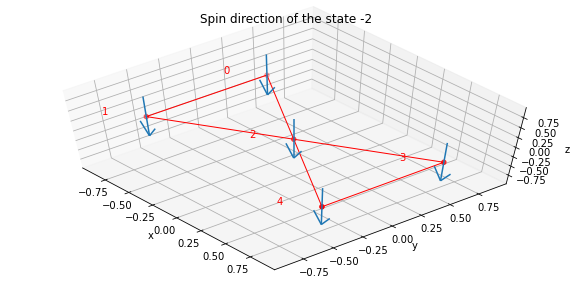

SYMMETRY a=1, b=1
Eigenstate:  3  - Eigenvalue:  -0.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   0.4999999999999999
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   0.5000000000000006
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   1.0000000000000004
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   0.5000000000000001
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   0.5000000000000001


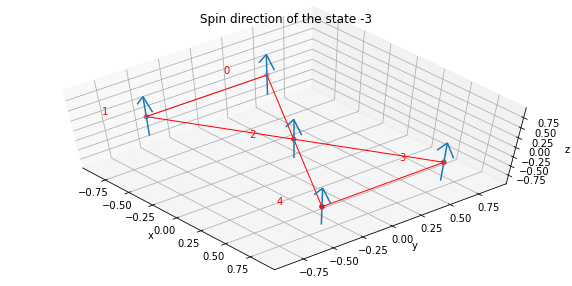

SYMMETRY a=1, b=1
Eigenstate:  4  - Eigenvalue:  0.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   -0.5000000000000001
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   -0.5000000000000006
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   -1.0000000000000004
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   -0.4999999999999999
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   -0.5000000000000001


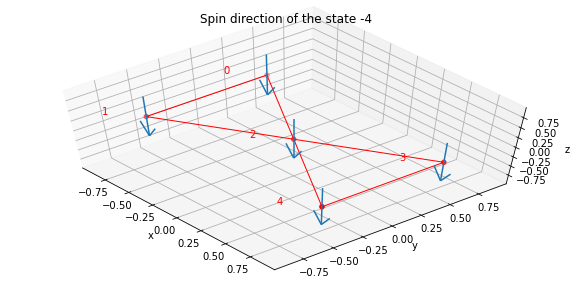

SYMMETRY a=1, b=1
Eigenstate:  5  - Eigenvalue:  0.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   0.16666666666666696
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   0.16666666666666657
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   0.3333333333333329
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   0.16666666666666657
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   0.16666666666666713


SYMMETRY a=1, b=0
Eigenstate:  6  - Eigenvalue:  -2.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   -0.33333333333333376
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   -0.3333333333333333
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   0.3333333333333332
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   -0.33333333333333315
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   -0.3333333333333332


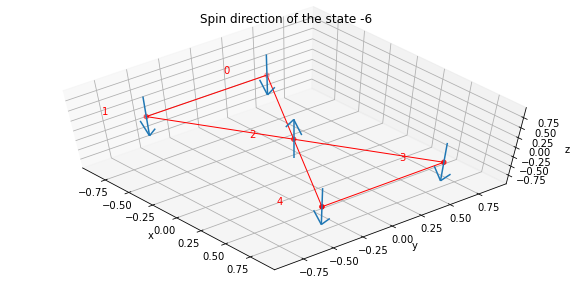

SYMMETRY a=1, b=0
Eigenstate:  7  - Eigenvalue:  -2.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   0.3333333333333332
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   0.33333333333333315
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   -0.33333333333333337
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   0.33333333333333387
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   0.3333333333333335


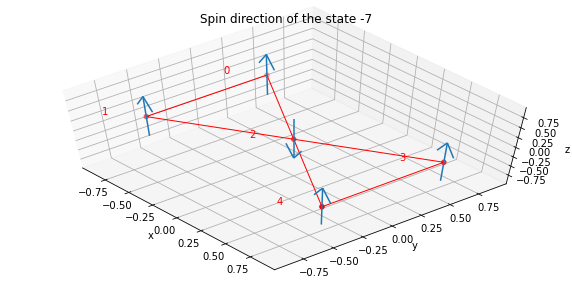

SYMMETRY a=1, b=0
Eigenstate:  8  - Eigenvalue:  4.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   0.16666666666666646
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   0.1666666666666664
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   0.3333333333333331
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   0.16666666666666713
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   0.166666666666667


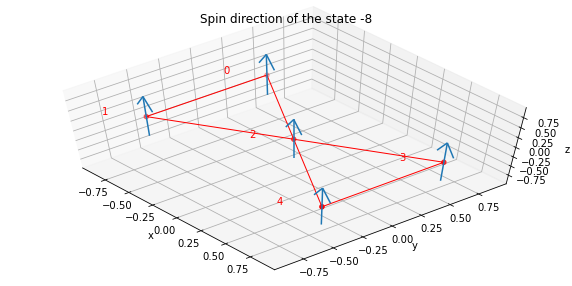

SYMMETRY a=1, b=0
Eigenstate:  9  - Eigenvalue:  4.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   -0.5000000000000006
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   -0.5000000000000001
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   -1.0000000000000004
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   -0.5000000000000001
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   -0.4999999999999999


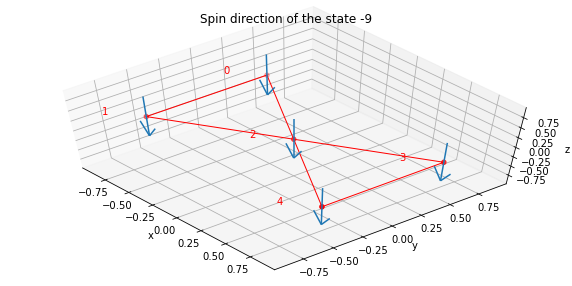

SYMMETRY a=1, b=0
Eigenstate:  10  - Eigenvalue:  4.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   -0.16666666666666718
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   -0.166666666666667
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   -0.3333333333333329
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   -0.16666666666666655
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   -0.16666666666666655


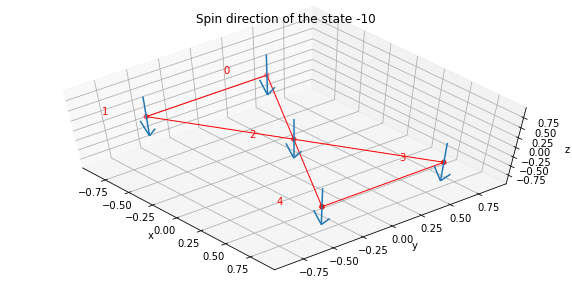

SYMMETRY a=1, b=0
Eigenstate:  11  - Eigenvalue:  4.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   0.5000000000000001
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   0.5000000000000001
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   1.0000000000000004
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   0.5000000000000006
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   0.4999999999999999


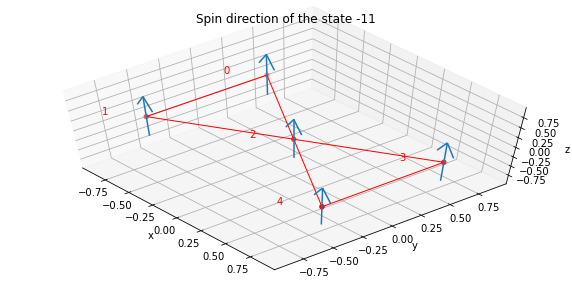

SYMMETRY a=0, b=1
Eigenstate:  12  - Eigenvalue:  -6.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   0.33333333333333365
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   0.3333333333333337
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   -0.3333333333333339
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   0.33333333333333354
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   0.3333333333333333


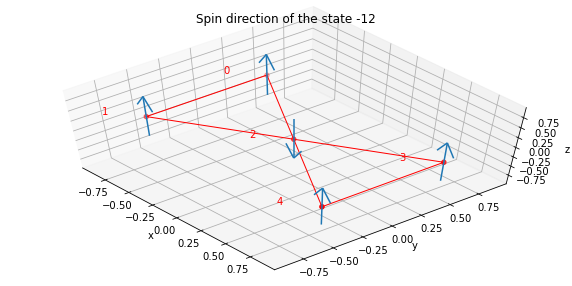

SYMMETRY a=0, b=1
Eigenstate:  13  - Eigenvalue:  -6.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   -0.3333333333333336
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   -0.3333333333333337
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   0.33333333333333387
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   -0.33333333333333365
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   -0.3333333333333333


SYMMETRY a=0, b=1
Eigenstate:  14  - Eigenvalue:  -0.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   0.5000000000000001
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   0.5000000000000001
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   1.0000000000000004
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   0.4999999999999999
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   0.5000000000000006


SYMMETRY a=0, b=1
Eigenstate:  15  - Eigenvalue:  0.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   -0.5000000000000001
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   -0.4999999999999999
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   -1.0000000000000004
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   -0.5000000000000006
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   -0.5000000000000001


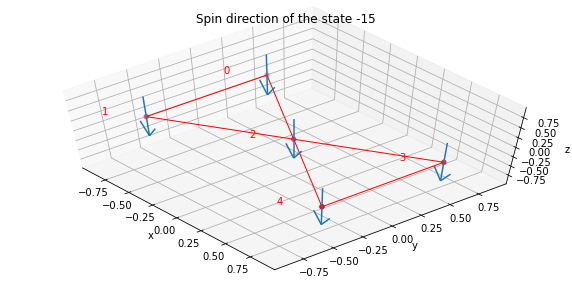

SYMMETRY a=0, b=1
Eigenstate:  16  - Eigenvalue:  0.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   -0.16666666666666669
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   -0.16666666666666663
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   -0.33333333333333365
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   -0.1666666666666668
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   -0.16666666666666657


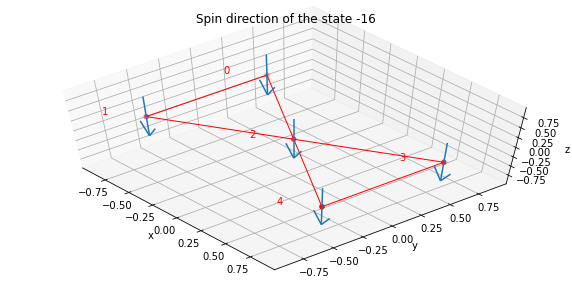

SYMMETRY a=0, b=1
Eigenstate:  17  - Eigenvalue:  0.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   0.1666666666666668
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   0.16666666666666674
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   0.3333333333333336
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   0.16666666666666674
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   0.16666666666666657


SYMMETRY a=0, b=0
Eigenstate:  18  - Eigenvalue:  -6.0
Spin expected value
Spin  0x   2.506771662324688e-31
Spin  0y   0.0
Spin  0z   -2.220446049250313e-16
Spin  1x   -3.378870247722705e-31
Spin  1y   0.0
Spin  1z   2.220446049250313e-16
Spin  2x   1.1917155550103388e-31
Spin  2y   0.0
Spin  2z   1.0000000000000002
Spin  3x   9.860761315262648e-32
Spin  3y   0.0
Spin  3z   -5.663251790611518e-32
Spin  4x   -1.9721522630525295e-31
Spin  4y   0.0
Spin  4z   -1.172016009550037e-30


SYMMETRY a=0, b=0
Eigenstate:  19  - Eigenvalue:  -6.0
Spin expected value
Spin  0x   8.492988615513944e-32
Spin  0y   0.0
Spin  0z   5.551115123125783e-17
Spin  1x   -9.379641268399605e-32
Spin  1y   0.0
Spin  1z   -5.551115123125783e-17
Spin  2x   9.739235332598075e-18
Spin  2y   0.0
Spin  2z   -0.9999999999999996
Spin  3x   2.465190328815662e-32
Spin  3y   0.0
Spin  3z   2.7755575615628904e-16
Spin  4x   -2.465190328815662e-32
Spin  4y   0.0
Spin  4z   -2.775557561562893e-16


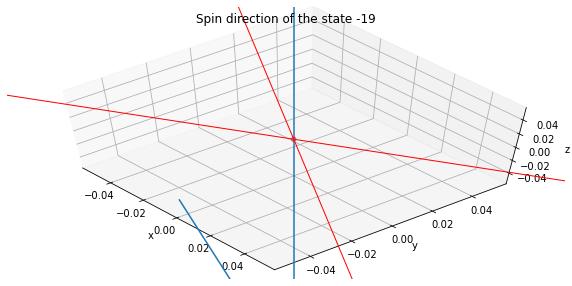

SYMMETRY a=0, b=0
Eigenstate:  20  - Eigenvalue:  -4.0
Spin expected value
Spin  0x   -0.06503521275969118
Spin  0y   0.0
Spin  0z   -0.8976409588196831
Spin  1x   -0.0650352127596912
Spin  1y   0.0
Spin  1z   -0.8976409588196832
Spin  2x   0.043356808506460814
Spin  2y   0.0
Spin  2z   0.5984273058797887
Spin  3x   -0.06503521275969117
Spin  3y   0.0
Spin  3z   -0.8976409588196832
Spin  4x   -0.06503521275969118
Spin  4y   0.0
Spin  4z   -0.8976409588196833


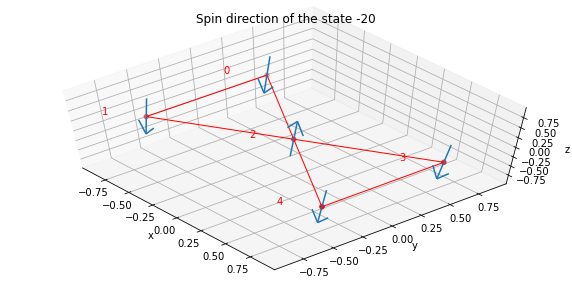

SYMMETRY a=0, b=0
Eigenstate:  21  - Eigenvalue:  -4.0
Spin expected value
Spin  0x   0.06503521275969103
Spin  0y   0.0
Spin  0z   -0.3023590411803163
Spin  1x   0.06503521275969103
Spin  1y   0.0
Spin  1z   -0.3023590411803165
Spin  2x   -0.043356808506460634
Spin  2y   0.0
Spin  2z   0.20157269412021106
Spin  3x   0.065035212759691
Spin  3y   0.0
Spin  3z   -0.30235904118031676
Spin  4x   0.06503521275969103
Spin  4y   0.0
Spin  4z   -0.30235904118031653


SYMMETRY a=0, b=0
Eigenstate:  22  - Eigenvalue:  -4.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   0.3000000000000004
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   0.3000000000000003
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   -0.2000000000000005
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   0.3000000000000001
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   0.30000000000000004


SYMMETRY a=0, b=0
Eigenstate:  23  - Eigenvalue:  -4.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   0.8999999999999999
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   0.8999999999999998
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   -0.5999999999999995
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   0.8999999999999999
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   0.8999999999999999


SYMMETRY a=0, b=0
Eigenstate:  24  - Eigenvalue:  2.0
Spin expected value
Spin  0x   -2.093316041242402e-32
Spin  0y   0.0
Spin  0z   1.1102230246251565e-16
Spin  1x   -1.8488927466117464e-32
Spin  1y   0.0
Spin  1z   3.0531133177191805e-16
Spin  2x   0.017709754491242877
Spin  2y   0.0
Spin  2z   0.999843170000105
Spin  3x   -9.244463733058732e-33
Spin  3y   0.0
Spin  3z   -2.220446049250313e-16
Spin  4x   1.8488927466117464e-32
Spin  4y   0.0
Spin  4z   -2.7755575615628914e-16


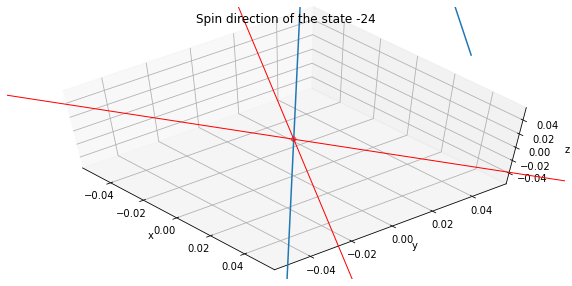

SYMMETRY a=0, b=0
Eigenstate:  25  - Eigenvalue:  2.0
Spin expected value
Spin  0x   -7.849931520383634e-32
Spin  0y   0.0
Spin  0z   1.6653345369377348e-16
Spin  1x   -1.4791141972893971e-31
Spin  1y   0.0
Spin  1z   8.326672684688674e-17
Spin  2x   -0.017709754491242447
Spin  2y   0.0
Spin  2z   -0.9998431700001056
Spin  3x   1.6023737137301802e-31
Spin  3y   0.0
Spin  3z   -5.551115123125783e-17
Spin  4x   -1.232595164407831e-32
Spin  4y   0.0
Spin  4z   -2.220446049250313e-16


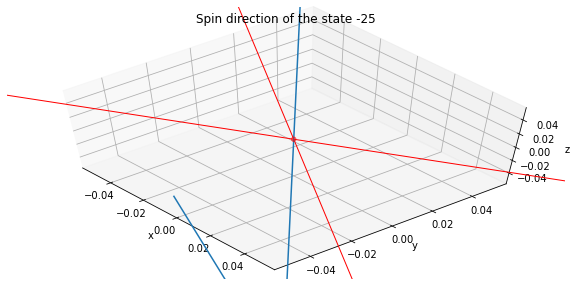

SYMMETRY a=0, b=0
Eigenstate:  26  - Eigenvalue:  6.0
Spin expected value
Spin  0x   -0.01574015661920652
Spin  0y   0.0
Spin  0z   -0.19128470142413984
Spin  1x   -0.01574015661920652
Spin  1y   0.0
Spin  1z   -0.19128470142414003
Spin  2x   -0.0157401566192066
Spin  2y   0.0
Spin  2z   -0.19128470142414009
Spin  3x   -0.01574015661920652
Spin  3y   0.0
Spin  3z   -0.19128470142414017
Spin  4x   -0.01574015661920652
Spin  4y   0.0
Spin  4z   -0.1912847014241402


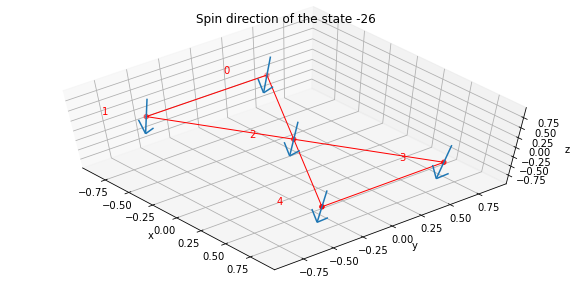

SYMMETRY a=0, b=0
Eigenstate:  27  - Eigenvalue:  6.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   0.20000000000000018
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   0.20000000000000023
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   0.19999999999999993
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   0.19999999999999993
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   0.1999999999999998


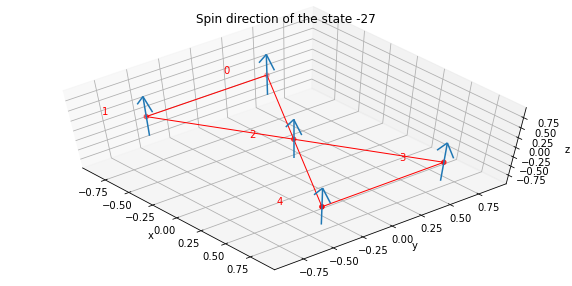

SYMMETRY a=0, b=0
Eigenstate:  28  - Eigenvalue:  6.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   -1.0
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   -1.0
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   -1.0
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   -1.0
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   -1.0


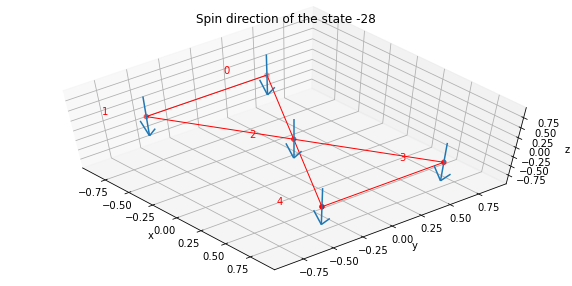

SYMMETRY a=0, b=0
Eigenstate:  29  - Eigenvalue:  6.0
Spin expected value
Spin  0x   0.0
Spin  0y   0.0
Spin  0z   0.6000000000000006
Spin  1x   0.0
Spin  1y   0.0
Spin  1z   0.6
Spin  2x   0.0
Spin  2y   0.0
Spin  2z   0.5999999999999999
Spin  3x   0.0
Spin  3y   0.0
Spin  3z   0.6000000000000002
Spin  4x   0.0
Spin  4y   0.0
Spin  4z   0.6000000000000002


SYMMETRY a=0, b=0
Eigenstate:  30  - Eigenvalue:  6.0
Spin expected value
Spin  0x   0.03327875216632101
Spin  0y   0.0
Spin  0z   -0.5427257370936277
Spin  1x   0.03327875216632101
Spin  1y   0.0
Spin  1z   -0.5427257370936279
Spin  2x   0.033278752166321236
Spin  2y   0.0
Spin  2z   -0.542725737093628
Spin  3x   0.03327875216632101
Spin  3y   0.0
Spin  3z   -0.5427257370936278
Spin  4x   0.03327875216632101
Spin  4y   0.0
Spin  4z   -0.5427257370936283


SYMMETRY a=0, b=0
Eigenstate:  31  - Eigenvalue:  6.0
Spin expected value
Spin  0x   -0.017538595547114757
Spin  0y   0.0
Spin  0z   0.9340104385177659
Spin  1x   -0.01753859554711476
Spin  1y   0.0
Spin  1z   0.9340104385177656
Spin  2x   -0.017538595547114826
Spin  2y   0.0
Spin  2z   0.9340104385177656
Spin  3x   -0.017538595547114757
Spin  3y   0.0
Spin  3z   0.9340104385177656
Spin  4x   -0.01753859554711476
Spin  4y   0.0
Spin  4z   0.9340104385177656


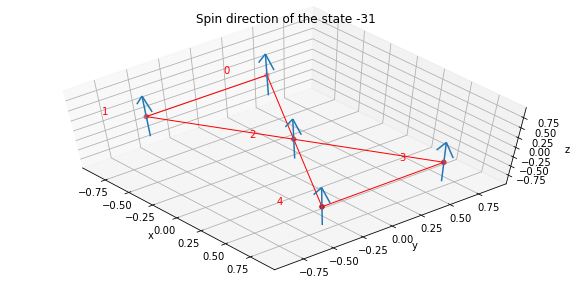

In [80]:
for jv,vec in enumerate(H_eigv_sym):
    u=[]
    v=[]
    w=[]
    
    if jv<6:
        print("SYMMETRY a=1, b=1")
    if 6<=jv<12:
        print("SYMMETRY a=1, b=0")
    if 12<=jv<18:
        print("SYMMETRY a=0, b=1")
    if jv>=18:
        print("SYMMETRY a=0, b=0")
    print("Eigenstate: ",jv," - Eigenvalue: ",e_tot[jv])
    
    print("Spin expected value")
    for js,s in enumerate(spins_mat):
        val=np.dot(np.dot(np.conjugate(vec),s),vec)
        print("Spin ",spins[js][0]," ",np.real(val))
        if (js%3)==0:
            u.append(round(val,6))
        if (js%3)==1:
            v.append(round(val,6))
        if(js%3)==2:
            w.append(round(val,6))
            
    fig = plt.figure(figsize=(10,5))
    ax = fig.gca(projection='3d')

        
    
    ax.set_title("Spin direction of the state -"+str(jv))
    ax.quiver(x,y,z,u,v,w,length=1, pivot='middle', normalize=True)
        
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.view_init(60,-40)
    set_axes_equal(ax)
        
    ax.scatter(x,y,z,color="r")
    ax.plot(x,y,z,"r",linewidth="1")
    ax.plot([-0.866,0,0.866],[0.5,0,-0.5],[0,0,0],"r",linewidth="1")
        
    for i,val in enumerate(x):
        ax.text(x[i]-0.2,y[i]-0.2,z[i],i,color='red')
            
    plt.show()

## Spin-spin correlation functions

We now want to study the spin-spin correlation functions, defined as follow:

$$ \langle S_i S_j \rangle_C =\langle S_i S_j \rangle - \langle S_i\rangle \langle S_j \rangle = \langle \sum_{\alpha=\{x,y,z\}} S_i^{\alpha} S_j^{\alpha} \rangle - \langle S_i\rangle \langle S_j \rangle$$

$S_i^{\alpha}$ is the spin operator acting on site $i$ of component $\alpha=\{x,y,z\}$ and the angular brackets refer to an expectation value. The "bow-tie" lattice is composed by $5$ sites, therefore we have to manage $25$ different spin-spin correlation functions. Because of simmetry considerations, we expect that $\langle S_i S_j \rangle_C=\langle S_j S_i \rangle_C$.

In [81]:
def generate_spinspin_operators(nqubit):
    spin_spin=[]
    for i in range(nqubit):
        for j in range(nqubit):
            xi = PauliOp(generate_pauli([i],[],nqubit));
            xj = PauliOp(generate_pauli([j],[],nqubit));
            
            yi = PauliOp(generate_pauli([i],[i],nqubit));
            yj = PauliOp(generate_pauli([j],[j],nqubit));
            
            zi = PauliOp(generate_pauli([],[i],nqubit));
            zj = PauliOp(generate_pauli([],[j],nqubit));
            
            spin_spin.append( (str(i)+'x-'+str(j)+'x',xi.compose(xj)))
            spin_spin.append( (str(i)+'y-'+str(j)+'y',yi.compose(yj)) )
            spin_spin.append( (str(i)+'z-'+str(j)+'z',zi.compose(zj)) )
            
    return spin_spin

spin_spin=generate_spinspin_operators(nqubit)
print("Spin-spin operators number: "+str(len(spin_spin)))
#for name_s,s in spin_spin:
#    print(name_s+' '+str(s))

Spin-spin operators number: 75


In [82]:
spin_spin_mat=[]

for name_s,s in spin_spin:
    spin_spin_mat.append(s.to_matrix())

SYMMETRY a=1, b=1
Eigenstate:  0  - Eigenvalue:  -6.0
     Spin-spin  0-0  (2.888889+0j)
     Spin-spin  0-1  (-1.111111+0j)
     Spin-spin  0-2  (-1.111111+0j)
     Spin-spin  0-3  (-1.111111+0j)
     Spin-spin  0-4  (0.888889+0j)
     Spin-spin  1-0  (-1.111111+0j)
     Spin-spin  1-1  (2.888889+0j)
     Spin-spin  1-2  (-1.111111+0j)
     Spin-spin  1-3  (0.888889+0j)
     Spin-spin  1-4  (-1.111111+0j)
     Spin-spin  2-0  (-1.111111+0j)
     Spin-spin  2-1  (-1.111111+0j)
     Spin-spin  2-2  (2.888889+0j)
     Spin-spin  2-3  (-1.111111+0j)
     Spin-spin  2-4  (-1.111111+0j)
     Spin-spin  3-0  (-1.111111+0j)
     Spin-spin  3-1  (0.888889+0j)
     Spin-spin  3-2  (-1.111111+0j)
     Spin-spin  3-3  (2.888889+0j)
     Spin-spin  3-4  (-1.111111+0j)
     Spin-spin  4-0  (0.888889+0j)
     Spin-spin  4-1  (-1.111111+0j)
     Spin-spin  4-2  (-1.111111+0j)
     Spin-spin  4-3  (-1.111111+0j)
     Spin-spin  4-4  (2.888889+0j)


<ipython-input-83-120e642494f6>:37: ComplexWarning: Casting complex values to real discards the imaginary part
  M[j,k]=ss[p]-s[p]


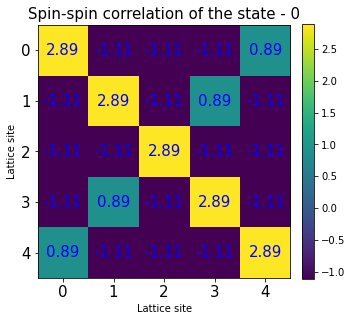

SYMMETRY a=1, b=1
Eigenstate:  1  - Eigenvalue:  -6.0
     Spin-spin  0-0  (2.888889+0j)
     Spin-spin  0-1  (-1.111111+0j)
     Spin-spin  0-2  (-1.111111+0j)
     Spin-spin  0-3  (-1.111111+0j)
     Spin-spin  0-4  (0.888889+0j)
     Spin-spin  1-0  (-1.111111+0j)
     Spin-spin  1-1  (2.888889+0j)
     Spin-spin  1-2  (-1.111111+0j)
     Spin-spin  1-3  (0.888889+0j)
     Spin-spin  1-4  (-1.111111+0j)
     Spin-spin  2-0  (-1.111111+0j)
     Spin-spin  2-1  (-1.111111+0j)
     Spin-spin  2-2  (2.888889+0j)
     Spin-spin  2-3  (-1.111111+0j)
     Spin-spin  2-4  (-1.111111+0j)
     Spin-spin  3-0  (-1.111111+0j)
     Spin-spin  3-1  (0.888889+0j)
     Spin-spin  3-2  (-1.111111+0j)
     Spin-spin  3-3  (2.888889+0j)
     Spin-spin  3-4  (-1.111111+0j)
     Spin-spin  4-0  (0.888889+0j)
     Spin-spin  4-1  (-1.111111+0j)
     Spin-spin  4-2  (-1.111111+0j)
     Spin-spin  4-3  (-1.111111+0j)
     Spin-spin  4-4  (2.888889+0j)


SYMMETRY a=1, b=1
Eigenstate:  2  - Eigenvalue:  -0.0
     Spin-spin  0-0  (2.972222+0j)
     Spin-spin  0-1  (-1.027778+0j)
     Spin-spin  0-2  (0.444444+0j)
     Spin-spin  0-3  (-1.027778+0j)
     Spin-spin  0-4  (0.972222+0j)
     Spin-spin  1-0  (-1.027778+0j)
     Spin-spin  1-1  (2.972222+0j)
     Spin-spin  1-2  (0.444444+0j)
     Spin-spin  1-3  (0.972222+0j)
     Spin-spin  1-4  (-1.027778+0j)
     Spin-spin  2-0  (0.444444+0j)
     Spin-spin  2-1  (0.444444+0j)
     Spin-spin  2-2  (2.888889+0j)
     Spin-spin  2-3  (0.444444+0j)
     Spin-spin  2-4  (0.444444+0j)
     Spin-spin  3-0  (-1.027778+0j)
     Spin-spin  3-1  (0.972222+0j)
     Spin-spin  3-2  (0.444444+0j)
     Spin-spin  3-3  (2.972222+0j)
     Spin-spin  3-4  (-1.027778+0j)
     Spin-spin  4-0  (0.972222+0j)
     Spin-spin  4-1  (-1.027778+0j)
     Spin-spin  4-2  (0.444444+0j)
     Spin-spin  4-3  (-1.027778+0j)
     Spin-spin  4-4  (2.972222+0j)


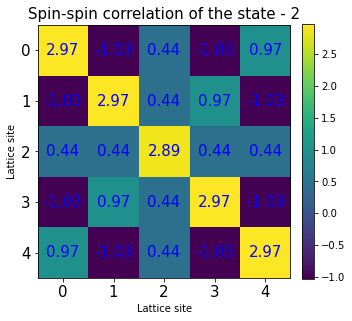

SYMMETRY a=1, b=1
Eigenstate:  3  - Eigenvalue:  -0.0
     Spin-spin  0-0  (2.75+0j)
     Spin-spin  0-1  (-1.25+0j)
     Spin-spin  0-2  (-0+0j)
     Spin-spin  0-3  (-1.25+0j)
     Spin-spin  0-4  (0.75+0j)
     Spin-spin  1-0  (-1.25+0j)
     Spin-spin  1-1  (2.75+0j)
     Spin-spin  1-2  (-0+0j)
     Spin-spin  1-3  (0.75+0j)
     Spin-spin  1-4  (-1.25+0j)
     Spin-spin  2-0  (-0+0j)
     Spin-spin  2-1  (-0+0j)
     Spin-spin  2-2  (2+0j)
     Spin-spin  2-3  (-0+0j)
     Spin-spin  2-4  (-0+0j)
     Spin-spin  3-0  (-1.25+0j)
     Spin-spin  3-1  (0.75+0j)
     Spin-spin  3-2  (-0+0j)
     Spin-spin  3-3  (2.75+0j)
     Spin-spin  3-4  (-1.25+0j)
     Spin-spin  4-0  (0.75+0j)
     Spin-spin  4-1  (-1.25+0j)
     Spin-spin  4-2  (-0+0j)
     Spin-spin  4-3  (-1.25+0j)
     Spin-spin  4-4  (2.75+0j)


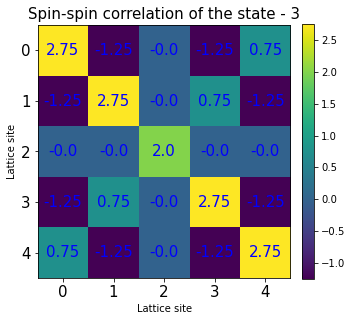

SYMMETRY a=1, b=1
Eigenstate:  4  - Eigenvalue:  0.0
     Spin-spin  0-0  (2.75+0j)
     Spin-spin  0-1  (-1.25+0j)
     Spin-spin  0-2  (-0+0j)
     Spin-spin  0-3  (-1.25+0j)
     Spin-spin  0-4  (0.75+0j)
     Spin-spin  1-0  (-1.25+0j)
     Spin-spin  1-1  (2.75+0j)
     Spin-spin  1-2  (-0+0j)
     Spin-spin  1-3  (0.75+0j)
     Spin-spin  1-4  (-1.25+0j)
     Spin-spin  2-0  (-0+0j)
     Spin-spin  2-1  (-0+0j)
     Spin-spin  2-2  (2+0j)
     Spin-spin  2-3  (-0+0j)
     Spin-spin  2-4  (-0+0j)
     Spin-spin  3-0  (-1.25+0j)
     Spin-spin  3-1  (0.75+0j)
     Spin-spin  3-2  (-0+0j)
     Spin-spin  3-3  (2.75+0j)
     Spin-spin  3-4  (-1.25+0j)
     Spin-spin  4-0  (0.75+0j)
     Spin-spin  4-1  (-1.25+0j)
     Spin-spin  4-2  (-0+0j)
     Spin-spin  4-3  (-1.25+0j)
     Spin-spin  4-4  (2.75+0j)


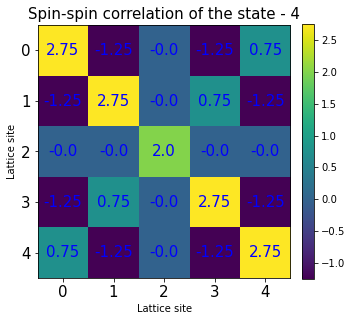

SYMMETRY a=1, b=1
Eigenstate:  5  - Eigenvalue:  0.0
     Spin-spin  0-0  (2.972222+0j)
     Spin-spin  0-1  (-1.027778+0j)
     Spin-spin  0-2  (0.444444+0j)
     Spin-spin  0-3  (-1.027778+0j)
     Spin-spin  0-4  (0.972222+0j)
     Spin-spin  1-0  (-1.027778+0j)
     Spin-spin  1-1  (2.972222+0j)
     Spin-spin  1-2  (0.444444+0j)
     Spin-spin  1-3  (0.972222+0j)
     Spin-spin  1-4  (-1.027778+0j)
     Spin-spin  2-0  (0.444444+0j)
     Spin-spin  2-1  (0.444444+0j)
     Spin-spin  2-2  (2.888889+0j)
     Spin-spin  2-3  (0.444444+0j)
     Spin-spin  2-4  (0.444444+0j)
     Spin-spin  3-0  (-1.027778+0j)
     Spin-spin  3-1  (0.972222+0j)
     Spin-spin  3-2  (0.444444+0j)
     Spin-spin  3-3  (2.972222+0j)
     Spin-spin  3-4  (-1.027778+0j)
     Spin-spin  4-0  (0.972222+0j)
     Spin-spin  4-1  (-1.027778+0j)
     Spin-spin  4-2  (0.444444+0j)
     Spin-spin  4-3  (-1.027778+0j)
     Spin-spin  4-4  (2.972222+0j)


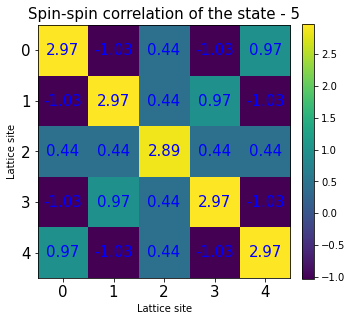

SYMMETRY a=1, b=0
Eigenstate:  6  - Eigenvalue:  -2.0
     Spin-spin  0-0  (2.888889+0j)
     Spin-spin  0-1  (0.888889+0j)
     Spin-spin  0-2  (-1.111111+0j)
     Spin-spin  0-3  (-1.111111+0j)
     Spin-spin  0-4  (-1.111111+0j)
     Spin-spin  1-0  (0.888889+0j)
     Spin-spin  1-1  (2.888889+0j)
     Spin-spin  1-2  (-1.111111+0j)
     Spin-spin  1-3  (-1.111111+0j)
     Spin-spin  1-4  (-1.111111+0j)
     Spin-spin  2-0  (-1.111111+0j)
     Spin-spin  2-1  (-1.111111+0j)
     Spin-spin  2-2  (2.888889+0j)
     Spin-spin  2-3  (-1.111111+0j)
     Spin-spin  2-4  (-1.111111+0j)
     Spin-spin  3-0  (-1.111111+0j)
     Spin-spin  3-1  (-1.111111+0j)
     Spin-spin  3-2  (-1.111111+0j)
     Spin-spin  3-3  (2.888889+0j)
     Spin-spin  3-4  (0.888889+0j)
     Spin-spin  4-0  (-1.111111+0j)
     Spin-spin  4-1  (-1.111111+0j)
     Spin-spin  4-2  (-1.111111+0j)
     Spin-spin  4-3  (0.888889+0j)
     Spin-spin  4-4  (2.888889+0j)


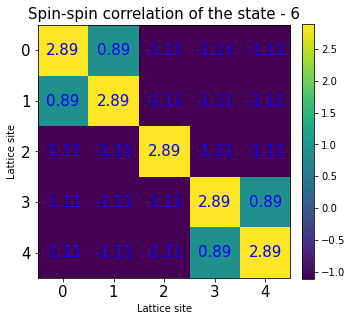

SYMMETRY a=1, b=0
Eigenstate:  7  - Eigenvalue:  -2.0
     Spin-spin  0-0  (2.888889+0j)
     Spin-spin  0-1  (0.888889+0j)
     Spin-spin  0-2  (-1.111111+0j)
     Spin-spin  0-3  (-1.111111+0j)
     Spin-spin  0-4  (-1.111111+0j)
     Spin-spin  1-0  (0.888889+0j)
     Spin-spin  1-1  (2.888889+0j)
     Spin-spin  1-2  (-1.111111+0j)
     Spin-spin  1-3  (-1.111111+0j)
     Spin-spin  1-4  (-1.111111+0j)
     Spin-spin  2-0  (-1.111111+0j)
     Spin-spin  2-1  (-1.111111+0j)
     Spin-spin  2-2  (2.888889+0j)
     Spin-spin  2-3  (-1.111111+0j)
     Spin-spin  2-4  (-1.111111+0j)
     Spin-spin  3-0  (-1.111111+0j)
     Spin-spin  3-1  (-1.111111+0j)
     Spin-spin  3-2  (-1.111111+0j)
     Spin-spin  3-3  (2.888889+0j)
     Spin-spin  3-4  (0.888889+0j)
     Spin-spin  4-0  (-1.111111+0j)
     Spin-spin  4-1  (-1.111111+0j)
     Spin-spin  4-2  (-1.111111+0j)
     Spin-spin  4-3  (0.888889+0j)
     Spin-spin  4-4  (2.888889+0j)


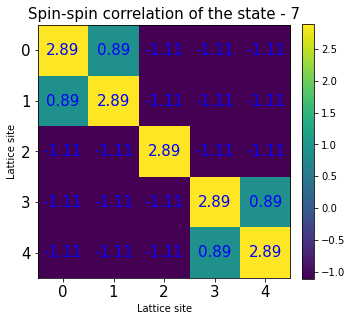

SYMMETRY a=1, b=0
Eigenstate:  8  - Eigenvalue:  4.0
     Spin-spin  0-0  (2.972222+0j)
     Spin-spin  0-1  (0.972222+0j)
     Spin-spin  0-2  (0.444444+0j)
     Spin-spin  0-3  (-1.027778+0j)
     Spin-spin  0-4  (-1.027778+0j)
     Spin-spin  1-0  (0.972222+0j)
     Spin-spin  1-1  (2.972222+0j)
     Spin-spin  1-2  (0.444444+0j)
     Spin-spin  1-3  (-1.027778+0j)
     Spin-spin  1-4  (-1.027778+0j)
     Spin-spin  2-0  (0.444444+0j)
     Spin-spin  2-1  (0.444444+0j)
     Spin-spin  2-2  (2.888889+0j)
     Spin-spin  2-3  (0.444444+0j)
     Spin-spin  2-4  (0.444444+0j)
     Spin-spin  3-0  (-1.027778+0j)
     Spin-spin  3-1  (-1.027778+0j)
     Spin-spin  3-2  (0.444444+0j)
     Spin-spin  3-3  (2.972222+0j)
     Spin-spin  3-4  (0.972222+0j)
     Spin-spin  4-0  (-1.027778+0j)
     Spin-spin  4-1  (-1.027778+0j)
     Spin-spin  4-2  (0.444444+0j)
     Spin-spin  4-3  (0.972222+0j)
     Spin-spin  4-4  (2.972222+0j)


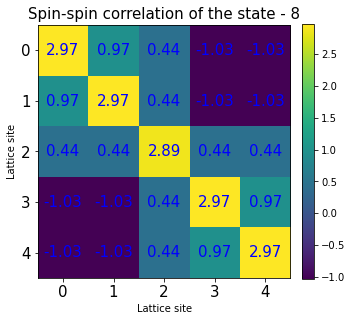

SYMMETRY a=1, b=0
Eigenstate:  9  - Eigenvalue:  4.0
     Spin-spin  0-0  (2.75+0j)
     Spin-spin  0-1  (0.75+0j)
     Spin-spin  0-2  (-0+0j)
     Spin-spin  0-3  (-1.25+0j)
     Spin-spin  0-4  (-1.25+0j)
     Spin-spin  1-0  (0.75+0j)
     Spin-spin  1-1  (2.75+0j)
     Spin-spin  1-2  (-0+0j)
     Spin-spin  1-3  (-1.25+0j)
     Spin-spin  1-4  (-1.25+0j)
     Spin-spin  2-0  (-0+0j)
     Spin-spin  2-1  (-0+0j)
     Spin-spin  2-2  (2+0j)
     Spin-spin  2-3  (-0+0j)
     Spin-spin  2-4  (-0+0j)
     Spin-spin  3-0  (-1.25+0j)
     Spin-spin  3-1  (-1.25+0j)
     Spin-spin  3-2  (-0+0j)
     Spin-spin  3-3  (2.75+0j)
     Spin-spin  3-4  (0.75+0j)
     Spin-spin  4-0  (-1.25+0j)
     Spin-spin  4-1  (-1.25+0j)
     Spin-spin  4-2  (-0+0j)
     Spin-spin  4-3  (0.75+0j)
     Spin-spin  4-4  (2.75+0j)


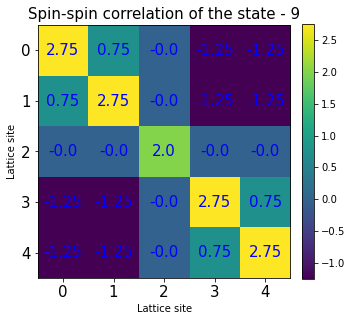

SYMMETRY a=1, b=0
Eigenstate:  10  - Eigenvalue:  4.0
     Spin-spin  0-0  (2.972222+0j)
     Spin-spin  0-1  (0.972222+0j)
     Spin-spin  0-2  (0.444444+0j)
     Spin-spin  0-3  (-1.027778+0j)
     Spin-spin  0-4  (-1.027778+0j)
     Spin-spin  1-0  (0.972222+0j)
     Spin-spin  1-1  (2.972222+0j)
     Spin-spin  1-2  (0.444444+0j)
     Spin-spin  1-3  (-1.027778+0j)
     Spin-spin  1-4  (-1.027778+0j)
     Spin-spin  2-0  (0.444444+0j)
     Spin-spin  2-1  (0.444444+0j)
     Spin-spin  2-2  (2.888889+0j)
     Spin-spin  2-3  (0.444444+0j)
     Spin-spin  2-4  (0.444444+0j)
     Spin-spin  3-0  (-1.027778+0j)
     Spin-spin  3-1  (-1.027778+0j)
     Spin-spin  3-2  (0.444444+0j)
     Spin-spin  3-3  (2.972222+0j)
     Spin-spin  3-4  (0.972222+0j)
     Spin-spin  4-0  (-1.027778+0j)
     Spin-spin  4-1  (-1.027778+0j)
     Spin-spin  4-2  (0.444444+0j)
     Spin-spin  4-3  (0.972222+0j)
     Spin-spin  4-4  (2.972222+0j)


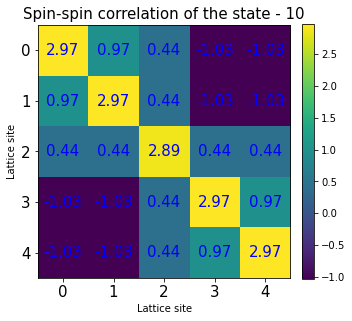

SYMMETRY a=1, b=0
Eigenstate:  11  - Eigenvalue:  4.0
     Spin-spin  0-0  (2.75+0j)
     Spin-spin  0-1  (0.75+0j)
     Spin-spin  0-2  (-0+0j)
     Spin-spin  0-3  (-1.25+0j)
     Spin-spin  0-4  (-1.25+0j)
     Spin-spin  1-0  (0.75+0j)
     Spin-spin  1-1  (2.75+0j)
     Spin-spin  1-2  (-0+0j)
     Spin-spin  1-3  (-1.25+0j)
     Spin-spin  1-4  (-1.25+0j)
     Spin-spin  2-0  (-0+0j)
     Spin-spin  2-1  (-0+0j)
     Spin-spin  2-2  (2+0j)
     Spin-spin  2-3  (-0+0j)
     Spin-spin  2-4  (-0+0j)
     Spin-spin  3-0  (-1.25+0j)
     Spin-spin  3-1  (-1.25+0j)
     Spin-spin  3-2  (-0+0j)
     Spin-spin  3-3  (2.75+0j)
     Spin-spin  3-4  (0.75+0j)
     Spin-spin  4-0  (-1.25+0j)
     Spin-spin  4-1  (-1.25+0j)
     Spin-spin  4-2  (-0+0j)
     Spin-spin  4-3  (0.75+0j)
     Spin-spin  4-4  (2.75+0j)


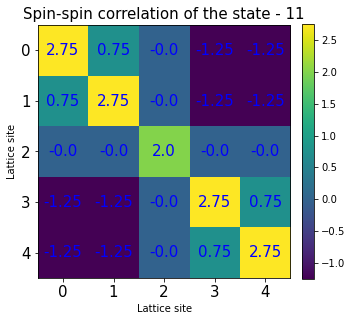

SYMMETRY a=0, b=1
Eigenstate:  12  - Eigenvalue:  -6.0
     Spin-spin  0-0  (2.888889+0j)
     Spin-spin  0-1  (-1.111111+0j)
     Spin-spin  0-2  (-1.111111+0j)
     Spin-spin  0-3  (0.888889+0j)
     Spin-spin  0-4  (-1.111111+0j)
     Spin-spin  1-0  (-1.111111+0j)
     Spin-spin  1-1  (2.888889+0j)
     Spin-spin  1-2  (-1.111111+0j)
     Spin-spin  1-3  (-1.111111+0j)
     Spin-spin  1-4  (0.888889+0j)
     Spin-spin  2-0  (-1.111111+0j)
     Spin-spin  2-1  (-1.111111+0j)
     Spin-spin  2-2  (2.888889+0j)
     Spin-spin  2-3  (-1.111111+0j)
     Spin-spin  2-4  (-1.111111+0j)
     Spin-spin  3-0  (0.888889+0j)
     Spin-spin  3-1  (-1.111111+0j)
     Spin-spin  3-2  (-1.111111+0j)
     Spin-spin  3-3  (2.888889+0j)
     Spin-spin  3-4  (-1.111111+0j)
     Spin-spin  4-0  (-1.111111+0j)
     Spin-spin  4-1  (0.888889+0j)
     Spin-spin  4-2  (-1.111111+0j)
     Spin-spin  4-3  (-1.111111+0j)
     Spin-spin  4-4  (2.888889+0j)


SYMMETRY a=0, b=1
Eigenstate:  13  - Eigenvalue:  -6.0
     Spin-spin  0-0  (2.888889+0j)
     Spin-spin  0-1  (-1.111111+0j)
     Spin-spin  0-2  (-1.111111+0j)
     Spin-spin  0-3  (0.888889+0j)
     Spin-spin  0-4  (-1.111111+0j)
     Spin-spin  1-0  (-1.111111+0j)
     Spin-spin  1-1  (2.888889+0j)
     Spin-spin  1-2  (-1.111111+0j)
     Spin-spin  1-3  (-1.111111+0j)
     Spin-spin  1-4  (0.888889+0j)
     Spin-spin  2-0  (-1.111111+0j)
     Spin-spin  2-1  (-1.111111+0j)
     Spin-spin  2-2  (2.888889+0j)
     Spin-spin  2-3  (-1.111111+0j)
     Spin-spin  2-4  (-1.111111+0j)
     Spin-spin  3-0  (0.888889+0j)
     Spin-spin  3-1  (-1.111111+0j)
     Spin-spin  3-2  (-1.111111+0j)
     Spin-spin  3-3  (2.888889+0j)
     Spin-spin  3-4  (-1.111111+0j)
     Spin-spin  4-0  (-1.111111+0j)
     Spin-spin  4-1  (0.888889+0j)
     Spin-spin  4-2  (-1.111111+0j)
     Spin-spin  4-3  (-1.111111+0j)
     Spin-spin  4-4  (2.888889+0j)


SYMMETRY a=0, b=1
Eigenstate:  14  - Eigenvalue:  -0.0
     Spin-spin  0-0  (2.75+0j)
     Spin-spin  0-1  (-1.25+0j)
     Spin-spin  0-2  (-0+0j)
     Spin-spin  0-3  (0.75+0j)
     Spin-spin  0-4  (-1.25+0j)
     Spin-spin  1-0  (-1.25+0j)
     Spin-spin  1-1  (2.75+0j)
     Spin-spin  1-2  (-0+0j)
     Spin-spin  1-3  (-1.25+0j)
     Spin-spin  1-4  (0.75+0j)
     Spin-spin  2-0  (-0+0j)
     Spin-spin  2-1  (-0+0j)
     Spin-spin  2-2  (2+0j)
     Spin-spin  2-3  (-0+0j)
     Spin-spin  2-4  (-0+0j)
     Spin-spin  3-0  (0.75+0j)
     Spin-spin  3-1  (-1.25+0j)
     Spin-spin  3-2  (-0+0j)
     Spin-spin  3-3  (2.75+0j)
     Spin-spin  3-4  (-1.25+0j)
     Spin-spin  4-0  (-1.25+0j)
     Spin-spin  4-1  (0.75+0j)
     Spin-spin  4-2  (-0+0j)
     Spin-spin  4-3  (-1.25+0j)
     Spin-spin  4-4  (2.75+0j)


SYMMETRY a=0, b=1
Eigenstate:  15  - Eigenvalue:  0.0
     Spin-spin  0-0  (2.75+0j)
     Spin-spin  0-1  (-1.25+0j)
     Spin-spin  0-2  (-0+0j)
     Spin-spin  0-3  (0.75+0j)
     Spin-spin  0-4  (-1.25+0j)
     Spin-spin  1-0  (-1.25+0j)
     Spin-spin  1-1  (2.75+0j)
     Spin-spin  1-2  (-0+0j)
     Spin-spin  1-3  (-1.25+0j)
     Spin-spin  1-4  (0.75+0j)
     Spin-spin  2-0  (-0+0j)
     Spin-spin  2-1  (-0+0j)
     Spin-spin  2-2  (2+0j)
     Spin-spin  2-3  (-0+0j)
     Spin-spin  2-4  (-0+0j)
     Spin-spin  3-0  (0.75+0j)
     Spin-spin  3-1  (-1.25+0j)
     Spin-spin  3-2  (-0+0j)
     Spin-spin  3-3  (2.75+0j)
     Spin-spin  3-4  (-1.25+0j)
     Spin-spin  4-0  (-1.25+0j)
     Spin-spin  4-1  (0.75+0j)
     Spin-spin  4-2  (-0+0j)
     Spin-spin  4-3  (-1.25+0j)
     Spin-spin  4-4  (2.75+0j)


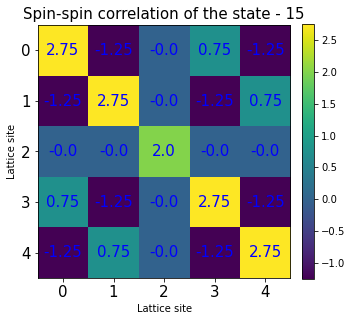

SYMMETRY a=0, b=1
Eigenstate:  16  - Eigenvalue:  0.0
     Spin-spin  0-0  (2.972222+0j)
     Spin-spin  0-1  (-1.027778+0j)
     Spin-spin  0-2  (0.444444+0j)
     Spin-spin  0-3  (0.972222+0j)
     Spin-spin  0-4  (-1.027778+0j)
     Spin-spin  1-0  (-1.027778+0j)
     Spin-spin  1-1  (2.972222+0j)
     Spin-spin  1-2  (0.444444+0j)
     Spin-spin  1-3  (-1.027778+0j)
     Spin-spin  1-4  (0.972222+0j)
     Spin-spin  2-0  (0.444444+0j)
     Spin-spin  2-1  (0.444444+0j)
     Spin-spin  2-2  (2.888889+0j)
     Spin-spin  2-3  (0.444444+0j)
     Spin-spin  2-4  (0.444444+0j)
     Spin-spin  3-0  (0.972222+0j)
     Spin-spin  3-1  (-1.027778+0j)
     Spin-spin  3-2  (0.444444+0j)
     Spin-spin  3-3  (2.972222+0j)
     Spin-spin  3-4  (-1.027778+0j)
     Spin-spin  4-0  (-1.027778+0j)
     Spin-spin  4-1  (0.972222+0j)
     Spin-spin  4-2  (0.444444+0j)
     Spin-spin  4-3  (-1.027778+0j)
     Spin-spin  4-4  (2.972222+0j)


SYMMETRY a=0, b=1
Eigenstate:  17  - Eigenvalue:  0.0
     Spin-spin  0-0  (2.972222+0j)
     Spin-spin  0-1  (-1.027778+0j)
     Spin-spin  0-2  (0.444444+0j)
     Spin-spin  0-3  (0.972222+0j)
     Spin-spin  0-4  (-1.027778+0j)
     Spin-spin  1-0  (-1.027778+0j)
     Spin-spin  1-1  (2.972222+0j)
     Spin-spin  1-2  (0.444444+0j)
     Spin-spin  1-3  (-1.027778+0j)
     Spin-spin  1-4  (0.972222+0j)
     Spin-spin  2-0  (0.444444+0j)
     Spin-spin  2-1  (0.444444+0j)
     Spin-spin  2-2  (2.888889+0j)
     Spin-spin  2-3  (0.444444+0j)
     Spin-spin  2-4  (0.444444+0j)
     Spin-spin  3-0  (0.972222+0j)
     Spin-spin  3-1  (-1.027778+0j)
     Spin-spin  3-2  (0.444444+0j)
     Spin-spin  3-3  (2.972222+0j)
     Spin-spin  3-4  (-1.027778+0j)
     Spin-spin  4-0  (-1.027778+0j)
     Spin-spin  4-1  (0.972222+0j)
     Spin-spin  4-2  (0.444444+0j)
     Spin-spin  4-3  (-1.027778+0j)
     Spin-spin  4-4  (2.972222+0j)


SYMMETRY a=0, b=0
Eigenstate:  18  - Eigenvalue:  -6.0
     Spin-spin  0-0  (3+0j)
     Spin-spin  0-1  (-3+0j)
     Spin-spin  0-2  (-0+0j)
     Spin-spin  0-3  (-0+0j)
     Spin-spin  0-4  0j
     Spin-spin  1-0  (-3+0j)
     Spin-spin  1-1  (3+0j)
     Spin-spin  1-2  (-0+0j)
     Spin-spin  1-3  0j
     Spin-spin  1-4  (-0+0j)
     Spin-spin  2-0  (-0+0j)
     Spin-spin  2-1  (-0+0j)
     Spin-spin  2-2  (2+0j)
     Spin-spin  2-3  (-0+0j)
     Spin-spin  2-4  (-0+0j)
     Spin-spin  3-0  (-0+0j)
     Spin-spin  3-1  0j
     Spin-spin  3-2  (-0+0j)
     Spin-spin  3-3  (3+0j)
     Spin-spin  3-4  (-3+0j)
     Spin-spin  4-0  0j
     Spin-spin  4-1  (-0+0j)
     Spin-spin  4-2  (-0+0j)
     Spin-spin  4-3  (-3+0j)
     Spin-spin  4-4  (3+0j)


SYMMETRY a=0, b=0
Eigenstate:  19  - Eigenvalue:  -6.0
     Spin-spin  0-0  (3+0j)
     Spin-spin  0-1  (-3+0j)
     Spin-spin  0-2  (-0+0j)
     Spin-spin  0-3  (-0+0j)
     Spin-spin  0-4  0j
     Spin-spin  1-0  (-3+0j)
     Spin-spin  1-1  (3+0j)
     Spin-spin  1-2  0j
     Spin-spin  1-3  0j
     Spin-spin  1-4  (-0+0j)
     Spin-spin  2-0  (-0+0j)
     Spin-spin  2-1  0j
     Spin-spin  2-2  (2+0j)
     Spin-spin  2-3  (-0+0j)
     Spin-spin  2-4  (-0+0j)
     Spin-spin  3-0  (-0+0j)
     Spin-spin  3-1  0j
     Spin-spin  3-2  (-0+0j)
     Spin-spin  3-3  (3+0j)
     Spin-spin  3-4  (-3+0j)
     Spin-spin  4-0  0j
     Spin-spin  4-1  (-0+0j)
     Spin-spin  4-2  (-0+0j)
     Spin-spin  4-3  (-3+0j)
     Spin-spin  4-4  (3+0j)


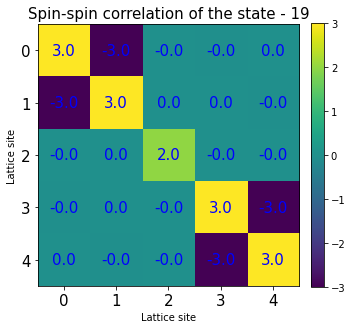

SYMMETRY a=0, b=0
Eigenstate:  20  - Eigenvalue:  -4.0
     Spin-spin  0-0  (2.190011+0j)
     Spin-spin  0-1  (0.190011+0j)
     Spin-spin  0-2  (-2.039993+0j)
     Spin-spin  0-3  (0.190011+0j)
     Spin-spin  0-4  (0.190011+0j)
     Spin-spin  1-0  (0.190011+0j)
     Spin-spin  1-1  (2.190011+0j)
     Spin-spin  1-2  (-2.039993+0j)
     Spin-spin  1-3  (0.190011+0j)
     Spin-spin  1-4  (0.190011+0j)
     Spin-spin  2-0  (-2.039993+0j)
     Spin-spin  2-1  (-2.039993+0j)
     Spin-spin  2-2  (2.640005+0j)
     Spin-spin  2-3  (-2.039993+0j)
     Spin-spin  2-4  (-2.039993+0j)
     Spin-spin  3-0  (0.190011+0j)
     Spin-spin  3-1  (0.190011+0j)
     Spin-spin  3-2  (-2.039993+0j)
     Spin-spin  3-3  (2.190011+0j)
     Spin-spin  3-4  (0.190011+0j)
     Spin-spin  4-0  (0.190011+0j)
     Spin-spin  4-1  (0.190011+0j)
     Spin-spin  4-2  (-2.039993+0j)
     Spin-spin  4-3  (0.190011+0j)
     Spin-spin  4-4  (2.190011+0j)


SYMMETRY a=0, b=0
Eigenstate:  21  - Eigenvalue:  -4.0
     Spin-spin  0-0  (2.904349+0j)
     Spin-spin  0-1  (0.904349+0j)
     Spin-spin  0-2  (-1.563767+0j)
     Spin-spin  0-3  (0.904349+0j)
     Spin-spin  0-4  (0.904349+0j)
     Spin-spin  1-0  (0.904349+0j)
     Spin-spin  1-1  (2.904349+0j)
     Spin-spin  1-2  (-1.563767+0j)
     Spin-spin  1-3  (0.904349+0j)
     Spin-spin  1-4  (0.904349+0j)
     Spin-spin  2-0  (-1.563767+0j)
     Spin-spin  2-1  (-1.563767+0j)
     Spin-spin  2-2  (2.957489+0j)
     Spin-spin  2-3  (-1.563767+0j)
     Spin-spin  2-4  (-1.563767+0j)
     Spin-spin  3-0  (0.904349+0j)
     Spin-spin  3-1  (0.904349+0j)
     Spin-spin  3-2  (-1.563767+0j)
     Spin-spin  3-3  (2.904349+0j)
     Spin-spin  3-4  (0.904349+0j)
     Spin-spin  4-0  (0.904349+0j)
     Spin-spin  4-1  (0.904349+0j)
     Spin-spin  4-2  (-1.563767+0j)
     Spin-spin  4-3  (0.904349+0j)
     Spin-spin  4-4  (2.904349+0j)


SYMMETRY a=0, b=0
Eigenstate:  22  - Eigenvalue:  -4.0
     Spin-spin  0-0  (2.91+0j)
     Spin-spin  0-1  (0.91+0j)
     Spin-spin  0-2  (-1.56+0j)
     Spin-spin  0-3  (0.91+0j)
     Spin-spin  0-4  (0.91+0j)
     Spin-spin  1-0  (0.91+0j)
     Spin-spin  1-1  (2.91+0j)
     Spin-spin  1-2  (-1.56+0j)
     Spin-spin  1-3  (0.91+0j)
     Spin-spin  1-4  (0.91+0j)
     Spin-spin  2-0  (-1.56+0j)
     Spin-spin  2-1  (-1.56+0j)
     Spin-spin  2-2  (2.96+0j)
     Spin-spin  2-3  (-1.56+0j)
     Spin-spin  2-4  (-1.56+0j)
     Spin-spin  3-0  (0.91+0j)
     Spin-spin  3-1  (0.91+0j)
     Spin-spin  3-2  (-1.56+0j)
     Spin-spin  3-3  (2.91+0j)
     Spin-spin  3-4  (0.91+0j)
     Spin-spin  4-0  (0.91+0j)
     Spin-spin  4-1  (0.91+0j)
     Spin-spin  4-2  (-1.56+0j)
     Spin-spin  4-3  (0.91+0j)
     Spin-spin  4-4  (2.91+0j)


SYMMETRY a=0, b=0
Eigenstate:  23  - Eigenvalue:  -4.0
     Spin-spin  0-0  (2.19+0j)
     Spin-spin  0-1  (0.19+0j)
     Spin-spin  0-2  (-2.04+0j)
     Spin-spin  0-3  (0.19+0j)
     Spin-spin  0-4  (0.19+0j)
     Spin-spin  1-0  (0.19+0j)
     Spin-spin  1-1  (2.19+0j)
     Spin-spin  1-2  (-2.04+0j)
     Spin-spin  1-3  (0.19+0j)
     Spin-spin  1-4  (0.19+0j)
     Spin-spin  2-0  (-2.04+0j)
     Spin-spin  2-1  (-2.04+0j)
     Spin-spin  2-2  (2.64+0j)
     Spin-spin  2-3  (-2.04+0j)
     Spin-spin  2-4  (-2.04+0j)
     Spin-spin  3-0  (0.19+0j)
     Spin-spin  3-1  (0.19+0j)
     Spin-spin  3-2  (-2.04+0j)
     Spin-spin  3-3  (2.19+0j)
     Spin-spin  3-4  (0.19+0j)
     Spin-spin  4-0  (0.19+0j)
     Spin-spin  4-1  (0.19+0j)
     Spin-spin  4-2  (-2.04+0j)
     Spin-spin  4-3  (0.19+0j)
     Spin-spin  4-4  (2.19+0j)


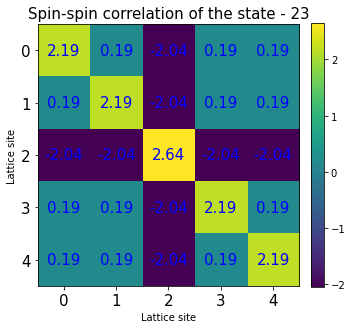

SYMMETRY a=0, b=0
Eigenstate:  24  - Eigenvalue:  2.0
     Spin-spin  0-0  (3+0j)
     Spin-spin  0-1  (1+0j)
     Spin-spin  0-2  (-0+0j)
     Spin-spin  0-3  (-2+0j)
     Spin-spin  0-4  (-2+0j)
     Spin-spin  1-0  (1+0j)
     Spin-spin  1-1  (3+0j)
     Spin-spin  1-2  0j
     Spin-spin  1-3  (-2+0j)
     Spin-spin  1-4  (-2+0j)
     Spin-spin  2-0  (-0+0j)
     Spin-spin  2-1  0j
     Spin-spin  2-2  (2+0j)
     Spin-spin  2-3  (-0+0j)
     Spin-spin  2-4  (-0+0j)
     Spin-spin  3-0  (-2+0j)
     Spin-spin  3-1  (-2+0j)
     Spin-spin  3-2  (-0+0j)
     Spin-spin  3-3  (3+0j)
     Spin-spin  3-4  (1+0j)
     Spin-spin  4-0  (-2+0j)
     Spin-spin  4-1  (-2+0j)
     Spin-spin  4-2  (-0+0j)
     Spin-spin  4-3  (1+0j)
     Spin-spin  4-4  (3+0j)


SYMMETRY a=0, b=0
Eigenstate:  25  - Eigenvalue:  2.0
     Spin-spin  0-0  (3+0j)
     Spin-spin  0-1  (1+0j)
     Spin-spin  0-2  (-0+0j)
     Spin-spin  0-3  (-2+0j)
     Spin-spin  0-4  (-2+0j)
     Spin-spin  1-0  (1+0j)
     Spin-spin  1-1  (3+0j)
     Spin-spin  1-2  (-0+0j)
     Spin-spin  1-3  (-2+0j)
     Spin-spin  1-4  (-2+0j)
     Spin-spin  2-0  (-0+0j)
     Spin-spin  2-1  (-0+0j)
     Spin-spin  2-2  (2+0j)
     Spin-spin  2-3  (-0+0j)
     Spin-spin  2-4  (-0+0j)
     Spin-spin  3-0  (-2+0j)
     Spin-spin  3-1  (-2+0j)
     Spin-spin  3-2  (-0+0j)
     Spin-spin  3-3  (3+0j)
     Spin-spin  3-4  (1+0j)
     Spin-spin  4-0  (-2+0j)
     Spin-spin  4-1  (-2+0j)
     Spin-spin  4-2  (-0+0j)
     Spin-spin  4-3  (1+0j)
     Spin-spin  4-4  (3+0j)


SYMMETRY a=0, b=0
Eigenstate:  26  - Eigenvalue:  6.0
     Spin-spin  0-0  (2.963162+0j)
     Spin-spin  0-1  (0.963162+0j)
     Spin-spin  0-2  (0.963162+0j)
     Spin-spin  0-3  (0.963162+0j)
     Spin-spin  0-4  (0.963162+0j)
     Spin-spin  1-0  (0.963162+0j)
     Spin-spin  1-1  (2.963162+0j)
     Spin-spin  1-2  (0.963162+0j)
     Spin-spin  1-3  (0.963162+0j)
     Spin-spin  1-4  (0.963162+0j)
     Spin-spin  2-0  (0.963162+0j)
     Spin-spin  2-1  (0.963162+0j)
     Spin-spin  2-2  (2.963162+0j)
     Spin-spin  2-3  (0.963162+0j)
     Spin-spin  2-4  (0.963162+0j)
     Spin-spin  3-0  (0.963162+0j)
     Spin-spin  3-1  (0.963162+0j)
     Spin-spin  3-2  (0.963162+0j)
     Spin-spin  3-3  (2.963162+0j)
     Spin-spin  3-4  (0.963162+0j)
     Spin-spin  4-0  (0.963162+0j)
     Spin-spin  4-1  (0.963162+0j)
     Spin-spin  4-2  (0.963162+0j)
     Spin-spin  4-3  (0.963162+0j)
     Spin-spin  4-4  (2.963162+0j)


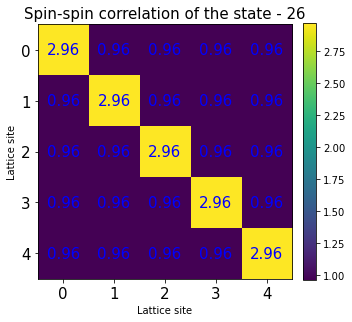

SYMMETRY a=0, b=0
Eigenstate:  27  - Eigenvalue:  6.0
     Spin-spin  0-0  (2.96+0j)
     Spin-spin  0-1  (0.96+0j)
     Spin-spin  0-2  (0.96+0j)
     Spin-spin  0-3  (0.96+0j)
     Spin-spin  0-4  (0.96+0j)
     Spin-spin  1-0  (0.96+0j)
     Spin-spin  1-1  (2.96+0j)
     Spin-spin  1-2  (0.96+0j)
     Spin-spin  1-3  (0.96+0j)
     Spin-spin  1-4  (0.96+0j)
     Spin-spin  2-0  (0.96+0j)
     Spin-spin  2-1  (0.96+0j)
     Spin-spin  2-2  (2.96+0j)
     Spin-spin  2-3  (0.96+0j)
     Spin-spin  2-4  (0.96+0j)
     Spin-spin  3-0  (0.96+0j)
     Spin-spin  3-1  (0.96+0j)
     Spin-spin  3-2  (0.96+0j)
     Spin-spin  3-3  (2.96+0j)
     Spin-spin  3-4  (0.96+0j)
     Spin-spin  4-0  (0.96+0j)
     Spin-spin  4-1  (0.96+0j)
     Spin-spin  4-2  (0.96+0j)
     Spin-spin  4-3  (0.96+0j)
     Spin-spin  4-4  (2.96+0j)


SYMMETRY a=0, b=0
Eigenstate:  28  - Eigenvalue:  6.0
     Spin-spin  0-0  (2+0j)
     Spin-spin  0-1  0j
     Spin-spin  0-2  0j
     Spin-spin  0-3  0j
     Spin-spin  0-4  0j
     Spin-spin  1-0  0j
     Spin-spin  1-1  (2+0j)
     Spin-spin  1-2  0j
     Spin-spin  1-3  0j
     Spin-spin  1-4  0j
     Spin-spin  2-0  0j
     Spin-spin  2-1  0j
     Spin-spin  2-2  (2+0j)
     Spin-spin  2-3  0j
     Spin-spin  2-4  0j
     Spin-spin  3-0  0j
     Spin-spin  3-1  0j
     Spin-spin  3-2  0j
     Spin-spin  3-3  (2+0j)
     Spin-spin  3-4  0j
     Spin-spin  4-0  0j
     Spin-spin  4-1  0j
     Spin-spin  4-2  0j
     Spin-spin  4-3  0j
     Spin-spin  4-4  (2+0j)


SYMMETRY a=0, b=0
Eigenstate:  29  - Eigenvalue:  6.0
     Spin-spin  0-0  (2.64+0j)
     Spin-spin  0-1  (0.64+0j)
     Spin-spin  0-2  (0.64+0j)
     Spin-spin  0-3  (0.64+0j)
     Spin-spin  0-4  (0.64+0j)
     Spin-spin  1-0  (0.64+0j)
     Spin-spin  1-1  (2.64+0j)
     Spin-spin  1-2  (0.64+0j)
     Spin-spin  1-3  (0.64+0j)
     Spin-spin  1-4  (0.64+0j)
     Spin-spin  2-0  (0.64+0j)
     Spin-spin  2-1  (0.64+0j)
     Spin-spin  2-2  (2.64+0j)
     Spin-spin  2-3  (0.64+0j)
     Spin-spin  2-4  (0.64+0j)
     Spin-spin  3-0  (0.64+0j)
     Spin-spin  3-1  (0.64+0j)
     Spin-spin  3-2  (0.64+0j)
     Spin-spin  3-3  (2.64+0j)
     Spin-spin  3-4  (0.64+0j)
     Spin-spin  4-0  (0.64+0j)
     Spin-spin  4-1  (0.64+0j)
     Spin-spin  4-2  (0.64+0j)
     Spin-spin  4-3  (0.64+0j)
     Spin-spin  4-4  (2.64+0j)


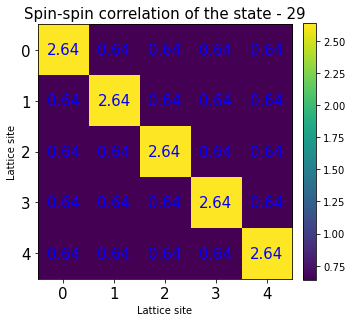

SYMMETRY a=0, b=0
Eigenstate:  30  - Eigenvalue:  6.0
     Spin-spin  0-0  (2.704341+0j)
     Spin-spin  0-1  (0.704341+0j)
     Spin-spin  0-2  (0.704341+0j)
     Spin-spin  0-3  (0.704341+0j)
     Spin-spin  0-4  (0.704341+0j)
     Spin-spin  1-0  (0.704341+0j)
     Spin-spin  1-1  (2.704341+0j)
     Spin-spin  1-2  (0.704341+0j)
     Spin-spin  1-3  (0.704341+0j)
     Spin-spin  1-4  (0.704341+0j)
     Spin-spin  2-0  (0.704341+0j)
     Spin-spin  2-1  (0.704341+0j)
     Spin-spin  2-2  (2.704341+0j)
     Spin-spin  2-3  (0.704341+0j)
     Spin-spin  2-4  (0.704341+0j)
     Spin-spin  3-0  (0.704341+0j)
     Spin-spin  3-1  (0.704341+0j)
     Spin-spin  3-2  (0.704341+0j)
     Spin-spin  3-3  (2.704341+0j)
     Spin-spin  3-4  (0.704341+0j)
     Spin-spin  4-0  (0.704341+0j)
     Spin-spin  4-1  (0.704341+0j)
     Spin-spin  4-2  (0.704341+0j)
     Spin-spin  4-3  (0.704341+0j)
     Spin-spin  4-4  (2.704341+0j)


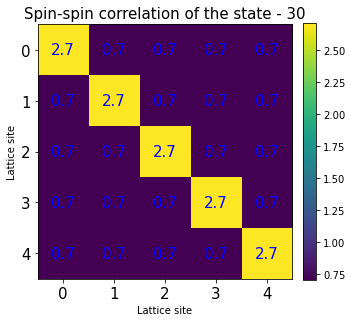

SYMMETRY a=0, b=0
Eigenstate:  31  - Eigenvalue:  6.0
     Spin-spin  0-0  (2.127317+0j)
     Spin-spin  0-1  (0.127317+0j)
     Spin-spin  0-2  (0.127317+0j)
     Spin-spin  0-3  (0.127317+0j)
     Spin-spin  0-4  (0.127317+0j)
     Spin-spin  1-0  (0.127317+0j)
     Spin-spin  1-1  (2.127317+0j)
     Spin-spin  1-2  (0.127317+0j)
     Spin-spin  1-3  (0.127317+0j)
     Spin-spin  1-4  (0.127317+0j)
     Spin-spin  2-0  (0.127317+0j)
     Spin-spin  2-1  (0.127317+0j)
     Spin-spin  2-2  (2.127317+0j)
     Spin-spin  2-3  (0.127317+0j)
     Spin-spin  2-4  (0.127317+0j)
     Spin-spin  3-0  (0.127317+0j)
     Spin-spin  3-1  (0.127317+0j)
     Spin-spin  3-2  (0.127317+0j)
     Spin-spin  3-3  (2.127317+0j)
     Spin-spin  3-4  (0.127317+0j)
     Spin-spin  4-0  (0.127317+0j)
     Spin-spin  4-1  (0.127317+0j)
     Spin-spin  4-2  (0.127317+0j)
     Spin-spin  4-3  (0.127317+0j)
     Spin-spin  4-4  (2.127317+0j)


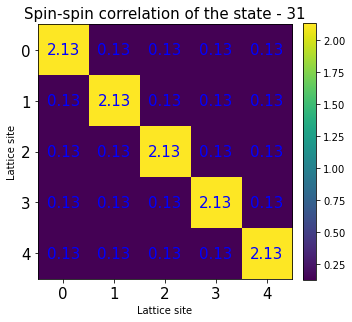

In [83]:
for jv,vec in enumerate(H_eigv_sym):
        
        if jv<6:
            print("SYMMETRY a=1, b=1")
        if 6<=jv<12:
            print("SYMMETRY a=1, b=0")
        if 12<=jv<18:
            print("SYMMETRY a=0, b=1")
        if jv>=18:
            print("SYMMETRY a=0, b=0")
        print("Eigenstate: ",jv," - Eigenvalue: ",e_tot[jv])
        
        val=[]
        for el in spins_mat:
            val.append(np.dot(np.dot(np.conjugate(vec),el),vec))
        val2=[]
        for el in spin_spin_mat:
            val2.append(np.dot(np.dot(np.conjugate(vec),el),vec))
        
        ss=[0]*(nqubit*nqubit)
        s=[0]*(nqubit*nqubit)
        M=np.zeros((nqubit,nqubit))
    
        n=0
        p=0
        for j in range(nqubit):
            for k in range(nqubit):
                sj=0
                sk=0
                for l in range(3):
                    ss[p] += val2[n]
                    sj+=val[3*j+l]**2
                    sk+=val[3*k+l]**2
                    n += 1
                
                s[p]=pow(sj,0.5)*pow(sk,0.5)
                M[j,k]=ss[p]-s[p]
                print("     Spin-spin ",str(j)+"-"+str(k)+" ",round(ss[p]-s[p],6))
                p+=1

        #Here we create a visual representation of the spin-spin correlation values
        fig, ax = plt.subplots(figsize=(5,10))
        im = ax.imshow(M)
        
        ax.set_xticks(np.arange(nqubit))
        ax.set_yticks(np.arange(nqubit))
        ax.set_xticklabels(np.arange(nqubit), fontsize=15)
        ax.set_yticklabels(np.arange(nqubit), fontsize=15)

        ax.set_xlabel("Lattice site")
        ax.set_ylabel("Lattice site")
        
        fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04)

        for ii in range(nqubit):
            for jj in range(nqubit):
                text = ax.text(jj, ii, round(M[ii, jj],2),
                               ha="center", va="center", color="b", fontsize=15)

        ax.set_title("Spin-spin correlation of the state - "+str(jv), fontsize=15)
        fig.tight_layout()
        plt.show()

# Simultaneous eigenstates of $H$, $R_v$, $R_h$ and $X^{\otimes 5}$

## Symmetry operator: $X^{\otimes 5}=X_0X_1X_2X_3X_4$

This symmetry operator is equal to its adjoint. It acts on the spin operators by this way:

$$X^{\otimes 5}X_iX^{\otimes 5}=X_i \quad X^{\otimes 5}Y_iX^{\otimes 5}=-Y_i \quad X^{\otimes 5}Z_iX^{\otimes 5}=-Z_i$$

In [84]:
X5=PauliOp(generate_pauli(np.arange(nqubit),[],nqubit))
print(X5)
mat_X5=X5.to_matrix()
#print(mat_X5)

XXXXX


#### Eigenvalues of $X^{\otimes 5}$

We will refer to the eigenvalues of $X^{\otimes 5}$ with $(-1)^c$ where $c=0,1$.

In [85]:
sigmaX5,_=LA.eigh(mat_X5)
print("Eigenvalues of XXXXX:")
print(sigmaX5)

Eigenvalues of XXXXX:
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


#### $[H,X^{\otimes 5}]=0$

In [86]:
if np.all(np.dot(mat_H,mat_X5)==np.dot(mat_X5,mat_H)):
    print("H and XXXXX commute!")
else:
    print("H and XXXXX don't commute!")

H and XXXXX commute!


#### $[R_v,X^{\otimes 5}]=0$

In [87]:
if np.all(np.dot(Rv,mat_X5)==np.dot(mat_X5,Rv)):
    print("Rv and XXXXX commute!")
else:
    print("Rv and XXXXX don't commute!")

Rv and XXXXX commute!


#### $[R_h,X^{\otimes 5}]=0$

In [88]:
if np.all(np.dot(Rv,mat_X5)==np.dot(mat_X5,Rv)):
    print("Rh and XXXXX commute!")
else:
    print("Rh and XXXXX don't commute!")

Rh and XXXXX commute!


Therefore $H$, $R_v$, $R_h$ and $X^{\otimes 5}$ share a complete set of common eigenstates.

## Finding the common eigenstates

We diagonalize $X^{\otimes 5}$ on symmetry operator $R_v$ eigenspaces by calculating: $U_v^{-1} X^{\otimes 5} U_v$.

$$
U_v^{-1} X^{\otimes 5} U_v =
\begin{pmatrix}
\chi_{a=1} & \mathbb{0} \\
\mathbb{0} & \chi_{a=0}
\end{pmatrix}
$$

In [89]:
X5_v=np.dot(LA.inv(Uv),np.dot(mat_X5,Uv))

#Diagonalization of the block matrices X5_{-1} and X5_{1} where +1/-1 refer to Rv

#Block of the matrix corresponding to eigenvalue -1 of Rv
X5_v1=np.zeros((12,12),dtype=np.complex_)
#Block of the matrix corresponding to eigenvalue 1 of Rv
X5_v2=np.zeros((20,20),dtype=np.complex_)

for i in range(12):
    for j in range(12):
        X5_v1[i,j]=X5_v[i,j]
for i in range(20):
    for j in range(20):
        X5_v2[i,j]=X5_v[12+i,12+j]
    
sigmaX5_v1,_=LA.eigh(X5_v1)
print("Eigenvalues of Chi_{a=1}")
print(sigmaX5_v1)
sigmaX5_v2,_=LA.eigh(X5_v2)
print("Eigenvalues of Chi_{a=0}")
print(sigmaX5_v2)

Eigenvalues of Chi_{a=1}
[-1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.]
Eigenvalues of Chi_{a=0}
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]


Now we calculate:

$$
\begin{pmatrix}
V_{h,a=1}^{-1}\chi_{a=1}V_{h,a=1} & \mathbb{0} \\
\mathbb{0} & V_{h,a=0}^{-1}\chi_{a=0}V_{h,a=0}
\end{pmatrix}=
\begin{pmatrix}
\chi_{a=1,b=1} & \mathbb{0} & \mathbb{0} & \mathbb{0}\\
\mathbb{0} & \chi_{a=1,b=0} & \mathbb{0} & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & \chi_{a=0,b=1}  & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & \mathbb{0} & \chi_{a=0,b=0}
\end{pmatrix}
$$

In [90]:
X5_vh1=np.dot(np.dot(LA.inv(Vh1),X5_v1),Vh1)
X5_vh2=np.dot(np.dot(LA.inv(Vh2),X5_v2),Vh2)

X5_11=np.zeros((6,6),dtype=np.complex_)
X5_10=np.zeros((6,6),dtype=np.complex_)
X5_01=np.zeros((6,6),dtype=np.complex_)
X5_00=np.zeros((14,14),dtype=np.complex_)

for i in range(6):
    for j in range(6):
        X5_11[i,j]=X5_vh1[i,j]
        
for i in range(6):
    for j in range(6):
        X5_10[i,j]=X5_vh1[6+i,6+j]
        
for i in range(6):
    for j in range(6):
        X5_01[i,j]=X5_vh2[i,j]

for i in range(14):
    for j in range(14):
        X5_00[i,j]=X5_vh2[6+i,6+j]

sigmaX5_11,_=LA.eigh(X5_11)
print("Eigenvalues of Chi_{a=1,b=1}")
print(sigmaX5_11)
sigmaX5_10,_=LA.eigh(X5_10)
print("Eigenvalues of Chi_{a=1,b=0}")
print(sigmaX5_10)
sigmaX5_01,_=LA.eigh(X5_01)
print("Eigenvalues of Chi_{a=0,b=1}")
print(sigmaX5_01)
sigmaX5_00,_=LA.eigh(X5_00)
print("Eigenvalues of Chi_{a=0,b=0}")
print(sigmaX5_00)

Eigenvalues of Chi_{a=1,b=1}
[-1. -1. -1.  1.  1.  1.]
Eigenvalues of Chi_{a=1,b=0}
[-1. -1. -1.  1.  1.  1.]
Eigenvalues of Chi_{a=0,b=1}
[-1. -1. -1.  1.  1.  1.]
Eigenvalues of Chi_{a=0,b=0}
[-1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.]


We find the matrix $W_{a,b}$ that diagonalizes each block $\chi_{a,b}$. Then we evaluate the matrix product $W_{a,b}^{-1}H_{a,b}W_{a,b}=H_{a,b,c}$ on each block $H_{a,b}$, namely:

$$
\begin{pmatrix}
W_{1,1}^{-1}H_{a=1,b=1}W_{1,1} & \mathbb{0} & \mathbb{0} & \mathbb{0}\\
\mathbb{0} & W_{1,0}^{-1}H_{a=1,b=0}W_{1,0} & \mathbb{0} & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & W_{0,1}^{-1}H_{a=0,b=1}W_{0,1}  & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & \mathbb{0} & W_{0,0}^{-1}H_{a=0,b=0}W_{0,0}
\end{pmatrix}=
\begin{pmatrix}
H_{1,1,1} & \mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0}\\
\mathbb{0} & H_{1,1,0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & H_{1,0,1} & \mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & \mathbb{0} & H_{1,0,0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & H_{0,1,1} & \mathbb{0} & \mathbb{0} & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & H_{0,1,0} & \mathbb{0} & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & H_{0,0,1} & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & \mathbb{0} & H_{0,0,0}
\end{pmatrix}
$$

where each $H_{a,b,c}$ has dimension $3 \times 3$ except for $H_{0,0,1}$ and $H_{0,0,0}$ which have dimension $7 \times 7$.

In [91]:
_,W11=LA.eigh(X5_11)
_,W10=LA.eigh(X5_10)
_,W01=LA.eigh(X5_01)
_,W00=LA.eigh(X5_00)

mat_Hvhx1=np.dot(np.dot(LA.inv(W11),mat_H11),W11)
mat_Hvhx2=np.dot(np.dot(LA.inv(W10),mat_H10),W10)
mat_Hvhx3=np.dot(np.dot(LA.inv(W01),mat_H01),W01)
mat_Hvhx4=np.dot(np.dot(LA.inv(W00),mat_H00),W00)

mat_H111=np.zeros((3,3),dtype=np.complex_)
mat_H110=np.zeros((3,3),dtype=np.complex_)
mat_H101=np.zeros((3,3),dtype=np.complex_)
mat_H100=np.zeros((3,3),dtype=np.complex_)
mat_H011=np.zeros((3,3),dtype=np.complex_)
mat_H010=np.zeros((3,3),dtype=np.complex_)
mat_H001=np.zeros((7,7),dtype=np.complex_)
mat_H000=np.zeros((7,7),dtype=np.complex_)

for i in range(3):
    for j in range(3):
        mat_H111[i,j]=mat_Hvhx1[i,j]
for i in range(3):
    for j in range(3):
        mat_H110[i,j]=mat_Hvhx1[3+i,3+j]
for i in range(3):
    for j in range(3):
        mat_H101[i,j]=mat_Hvhx2[i,j]
for i in range(3):
    for j in range(3):
        mat_H100[i,j]=mat_Hvhx2[3+i,3+j]
for i in range(3):
    for j in range(3):
        mat_H011[i,j]=mat_Hvhx3[i,j]
for i in range(3):
    for j in range(3):
        mat_H010[i,j]=mat_Hvhx3[3+i,3+j]
for i in range(7):
    for j in range(7):
        mat_H001[i,j]=mat_Hvhx4[i,j]
for i in range(7):
    for j in range(7):
        mat_H000[i,j]=mat_Hvhx4[7+i,7+j]

In [92]:
e111,m111 = LA.eigh(mat_H111)
e110,m110 = LA.eigh(mat_H110)
e101,m101 = LA.eigh(mat_H101)
e100,m100 = LA.eigh(mat_H100)
e011,m011 = LA.eigh(mat_H011)
e010,m010 = LA.eigh(mat_H010)
e001,m001 = LA.eigh(mat_H001)
e000,m000 = LA.eigh(mat_H000)

print("Eigenvalues of H corresponding to a=1,b=1,c=1")
print(np.round(e111,2))
print("Eigenvalues of H corresponding to a=1,b=1,c=0")
print(np.round(e110,2))
print("Eigenvalues of H corresponding to a=1,b=0,c=1")
print(np.round(e101,2))
print("Eigenvalues of H corresponding to a=1,b=0,c=0")
print(np.round(e101,2))
print("Eigenvalues of H corresponding to a=0,b=1,c=1")
print(np.round(e011,2))
print("Eigenvalues of H corresponding to a=0,b=1,c=0")
print(np.round(e010,2))
print("Eigenvalues of H corresponding to a=0,b=0,c=1")
print(np.round(e001,2))
print("Eigenvalues of H corresponding to a=0,b=0,c=0")
print(np.round(e000,2))


print("Eigenvalues by order")
e_tot=np.round(np.concatenate((e111,e110,e101,e100,e011,e010,e001,e000),axis=0),2)
print(e_tot)

Eigenvalues of H corresponding to a=1,b=1,c=1
[-6. -0.  0.]
Eigenvalues of H corresponding to a=1,b=1,c=0
[-6. -0.  0.]
Eigenvalues of H corresponding to a=1,b=0,c=1
[-2.  4.  4.]
Eigenvalues of H corresponding to a=1,b=0,c=0
[-2.  4.  4.]
Eigenvalues of H corresponding to a=0,b=1,c=1
[-6. -0. -0.]
Eigenvalues of H corresponding to a=0,b=1,c=0
[-6. -0. -0.]
Eigenvalues of H corresponding to a=0,b=0,c=1
[-6. -4. -4.  2.  6.  6.  6.]
Eigenvalues of H corresponding to a=0,b=0,c=0
[-6. -4. -4.  2.  6.  6.  6.]
Eigenvalues by order
[-6. -0.  0. -6. -0.  0. -2.  4.  4. -2.  4.  4. -6. -0. -0. -6. -0. -0.
 -6. -4. -4.  2.  6.  6.  6. -6. -4. -4.  2.  6.  6.  6.]


## The sectors representation

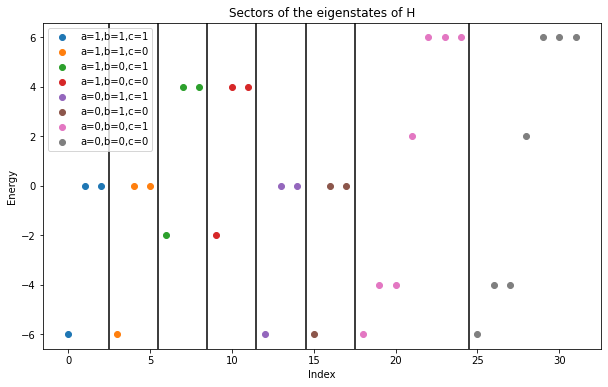

In [93]:
sect=np.array((e111,e110,e101,e100,e011,e010,e001,e000))

plt.figure(figsize=(10,6))
for i,s in enumerate(sect):
   
    if i==0:
        text="a=1,b=1,c=1"
        plt.scatter(range(0,3),s,label=text)
        plt.axvline(3-0.5,c='black')
    if i==1:
        text="a=1,b=1,c=0"
        plt.scatter(range(3,6),s,label=text)
        plt.axvline(6-0.5,c='black')
    if i==2:
        text="a=1,b=0,c=1"
        plt.scatter(range(6,9),s,label=text)
        plt.axvline(9-0.5,c='black')
    if i==3:
        text="a=1,b=0,c=0"
        plt.scatter(range(9,12),s,label=text)
        plt.axvline(12-0.5,c='black')
    if i==4:
        text="a=0,b=1,c=1"
        plt.scatter(range(12,15),s,label=text)
        plt.axvline(15-0.5,c='black')
    if i==5:
        text="a=0,b=1,c=0"
        plt.scatter(range(15,18),s,label=text)
        plt.axvline(18-0.5,c='black')
    if i==6:
        text="a=0,b=0,c=1"
        plt.scatter(range(18,25),s,label=text)
        plt.axvline(25-0.5,c='black')
    if i==7:
        text="a=0,b=0,c=0"
        plt.scatter(range(25,32),s,label=text)

plt.xlabel('Index')
plt.ylabel('Energy')
plt.title("Sectors of the eigenstates of H")
plt.legend()
plt.show()

## Rotation operator on the centre point: $R_c=R_vR_h$

The rotation $R_c$ of $\frac{2}{3}\pi$ on site $2$ can be described with the following actions of the reflections on h-axis and v-axis, therefore we already know that $R_c=R_vR_h$ commutes with $H$, $R_v$ and $R_h$. We will refer to the eigenvalues of $R_c$ with $(-1)^c$ with $c=0,1$.

In [94]:
Rc=np.dot(Rv,Rh)

sigmaR2,_=LA.eigh(Rc)
print("Eigenvalues of Rc:")
print(sigmaR2)

Eigenvalues of Rc:
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


### Simultaneous eigenvectors of $H$, $R_v$, $R_h$ and $R_vR_h$

We diagonalize $R_c$ on symmetry operator $R_v$ eigenspaces by calculating: $U_v^{-1} R_c U_v$.

$$
U_v^{-1} R_c U_v =
\begin{pmatrix}
\Omega_{a=1} & \mathbb{0} \\
\mathbb{0} & \Omega_{a=0}
\end{pmatrix}
$$

$\Omega_{a=1}$ has dimension $12 \times 12$, $\Omega_{a=0}$ has dimension $20 \times 20$.

In [95]:
Rc_v=np.dot(LA.inv(Uv),np.dot(Rc,Uv))

#Diagonalization of the block matrices Rc_{-1} and Rc_{1} where +1/-1 refer to Rv

#Block of the matrix corresponding to eigenvalue -1 of Rv
Rc_v1=np.zeros((12,12),dtype=np.complex_)
#Block of the matrix corresponding to eigenvalue 1 of Rv
Rc_v2=np.zeros((20,20),dtype=np.complex_)

for i in range(12):
    for j in range(12):
        Rc_v1[i,j]=Rc_v[i,j]
for i in range(20):
    for j in range(20):
        Rc_v2[i,j]=Rc_v[12+i,12+j]
        
sigmaRc_v1,_=LA.eigh(Rc_v1)
print("Eigenvalues of Omega_{a=1}")
print(sigmaRc_v1)
sigmaRc_v2,_=LA.eigh(Rc_v2)
print("Eigenvalues of Omega_{a=0}")
print(sigmaRc_v2)

Eigenvalues of Omega_{a=1}
[-1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.]
Eigenvalues of Omega_{a=0}
[-1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]


Now we calculate:

$$
\begin{pmatrix}
V_{h,a=1}^{-1}\Omega_{a=1}V_{h,a=1} & \mathbb{0} \\
\mathbb{0} & V_{h,a=0}^{-1}\Omega_{a=0}V_{h,a=0}
\end{pmatrix}=
\begin{pmatrix}
\Omega_{a=1,b=1} & \mathbb{0} & \mathbb{0} & \mathbb{0}\\
\mathbb{0} & \Omega_{a=1,b=0} & \mathbb{0} & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & \Omega_{a=0,b=1}  & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & \mathbb{0} & \Omega_{a=0,b=0}
\end{pmatrix}
$$

For each $a,b$ $\Omega_{a,b}$ has dimension $6 \times 6$ except for $\Omega_{a=0,b=0}$ which has dimension $14 \times 14$.

In [96]:
Rc_vh1=np.dot(np.dot(LA.inv(Vh1),Rc_v1),Vh1)
Rc_vh2=np.dot(np.dot(LA.inv(Vh2),Rc_v2),Vh2)

Rc_11=np.zeros((6,6),dtype=np.complex_)
Rc_10=np.zeros((6,6),dtype=np.complex_)
Rc_01=np.zeros((6,6),dtype=np.complex_)
Rc_00=np.zeros((14,14),dtype=np.complex_)

for i in range(6):
    for j in range(6):
        Rc_11[i,j]=Rc_vh1[i,j]
        
for i in range(6):
    for j in range(6):
        Rc_10[i,j]=Rc_vh1[6+i,6+j]
        
for i in range(6):
    for j in range(6):
        Rc_01[i,j]=Rc_vh2[i,j]

for i in range(14):
    for j in range(14):
        Rc_00[i,j]=Rc_vh2[6+i,6+j]
        
sigmaRc_11,_=LA.eigh(Rc_11)
print("Eigenvalues of Omega_{a=1,b=1}")
print(sigmaRc_11)
sigmaRc_10,_=LA.eigh(Rc_10)
print("Eigenvalues of Omega_{a=1,b=0}")
print(sigmaRc_10)
sigmaRc_01,_=LA.eigh(Rc_01)
print("Eigenvalues of Omega_{a=0,b=1}")
print(sigmaRc_01)
sigmaRc_00,_=LA.eigh(Rc_00)
print("Eigenvalues of Omega_{a=0,b=0}")
print(sigmaRc_00)

Eigenvalues of Omega_{a=1,b=1}
[1. 1. 1. 1. 1. 1.]
Eigenvalues of Omega_{a=1,b=0}
[-1. -1. -1. -1. -1. -1.]
Eigenvalues of Omega_{a=0,b=1}
[-1. -1. -1. -1. -1. -1.]
Eigenvalues of Omega_{a=0,b=0}
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


**Warning:** Using $U_v$ and $V_h$ we obtain that $\Omega_{a,b}$ is already diagonalized for each $a,b$.

# Spin operators: $S^2$ and $S_z$

### Total spin component  $S_z$

In [34]:
sz=[]
for i in range (nqubit):
    sz.append((1.0,generate_pauli([],[i],nqubit)))
sz=WeightedPauliOperator(sz)
print("Sz operator")
print(sz.print_details())
mat_sz=op_converter.to_matrix_operator(sz).dense_matrix
print("Sz operator matrix")
print(mat_sz)

Sz operator
IIIIZ	(1+0j)
IIIZI	(1+0j)
IIZII	(1+0j)
IZIII	(1+0j)
ZIIII	(1+0j)

Sz operator matrix
[[ 5.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  3.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  3.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ... -3.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j -3.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j -5.+0.j]]


#### $[H,S_z]=0$

In [35]:
if np.all(np.dot(mat_H,mat_sz)==np.dot(mat_sz,mat_H)):
    print("H and Sz commute!")
else:
    print("H and Sz don't commute!")

H and Sz commute!


## Total spin $S^2$

The square total spin is given by:

$$ S^2=(\sum_{i=0}^4 S_i)^2=\begin{pmatrix}
\sum_{i=0}^4 X_i \\
\sum_{i=0}^4 Y_i \\
\sum_{i=0}^4 Z_i
\end{pmatrix}^2$$

where $S_i$ is:

$$ S_i=\begin{pmatrix}
X_i \\
Y_i \\
Z_i
\end{pmatrix}
$$

In [36]:
sx=[]
for i in range (nqubit):
    sx.append((1.0,generate_pauli([i],[],nqubit)))
sx=WeightedPauliOperator(sx)
print("Sx operator")
print(sx.print_details())
mat_sx=op_converter.to_matrix_operator(sx).dense_matrix
#print("Sx operator matrix")
#print(mat_sx)

sy=[]
for i in range (nqubit):
    sy.append((1.0,generate_pauli([i],[i],nqubit)))
sy=WeightedPauliOperator(sy)
print("Sy operator")
print(sy.print_details())
mat_sy=op_converter.to_matrix_operator(sy).dense_matrix
#print("Sy operator matrix")
#print(mat_sy)

s2=np.dot(sx,sx)+np.dot(sy,sy)+np.dot(sz,sz)
print("S2 operator")
print(s2.print_details())
mat_s2=op_converter.to_matrix_operator(s2).dense_matrix
print("S2 operator matrix")
print(mat_s2)

Sx operator
IIIIX	(1+0j)
IIIXI	(1+0j)
IIXII	(1+0j)
IXIII	(1+0j)
XIIII	(1+0j)

Sy operator
IIIIY	(1+0j)
IIIYI	(1+0j)
IIYII	(1+0j)
IYIII	(1+0j)
YIIII	(1+0j)

S2 operator
IIIII	(15+0j)
IIIXX	(2+0j)
IIXIX	(2+0j)
IXIIX	(2+0j)
XIIIX	(2+0j)
IIXXI	(2+0j)
IXIXI	(2+0j)
XIIXI	(2+0j)
IXXII	(2+0j)
XIXII	(2+0j)
XXIII	(2+0j)
IIIYY	(2+0j)
IIYIY	(2+0j)
IYIIY	(2+0j)
YIIIY	(2+0j)
IIYYI	(2+0j)
IYIYI	(2+0j)
YIIYI	(2+0j)
IYYII	(2+0j)
YIYII	(2+0j)
YYIII	(2+0j)
IIIZZ	(2+0j)
IIZIZ	(2+0j)
IZIIZ	(2+0j)
ZIIIZ	(2+0j)
IIZZI	(2+0j)
IZIZI	(2+0j)
ZIIZI	(2+0j)
IZZII	(2+0j)
ZIZII	(2+0j)
ZZIII	(2+0j)

S2 operator matrix
[[35.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j 19.+0.j  4.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  4.+0.j 19.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ... 19.+0.j  4.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  4.+0.j 19.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j  0.+0.j 35.+0.j]]


#### $[H,S^2]=0$

In [37]:
if np.all(np.dot(mat_H,mat_s2)==np.dot(mat_s2,mat_H)):
    print("H and S2 commute!")
else:
    print("H and S2 don't commute!")

H and S2 commute!


#### $[S^2,S_z]=0$

In [38]:
if np.all(np.dot(mat_sz,mat_s2)==np.dot(mat_s2,mat_sz)):
    print("Sz and S2 commute!")
else:
    print("Sz and S2 don't commute!")

Sz and S2 commute!


# Simultaneous eigenstates of $H$, $S^2$ and $S_z$

Since $[S^2,S_z]=0$ they have a common set of eigenstates, usually indicated as $|s,s_z\rangle$, and it's possible to write the following eigenvalue equations:

$$S^2|s,s_z\rangle=\hbar^2 s(s+1)|s,s_z\rangle \quad S_z|s,s_z\rangle = \hbar s_z|s,s_z\rangle$$

where in general $s$ is a non-negative integer or half-integer value in $\{0,\frac{1}{2},\frac{3}{2}, ...\}$ and $s_z$ has values $\{-s, -s+1, ..., s-1,s\}$, namely assumes $2s+1$ values. In our case we are dealing with spin-$\frac{1}{2}$ and we have a $5$-sites lattice. We have that $s_z$ can assume only values in $\{-\frac{5}{2},-\frac{3}{2},-\frac{1}{2},\frac{1}{2},\frac{3}{2},\frac{5}{2}\}$ which can be associated to $s$ in $\{\frac{1}{2},\frac{3}{2},\frac{5}{2}\}$. Therefore we expect that $s(s+1) \in \{\frac{3}{4},\frac{15}{4},\frac{35}{4}\}$. 

We remind that our total Hamiltonian is not divided by $2$, therefore we expect that the eigenvalues of $S^2$ and $S_z$ are $2s_z \in \{-5,-3,-1,1,3,5\}$ and $4s(s+1) \in \{3,15,35\}$ ($2s \in \{1,3,5\}$). In the following we will refer to $2s_z$ and $2s$ just with $s_z$ and $s$.

## Finding the common eigenstates

We know that $U_{S^2}$ and $U_{S_z}$ are the matrices that diagonalize the symmetry operators:

$$U_{S^2}^{-1}S^2U_{S^2}=D_{S^2} \quad U_{S_z}^{-1}S_z U_{S_z}=D_{S_z}$$

where $D_{S^2}$ and $D_{S_z}$ are the diagonal matrices with eigenvalues of $S^2$ and $S_z$, respectively. 

In [39]:
from scipy import linalg as LA

n = 2**5

# diagonalize symmetries
sigmas2,Us2 = LA.eigh(mat_s2)
sigmasz,Usz = LA.eigh(mat_sz)

print("Eigenvalues of S2: ",len(set([round(e,3) for e in sigmas2])))
print(sigmas2)
print("Eigenvalues of Sz: ", len(set([e for e in sigmasz])))
print(sigmasz)

# We can diagonalize the symmetries S2 and S< using Us2 and Usz
#print("Diagonalized symmetry S2")
#print(np.dot(np.dot(LA.inv(Us2),mat_s2),Us2))
#print("Diagonalized symmetry Sz")
#print(np.dot(np.dot(LA.inv(Usz),mat_sz),Usz))

Eigenvalues of S2:  3
[ 3.  3.  3.  3.  3.  3.  3.  3.  3.  3. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 35. 35. 35. 35. 35. 35.]
Eigenvalues of Sz:  6
[-5. -3. -3. -3. -3. -3. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  3.  3.  3.  3.  3.  5.]


We want to diagonalize $H$ on the symmetry operator $S^2$ eigenspaces by making the following operation: $U_{S^2}^{-1} H U_{S^2}$. We will obtain a block matrix with $3$ blocks, $H_{s}$, where $s \in \{1,3,5\}$. $H_{s=1}$ is of dimension $10 \times 10$; $H_{s=3}$ is $16 \times 16$; $H_{s=5}$ are $6 \times 6$.

$$
U_{S^2}^{-1} H U_{S^2} =
\begin{pmatrix}
H_{s=1} & \mathbb{0} & \mathbb{0}  \\
\mathbb{0} & H_{s=3} & \mathbb{0}  \\
\mathbb{0} & \mathbb{0} & H_{s=5}  
\end{pmatrix}
$$

In [40]:
mat_Hs2=np.dot(np.dot(LA.inv(Us2),mat_H),Us2)

#Diagonalization of the blocks matrices

#Matrices corresponding to eigenvalues of Sz
mat_Hs21=np.zeros((10,10),dtype=np.complex_)
mat_Hs22=np.zeros((16,16),dtype=np.complex_)
mat_Hs23=np.zeros((6,6),dtype=np.complex_)

for i in range(10):
    for j in range(10):
        mat_Hs21[i,j]=mat_Hs2[i,j]

for i in range(16):
    for j in range(16):
        mat_Hs22[i,j]=mat_Hs2[10+i,10+j]

for i in range(6):
    for j in range(6):
        mat_Hs23[i,j]=mat_Hs2[26+i,26+j]


sigma_Hs21,_=LA.eigh(mat_Hs21)
sigma_Hs22,_=LA.eigh(mat_Hs22)
sigma_Hs23,_=LA.eigh(mat_Hs23)

print("Eigenvalues of H_{s=1}")
print(np.round(sigma_Hs21,2))
print("Eigenvalues of H_{s=3}")
print(np.round(sigma_Hs22,2))
print("Eigenvalues of H_{s=5}")
print(np.round(sigma_Hs23,2))

Eigenvalues of H_{s=1}
[-6. -6. -6. -6. -6. -6. -2. -2.  2.  2.]
Eigenvalues of H_{s=3}
[-4. -4. -4. -4. -0. -0. -0.  0.  0.  0.  0.  0.  4.  4.  4.  4.]
Eigenvalues of H_{s=5}
[6. 6. 6. 6. 6. 6.]


As we should expect, all the eigenvalues of $H$ corresponding to the most excited state (the ferromagnetic state) correspond to the eigenvalue with s=5 of $S^2$ and the ground state of $H$ (the anti-ferromagnetic one) is in the eigenspace with $s=1$.

Now we diagonalize $S_z$ on symmetry operator $S^2$ eigenspaces by calculating: $U_{S^2}^{-1} S_z U_{S^2}$.

$$
U_{S^2}^{-1} S_z U_{S^2} =
\begin{pmatrix}
S^z_{s=1} & \mathbb{0} & \mathbb{0} \\
\mathbb{0} & S^z_{s=3} & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & S^z_{s=5}  
\end{pmatrix}
$$

In [41]:
mat_sz2=np.dot(np.dot(LA.inv(Us2),mat_sz),Us2)
        
#Diagonalization of the blocks matrices

#Matrices corresponding to eigenvalues of S2
mat_sz21=np.zeros((10,10),dtype=np.complex_)
mat_sz22=np.zeros((16,16),dtype=np.complex_)
mat_sz23=np.zeros((6,6),dtype=np.complex_)

for i in range(10):
    for j in range(10):
        mat_sz21[i,j]=mat_sz2[i,j]

for i in range(16):
    for j in range(16):
        mat_sz22[i,j]=mat_sz2[10+i,10+j]

for i in range(6):
    for j in range(6):
        mat_sz23[i,j]=mat_sz2[26+i,26+j]

sigma_sz21,_=LA.eigh(mat_sz21)
sigma_sz22,_=LA.eigh(mat_sz22)
sigma_sz23,_=LA.eigh(mat_sz23)
print("Eigenvalues of S^z_{s=1}")
print(np.round(sigma_sz21,2))
print("Eigenvalues of S^z_{s=3}")
print(np.round(sigma_sz22,2))
print("Eigenvalues of S^z_{s=5}")
print(np.round(sigma_sz23,2))

Eigenvalues of S^z_{s=1}
[-1. -1. -1. -1. -1.  1.  1.  1.  1.  1.]
Eigenvalues of S^z_{s=3}
[-3. -3. -3. -3. -1. -1. -1. -1.  1.  1.  1.  1.  3.  3.  3.  3.]
Eigenvalues of S^z_{s=5}
[-5. -3. -1.  1.  3.  5.]


Firstly we find the matrices $V_{s}$ with $s \in \{1,3,5\}$ that diagonalize each block of the latter matrix $U_{S^2}^{-1} S_z U_{S^2}$, $S^z_{s}$. Then we use $V_{s}$ on each of the $3$ blocks of $U_{S^2}^{-1} H U_{S^2}$, $H_{s}$. We will obtain a matrix composed by $12$ blocks, $H_{s,sz}$. 
$H_{s=1,s_z}$ with $s_z \in \{-1,1\}$ are of dimension $5 \times 5$, $H_{s=3,s_z}$ with $s_z \in \{-3,-1,1,3\}$ are  $4 \times 4$ and $H_{s=5,s_z}$ with $s_z \in \{-5,-3,-1,1,3,5\}$ are  $1 \times 1$. We diagonalize each block of the following matrix.

$$
\begin{pmatrix}
V_{s=1}^{-1}H_{s=1}V_{s=1} & \mathbb{0} & \mathbb{0} \\
\mathbb{0} & V_{s=3}^{-1}H_{s=3}V_{s=3} & \mathbb{0} \\
\mathbb{0} & \mathbb{0} & V_{s=5}^{-1}H_{s=5}V_{s=5}\\
\end{pmatrix}
$$

In [42]:
_,Vs1 = LA.eigh(mat_sz21)
_,Vs2 = LA.eigh(mat_sz22)
_,Vs3 = LA.eigh(mat_sz23)

mat_Hs2z1=np.dot(np.dot(LA.inv(Vs1),mat_Hs21),Vs1)
mat_Hs2z2=np.dot(np.dot(LA.inv(Vs2),mat_Hs22),Vs2)
mat_Hs2z3=np.dot(np.dot(LA.inv(Vs3),mat_Hs23),Vs3)

mat_H1,mat_H2=np.zeros((2,5,5),dtype=np.complex_)
mat_H3,mat_H4,mat_H5,mat_H6=np.zeros((4,4,4),dtype=np.complex_)
mat_H7,mat_H8,mat_H9,mat_H10,mat_H11,mat_H12=np.zeros((6,1,1),dtype=np.complex_)


for i in range(5):
    for j in range(5):
        mat_H1[i,j]=mat_Hs2z1[i,j]
        
for i in range(5):
    for j in range(5):
        mat_H2[i,j]=mat_Hs2z1[5+i,5+j]
        
for i in range(4):
    for j in range(4):
        mat_H3[i,j]=mat_Hs2z2[i,j]

for i in range(4):
    for j in range(4):
        mat_H4[i,j]=mat_Hs2z2[4+i,4+j]
        
for i in range(4):
    for j in range(4):
        mat_H5[i,j]=mat_Hs2z2[8+i,8+j]
        
for i in range(4):
    for j in range(4):
        mat_H6[i,j]=mat_Hs2z2[12+i,12+j]

mat_H7[0,0]=mat_Hs2z3[0,0]
mat_H8[0,0]=mat_Hs2z3[1,1]
mat_H9[0,0]=mat_Hs2z3[2,2]
mat_H10[0,0]=mat_Hs2z3[3,3]
mat_H11[0,0]=mat_Hs2z3[4,4]
mat_H12[0,0]=mat_Hs2z3[5,5]

Now we diagonalize each $H_{s,s_z}$.

In [47]:
e1,m1 = LA.eigh(mat_H1)
e2,m2 = LA.eigh(mat_H2)
e3,m3 = LA.eigh(mat_H3)
e4,m4 = LA.eigh(mat_H4)
e5,m5 = LA.eigh(mat_H5)
e6,m6 = LA.eigh(mat_H6)
e7=[mat_H7[0,0]]
e8=[mat_H8[0,0]]
e9=[mat_H9[0,0]]
e10=[mat_H10[0,0]]
e11=[mat_H11[0,0]]
e12=[mat_H12[0,0]]

print("Eigenvalues of H corresponding to s=1,sz=-1")
print(np.round(e1,2))
print("Eigenvalues of H corresponding to s=1,sz=1")
print(np.round(e2,2))
print("Eigenvalues of H corresponding to s=3,sz=-3")
print(np.round(e3,2))
print("Eigenvalues of H corresponding to s=3,sz=-1")
print(np.round(e4,2))
print("Eigenvalues of H corresponding to s=3,sz=1")
print(np.round(e5,2))
print("Eigenvalues of H corresponding to s=3,sz=3")
print(np.round(e6,2))
print("Eigenvalues of H corresponding to s=5,sz=-5")
print(np.round(e7,2))
print("Eigenvalues of H corresponding to s=5,sz=-3")
print(np.round(e8,2))
print("Eigenvalues of H corresponding to s=5,sz=-1")
print(np.round(e9,2))
print("Eigenvalues of H corresponding to s=5,sz=1")
print(np.round(e10,2))
print("Eigenvalues of H corresponding to s=5,sz=3")
print(np.round(e11,2))
print("Eigenvalues of H corresponding to s=5,sz=5")
print(np.round(e12,2))

print("Eigenvalues by order")
e_tot=np.round(np.concatenate((e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12),axis=0),2)
print(e_tot)

Eigenvalues of H corresponding to s=1,sz=-1
[-6. -6. -6. -2.  2.]
Eigenvalues of H corresponding to s=1,sz=1
[-6. -6. -6. -2.  2.]
Eigenvalues of H corresponding to s=3,sz=-3
[-4. -0.  0.  4.]
Eigenvalues of H corresponding to s=3,sz=-1
[-4.  0.  0.  4.]
Eigenvalues of H corresponding to s=3,sz=1
[-4. -0.  0.  4.]
Eigenvalues of H corresponding to s=3,sz=3
[-4. -0.  0.  4.]
Eigenvalues of H corresponding to s=5,sz=-5
[6.+0.j]
Eigenvalues of H corresponding to s=5,sz=-3
[6.+0.j]
Eigenvalues of H corresponding to s=5,sz=-1
[6.+0.j]
Eigenvalues of H corresponding to s=5,sz=1
[6.+0.j]
Eigenvalues of H corresponding to s=5,sz=3
[6.+0.j]
Eigenvalues of H corresponding to s=5,sz=5
[6.+0.j]
Eigenvalues by order
[-6.+0.j -6.+0.j -6.+0.j -2.+0.j  2.+0.j -6.+0.j -6.+0.j -6.+0.j -2.+0.j
  2.+0.j -4.+0.j -0.+0.j  0.+0.j  4.+0.j -4.+0.j  0.+0.j  0.+0.j  4.+0.j
 -4.+0.j -0.+0.j  0.+0.j  4.+0.j -4.+0.j -0.+0.j  0.+0.j  4.+0.j  6.+0.j
  6.+0.j  6.+0.j  6.+0.j  6.+0.j  6.+0.j]


### The sectors representation

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


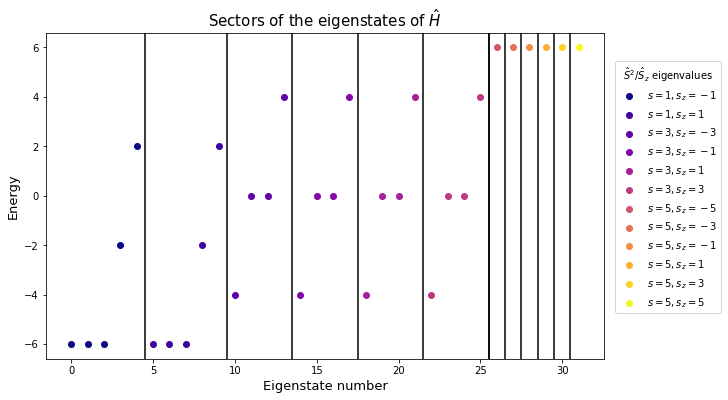

In [67]:
sect=np.array((e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12))
jet = plt.get_cmap('plasma')
colors = iter(jet(np.linspace(0,1,12)))
plt.figure(figsize=(10,6))
for i,s in enumerate(sect):
   
    if i==0:
        text=r"$s=1,s_z=-1$"
        plt.scatter(range(0,5),s,label=text,color=next(colors))
        plt.axvline(5-0.5,c='black')
    if i==1:
        text=r"$s=1,s_z=1$"
        plt.scatter(range(5,10),s,label=text,color=next(colors))
        plt.axvline(10-0.5,c='black')
    if i==2:
        text=r"$s=3,s_z=-3$"
        plt.scatter(range(10,14),s,label=text,color=next(colors))
        plt.axvline(14-0.5,c='black')
    if i==3:
        text=r"$s=3,s_z=-1$"
        plt.scatter(range(14,18),s,label=text,color=next(colors))
        plt.axvline(18-0.5,c='black')
    if i==4:
        text=r"$s=3,s_z=1$"
        plt.scatter(range(18,22),s,label=text,color=next(colors))
        plt.axvline(22-0.5,c='black')
    if i==5:
        text=r"$s=3,s_z=3$"
        plt.scatter(range(22,26),s,label=text,color=next(colors))
        plt.axvline(26-0.5,c='black')
    if i==6:
        text=r"$s=5,s_z=-5$"
        plt.scatter(26,s,label=text,color=next(colors))
        plt.axvline(26-0.5,c='black')
    if i==7:
        text=r"$s=5,s_z=-3$"
        plt.scatter(27,s,label=text,color=next(colors))
        plt.axvline(27-0.5,c='black')
    if i==8:
        text=r"$s=5,s_z=-1$"
        plt.scatter(28,s,label=text,color=next(colors))
        plt.axvline(28-0.5,c='black')
    if i==9:
        text=r"$s=5,s_z=1$"
        plt.scatter(29,s,label=text,color=next(colors))
        plt.axvline(29-0.5,c='black')
    if i==10:
        text=r"$s=5,s_z=3$"
        plt.scatter(30,s,label=text,color=next(colors))
        plt.axvline(30-0.5,c='black')
    if i==11:
        text=r"$s=5,s_z=5$"
        plt.scatter(31,s,label=text,color=next(colors))
        plt.axvline(31-0.5,c='black')

plt.xlabel('Eigenstate number',size=13)
plt.ylabel('Energy',size=13)
plt.title(r"Sectors of the eigenstates of $\hat{H}$",size=15)
plt.legend(title=r"$\hat{S}^2$/$\hat{S}_z$ eigenvalues",loc=(1.02,0.14))
#plt.show()
plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/H_eig_sec2.pdf",bbox_inches = 'tight')

As we can see, $S^2$ and $S_z$ don't solve the degeneracy of the ground state energy.

#### $[S^2,R_v]=0=[S^2,R_h]$

In [109]:
if np.all(np.dot(mat_s2,Rv)==np.dot(Rv,mat_s2)):
    print("S2 and Rv commute!")
else:
    print("S2 and Rv don't commute!")

S2 and Rv commute!


In [110]:
if np.all(np.dot(mat_s2,Rh)==np.dot(Rh,mat_s2)):
    print("S2 and Rh commute!")
else:
    print("S2 and Rh don't commute!")

S2 and Rh commute!


#### $[S_z,R_v]=0=[S_z,R_h]$

In [111]:
if np.all(np.dot(mat_sz,Rv)==np.dot(Rv,mat_sz)):
    print("Sz and Rv commute!")
else:
    print("Sz and Rv don't commute!")

Sz and Rv commute!


In [112]:
if np.all(np.dot(mat_sz,Rh)==np.dot(Rh,mat_sz)):
    print("Sz and Rh commute!")
else:
    print("Sz and Rh don't commute!")

Sz and Rh commute!


## Remarks

- Pauli representation of the symmetry operators $R_v$ and $R_h$

In [132]:
print("Rh symmetry operator as sum of Pauli operators")
print(MatrixOperator(Rh).to_opflow().to_pauli_op())
print("Rv symmetry operator as sum of Pauli operators")
print(MatrixOperator(Rv).to_opflow().to_pauli_op())

Rh symmetry operator as sum of Pauli operators
SummedOp([
  0.25 * IIIII,
  0.25 * IIIXX,
  0.25 * IIIYY,
  0.25 * IIIZZ,
  0.25 * XXIII,
  0.25 * XXIXX,
  0.25 * XXIYY,
  0.25 * XXIZZ,
  0.25 * YYIII,
  0.25 * YYIXX,
  0.25 * YYIYY,
  0.25 * YYIZZ,
  0.25 * ZZIII,
  0.25 * ZZIXX,
  0.25 * ZZIYY,
  0.25 * ZZIZZ
])
Rv symmetry operator as sum of Pauli operators
SummedOp([
  0.25 * IIIII,
  0.25 * IXIIX,
  0.25 * IYIIY,
  0.25 * IZIIZ,
  0.25 * XIIXI,
  0.25 * XXIXX,
  0.25 * XYIXY,
  0.25 * XZIXZ,
  0.25 * YIIYI,
  0.25 * YXIYX,
  0.25 * YYIYY,
  0.25 * YZIYZ,
  0.25 * ZIIZI,
  0.25 * ZXIZX,
  0.25 * ZYIZY,
  0.25 * ZZIZZ
])


- Are the spin vectors helpful to understand the symmetry?

  In other words, if we consider an eigenstate of $H$ anti-symmetrical with respect to a given axis, for instance, do we expect that the spin vectors are anti-symmetrical too?

We want to know if the spin operators commute with $R_v$ and $R_h$.

In [133]:
print("Do they commute?")
for i,m in enumerate(spins_mat):
    c1="No!"
    c2="No!"
    if np.all(np.dot(Rv,m)==np.dot(m,Rv)):
        c1="Yes!"
    if np.all(np.dot(Rh,m)==np.dot(m,Rh)):
        c2="Yes!"
    
    print("Rv - Spin",spins[i][0]," ",c1)
    print("Rh - Spin",spins[i][0]," ",c2)

Do they commute?
Rv - Spin 0x   No!
Rh - Spin 0x   No!
Rv - Spin 0y   No!
Rh - Spin 0y   No!
Rv - Spin 0z   No!
Rh - Spin 0z   No!
Rv - Spin 1x   No!
Rh - Spin 1x   No!
Rv - Spin 1y   No!
Rh - Spin 1y   No!
Rv - Spin 1z   No!
Rh - Spin 1z   No!
Rv - Spin 2x   Yes!
Rh - Spin 2x   Yes!
Rv - Spin 2y   Yes!
Rh - Spin 2y   Yes!
Rv - Spin 2z   Yes!
Rh - Spin 2z   Yes!
Rv - Spin 3x   No!
Rh - Spin 3x   No!
Rv - Spin 3y   No!
Rh - Spin 3y   No!
Rv - Spin 3z   No!
Rh - Spin 3z   No!
Rv - Spin 4x   No!
Rh - Spin 4x   No!
Rv - Spin 4y   No!
Rh - Spin 4y   No!
Rv - Spin 4z   No!
Rh - Spin 4z   No!


We want to make some symmetry considerations. We ask if exist couples of sites $(i,j)$ such that $R_v S_i^\alpha R_v= S_j^\alpha$ or $R_h S_i^\alpha R_h= S_j^\alpha$. In particular we want to check that:

$$\text{Horizontal axis)}\quad R_h S_0^{\alpha} R_h= S_1^{\alpha} \quad R_h S_3^\alpha R_h= S_4^\alpha \\ 
\text{Vertical axis)}\quad R_v S_0^{\alpha} R_v= S_3^{\alpha} \quad R_v S_1^\alpha R_v= S_4^\alpha$$

where $S_i^\alpha$ identifies a Pauli operator on site $i$ with component $\alpha=\{x,y,x\}$. 

In [134]:
ind1=0
ind2=1
for i in range(3):
    if np.all(np.dot(Rh,spins_mat[ind1*3+i])==np.dot(spins_mat[ind2*3+i],Rh)):
        print("Horizontal symmetry:",spins[ind1*3+i][0],"-",spins[ind2*3+i][0])
ind1=3
ind2=4
for i in range(3):
    if np.all(np.dot(Rh,spins_mat[ind1*3+i])==np.dot(spins_mat[ind2*3+i],Rh)):
        print("Horizontal symmetry:",spins[ind1*3+i][0],"-",spins[ind2*3+i][0])

ind1=0
ind2=3
for i in range(3):
    if np.all(np.dot(Rv,spins_mat[ind1*3+i])==np.dot(spins_mat[ind2*3+i],Rv)):
        print("Vertical symmetry:",spins[ind1*3+i][0],"-",spins[ind2*3+i][0])

ind1=1
ind2=4
for i in range(3):
    if np.all(np.dot(Rv,spins_mat[ind1*3+i])==np.dot(spins_mat[ind2*3+i],Rv)):
        print("Vertical symmetry:",spins[ind1*3+i][0],"-",spins[ind2*3+i][0])        

Horizontal symmetry: 0x - 1x
Horizontal symmetry: 0y - 1y
Horizontal symmetry: 0z - 1z
Horizontal symmetry: 3x - 4x
Horizontal symmetry: 3y - 4y
Horizontal symmetry: 3z - 4z
Vertical symmetry: 0x - 3x
Vertical symmetry: 0y - 3y
Vertical symmetry: 0z - 3z
Vertical symmetry: 1x - 4x
Vertical symmetry: 1y - 4y
Vertical symmetry: 1z - 4z


So, given an eigenstate of $H$ and $\Pi_{a,b}$ with eigenvalue $1$,$|\psi \rangle$, we infer that:

$$\langle\psi|\hat{S}_0|\psi \rangle=\langle\psi|\hat{S}_1|\psi \rangle=\langle\psi|\hat{S}_3|\psi \rangle=\langle\psi|\hat{S}_4|\psi \rangle$$

whatever $a$ and $b$ are because $R_v|\psi \rangle=(-1)^a|\psi \rangle$ and $R_h|\psi \rangle=(-1)^b|\psi \rangle$.

- Do the spin operators commute with the Hamiltonian $H$?

In [135]:
print("Do they commute?")
for i,m in enumerate(spins_mat):
    c1="No!"
    if np.all(np.dot(mat_H,m)==np.dot(m,mat_H)):
        c1="Yes!"
    print("H - Spin",spins[i][0]," ",c2)

Do they commute?
H - Spin 0x   No!
H - Spin 0y   No!
H - Spin 0z   No!
H - Spin 1x   No!
H - Spin 1y   No!
H - Spin 1z   No!
H - Spin 2x   No!
H - Spin 2y   No!
H - Spin 2z   No!
H - Spin 3x   No!
H - Spin 3y   No!
H - Spin 3z   No!
H - Spin 4x   No!
H - Spin 4y   No!
H - Spin 4z   No!


#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Useful stuff

- Spin flip operator 

### Spin flip $S_f$

We show some calculations in order to understand the shape of the spin-flip operator.

In [136]:
X=[[0,1],[1,0]]
Y=[[0,complex(0,-1)],[complex(0,1),0]]
Z=[[1,0],[0,-1]]

L=np.dot(1/np.sqrt(2),np.add(X,np.dot(-1,Z)))

v=[complex(1,2),complex(7,1)]
vXv=np.dot(v,np.dot(X,v))
vYv=np.dot(v,np.dot(Y,v))
vZv=np.dot(v,np.dot(Z,v))

s=np.sqrt(vXv**2+vYv**2+vZv**2)
print("Spin expected values on Pauli operators")
print(vXv," ",vYv," ",vZv," ",s)

print("Transformed Pauli matrices")
A=np.dot(np.conjugate(np.transpose(L)),np.dot(X,L))
B=np.dot(np.conjugate(np.transpose(L)),np.dot(Y,L))
C=np.dot(np.conjugate(np.transpose(L)),np.dot(Z,L))
print(A)
print(B)
print(C)

vAv=np.dot(v,np.dot(A,v))
vBv=np.dot(v,np.dot(B,v))
vCv=np.dot(v,np.dot(C,v))

s2=np.sqrt(vAv**2+vBv**2+vCv**2)
print("Spin expected values on transformed Pauli operators")
print(vAv," ",vBv," ",vCv," ",s2)

Spin expected values on Pauli operators
(10+30j)   0j   (-51-10j)   (45+18j)
Transformed Pauli matrices
[[-1.  0.]
 [ 0.  1.]]
[[0.-2.23711432e-17j 0.+1.00000000e+00j]
 [0.-1.00000000e+00j 0.+2.23711432e-17j]]
[[ 0. -1.]
 [-1.  0.]]
Spin expected values on transformed Pauli operators
(50.999999999999986+9.999999999999996j)   8.881784197001252e-16j   (-9.999999999999996-29.999999999999993j)   (44.999999999999986+17.999999999999996j)


The spin-flip operator allows to flip the spin expectation value. We create an operator with these features which transforms the Pauli operators $\{X_i,Y_i,Z_i\}$ on lattice site $i$ into $\{-Z_i,-Y_i,-X_i\}$. We call this operator $S$ and acts on the $j$-th qubit as $\frac{1}{\sqrt2}(X_j-Z_j)$.

In [137]:
spinflip_mat=np.kron(L,np.kron(np.kron(L,L),np.kron(L,L)))
spinflip=MatrixOperator(spinflip_mat).to_opflow().to_pauli_op()
#print(spinflip)

#### $[H,S]=0$

In [138]:
if np.all(np.dot(mat_H,spinflip_mat)==np.dot(spinflip_mat,mat_H)):
    print("H and S commute!")
else:
    print("H and S don't commute!")

H and S don't commute!


- We know show the spin direction of the eigenstates of $\Pi_{0,0}H\Pi_{0,0}$ and a **wrong** way to calculate the common eigenstates of $H$ and $\Pi_{0,0}$.

### Spin direction of the eigenstates of $\Pi_{0,0}H\Pi_{0,0}$

Given a set of eigenstates of $H$, $\{|\psi_{i}\rangle\}_{i=0}^{2^5-1}$, we can use the projector $\Pi_{a,b}$ on these states to find a new orthonormal basis for the eigenspace of the operators $R_v$ and $R_h$ with $(-1)^a$ and $(-1)^b$ as corresponding eigenvalues. In other words from the set $E_{a,b}=\{\Pi_{a,b}|\psi_i\rangle \}_{i=0}^{2^5-1}$ we can find an orthonormal set $\{|\phi_{i}^{ab}\rangle\}_{i=0}^{d(a,b)-1}$ such that $E_{a,b}=span\{|\phi_i^{ab}\rangle\}_{i=0}^{d(a,b)-1}$, where $d(a,b)$ is not necessarily equal to $2^5$.

By diagonalizing the operator $\Pi_{a,b}H\Pi_{a,b}$ we are loooking for eigenvectors of the original Hamiltonian $H$ which have the symmetry described by $\Pi_{a,b}$, namely states such as:

$$|\psi\rangle=\sum_{i=0}^{d(a,b)-1}c_i|\phi_i^{ab}\rangle$$

where $c_i$ are some specific coefficients.

Now we show the eigenvectors of our numerator operator, $\Pi_{0,0}H\Pi_{0,0}$.

In [219]:
#We remind that num_result[1] gives the eigenvectors
for i in range(len(num_result[1])):
    print("Energy: ",num_result[0][i])
    psi_i = num_result[1][i].primitive.to_dict()
    for k in psi_i.keys():
        print("     ",k,psi_i[k])

Energy:  -96.00000000000003
      00001 (2.6693241061758657e-18-3.6006150274525626e-35j)
      00010 (-5.511972527515517e-17-3.9808773537682216e-51j)
      00011 (-4.2555236811281895e-17-9.601640073206833e-35j)
      00100 (4.597907091150383e-19+3.3207176056338484e-53j)
      00101 (-1.8065133520157498e-16+1.15219680878482e-33j)
      00110 (5.4269586805496146e-17+3.840656029282733e-34j)
      00111 (-5.1922415355433494e-17-1.15219680878482e-33j)
      01000 (-1.124499919842204e-16-8.121405255319296e-51j)
      01001 (0.0381081224185468-2.493674160005392e-33j)
      01010 (-0.038108122418546816-9.876865976045284e-35j)
      01011 (-1.1854046868551766e-16-5.7609840439241e-34j)
      01100 (3.815434122939078e-17+1.9203280146413666e-34j)
      01101 (-0.49854565588893945+1.2002050091508565e-35j)
      01110 (0.49854565588893984+0j)
      01111 (-5.016991353140154e-17-1.7418278033915895e-49j)
      10000 (1.6781120705636707e-16+3.840656029282733e-34j)
      10001 (-0.03810812241854675-7.70

      10110 (-0.0027480549127186825+2.9375080736293563e-17j)
      10111 (-0.11420514717353647-4.269012233795191e-17j)
      11000 (-0.04703625150031846-2.2782336204905507e-16j)
      11001 (-0.23194815829865834+2.1080638323948184e-16j)
      11010 (-0.5241965329665835-7.437435522865935e-17j)
      11011 (-6.335769868777316e-18+3.046242263371311e-33j)
      11100 (0.04764479551354449+1.6495215194496251e-18j)
      11101 (-0.015077140214287417-1.1764996552108065e-16j)
      11110 (0.009362516446955033-4.9101804349634625e-18j)
Energy:  1.2015526998736088e-15
      00001 (0.05514575392287701-8.920169409464999e-18j)
      00010 (-0.2418780557707664+7.71885576600845e-18j)
      00011 (-0.05869629350577085+2.603726361780331e-18j)
      00100 (3.8123739077962305e-17-5.8124502197448775e-33j)
      00101 (0.19421195743520706-9.596370556291868e-18j)
      00110 (0.10706044899846415+1.4874994166227138e-17j)
      00111 (-0.27401421568872963-2.5702541201091858e-17j)
      01000 (0.0609614237479451

      00101 (3.1803148218951483e-34-0j)
      00110 (1.54638380369367e-35-0j)
      01000 (-3.924205969137294e-17+0j)
      01100 (1.546383803693691e-35-0j)
      01111 (-0.288675134594813+0j)
      10000 (-3.924205969137294e-17+0j)
      10100 (1.546383803693691e-35-0j)
      10111 (-0.288675134594813+0j)
      11000 (-2.4742140859099032e-34+0j)
      11011 (-1.5424968002886484e-16+0j)
      11101 (-0.288675134594813+0j)
      11110 (0.8660254037844385+0j)
Energy:  6.719512062330197e-15
      00001 (-0.013863870332896482-2.5844211219793824e-17j)
      00010 (-0.02865491401481155+9.236537601302542e-17j)
      00011 (0.13200831915995262+6.669612447872482e-17j)
      00100 (3.6912610056149884e-17+6.008634947626052e-32j)
      00101 (0.00971616718155197-3.4705389946424806e-17j)
      00110 (-0.018120423294928648-1.121310623408565e-16j)
      00111 (-0.055862380919689175+1.637251472686563e-16j)
      01000 (0.010578792394562416-8.330384360312654e-17j)
      01001 (-0.0446118177346504-2.708

Eigenstate number:  0 ; Energy:  -96.0
GROUND STATE -  0
     Spin  0x 0.0
     Spin  0y 0.0
     Spin  0z 0.0
     Spin  1x 0.0
     Spin  1y 0.0
     Spin  1z 0.0
     Spin  2x -0.151989
     Spin  2y 0.0
     Spin  2z -0.988382
     Spin  3x 0.0
     Spin  3y 0.0
     Spin  3z 0.0
     Spin  4x 0.0
     Spin  4y 0.0
     Spin  4z 0.0


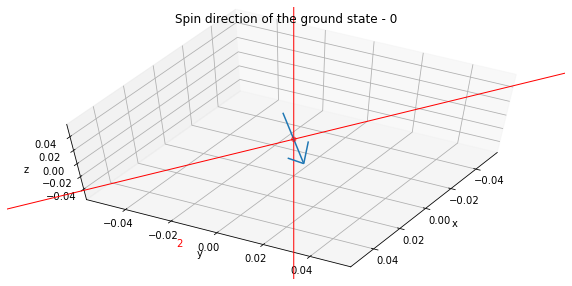

Eigenstate number:  1 ; Energy:  -96.0
GROUND STATE -  1
     Spin  0x 0.0
     Spin  0y 0.0
     Spin  0z 0.0
     Spin  1x 0.0
     Spin  1y 0.0
     Spin  1z 0.0
     Spin  2x 0.0
     Spin  2y 0.0
     Spin  2z 1.0
     Spin  3x 0.0
     Spin  3y 0.0
     Spin  3z 0.0
     Spin  4x 0.0
     Spin  4y 0.0
     Spin  4z 0.0


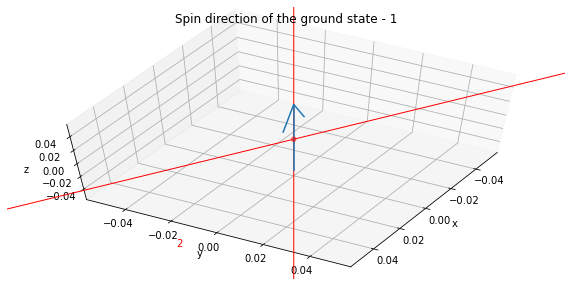

Eigenstate number:  2 ; Energy:  -64.0
     Spin  0x 0.0
     Spin  0y 0.0
     Spin  0z 0.779478
     Spin  1x 0.0
     Spin  1y 0.0
     Spin  1z 0.779478
     Spin  2x 0.0
     Spin  2y 0.0
     Spin  2z -0.519652
     Spin  3x 0.0
     Spin  3y 0.0
     Spin  3z 0.779478
     Spin  4x 0.0
     Spin  4y 0.0
     Spin  4z 0.779478


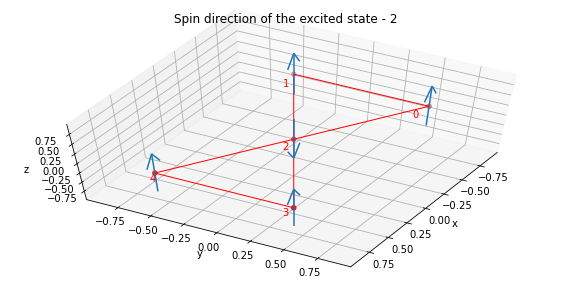

Eigenstate number:  3 ; Energy:  -64.0
     Spin  0x 0.01804
     Spin  0y 0.0
     Spin  0z -0.299778
     Spin  1x 0.01804
     Spin  1y 0.0
     Spin  1z -0.299778
     Spin  2x -0.012027
     Spin  2y 0.0
     Spin  2z 0.199852
     Spin  3x 0.01804
     Spin  3y 0.0
     Spin  3z -0.299778
     Spin  4x 0.01804
     Spin  4y 0.0
     Spin  4z -0.299778


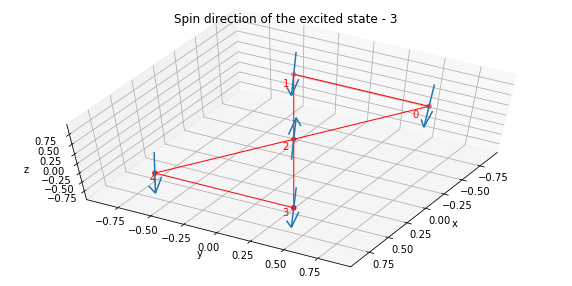

Eigenstate number:  4 ; Energy:  -64.0
     Spin  0x 0.0
     Spin  0y 0.0
     Spin  0z -0.9
     Spin  1x 0.0
     Spin  1y 0.0
     Spin  1z -0.9
     Spin  2x 0.0
     Spin  2y 0.0
     Spin  2z 0.6
     Spin  3x 0.0
     Spin  3y 0.0
     Spin  3z -0.9
     Spin  4x 0.0
     Spin  4y 0.0
     Spin  4z -0.9


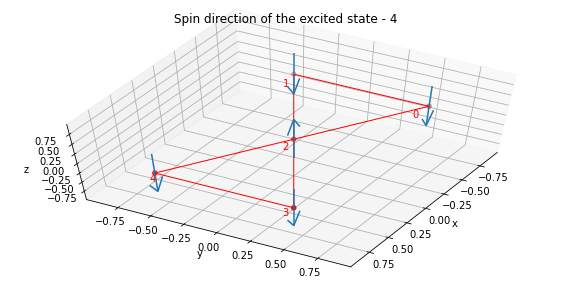

Eigenstate number:  5 ; Energy:  -64.0
     Spin  0x 0.124301
     Spin  0y 0.0
     Spin  0z 0.308512
     Spin  1x 0.124301
     Spin  1y 0.0
     Spin  1z 0.308512
     Spin  2x -0.082868
     Spin  2y 0.0
     Spin  2z -0.205674
     Spin  3x 0.124301
     Spin  3y 0.0
     Spin  3z 0.308512
     Spin  4x 0.124301
     Spin  4y 0.0
     Spin  4z 0.308512


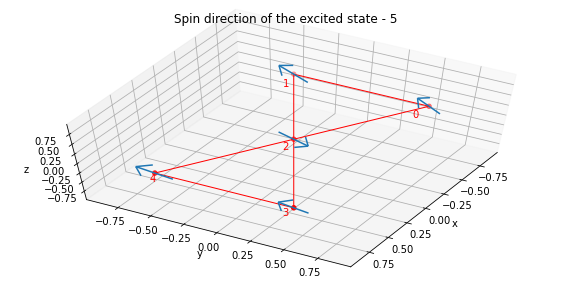

Eigenstate number:  6 ; Energy:  -0.0
     Spin  0x -0.043613
     Spin  0y 0.0
     Spin  0z 0.067478
     Spin  1x -0.261897
     Spin  1y 0.0
     Spin  1z -0.005519
     Spin  2x -0.18695
     Spin  2y 0.0
     Spin  2z -0.245537
     Spin  3x -0.00753
     Spin  3y 0.0
     Spin  3z 0.079539
     Spin  4x 0.067494
     Spin  4y 0.0
     Spin  4z 0.021739


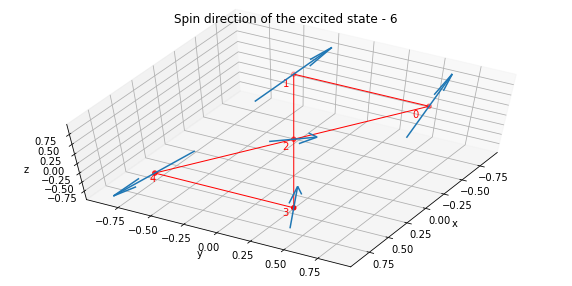

Eigenstate number:  7 ; Energy:  -0.0
     Spin  0x 0.160955
     Spin  0y 0.082218
     Spin  0z 0.048004
     Spin  1x 0.172994
     Spin  1y -0.090614
     Spin  1z 0.021721
     Spin  2x 0.579562
     Spin  2y 0.074352
     Spin  2z 0.588952
     Spin  3x 0.232869
     Spin  3y 0.173261
     Spin  3z 0.011071
     Spin  4x -0.195598
     Spin  4y -0.10739
     Spin  4z 0.020306


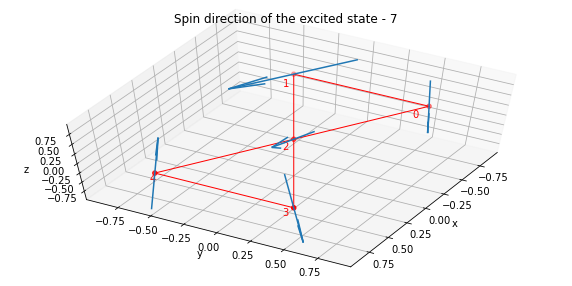

Eigenstate number:  8 ; Energy:  -0.0
     Spin  0x 0.160955
     Spin  0y -0.082218
     Spin  0z 0.048004
     Spin  1x 0.172994
     Spin  1y 0.090614
     Spin  1z 0.021721
     Spin  2x 0.579562
     Spin  2y -0.074352
     Spin  2z 0.588952
     Spin  3x 0.232869
     Spin  3y -0.173261
     Spin  3z 0.011071
     Spin  4x -0.195598
     Spin  4y 0.10739
     Spin  4z 0.020306


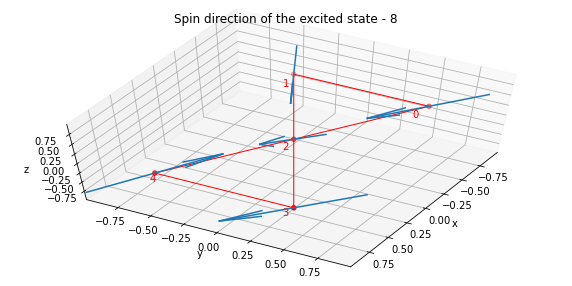

Eigenstate number:  9 ; Energy:  -0.0
     Spin  0x -0.214166
     Spin  0y -0.115229
     Spin  0z -0.14574
     Spin  1x -0.094053
     Spin  1y -0.003713
     Spin  1z -0.118293
     Spin  2x 0.099151
     Spin  2y -0.190315
     Spin  2z -0.470926
     Spin  3x -0.420082
     Spin  3y -0.134657
     Spin  3z 0.006532
     Spin  4x 0.145137
     Spin  4y 0.029503
     Spin  4z 0.134047


Eigenstate number:  10 ; Energy:  -0.0
     Spin  0x -0.214166
     Spin  0y 0.115229
     Spin  0z -0.14574
     Spin  1x -0.094053
     Spin  1y 0.003713
     Spin  1z -0.118293
     Spin  2x 0.099151
     Spin  2y 0.190315
     Spin  2z -0.470926
     Spin  3x -0.420082
     Spin  3y 0.134657
     Spin  3z 0.006532
     Spin  4x 0.145137
     Spin  4y -0.029503
     Spin  4z 0.134047


Eigenstate number:  11 ; Energy:  -0.0
     Spin  0x 0.246923
     Spin  0y 0.236781
     Spin  0z -0.432239
     Spin  1x 0.114387
     Spin  1y 0.084554
     Spin  1z -0.441584
     Spin  2x -0.284263
     Spin  2y 0.199908
     Spin  2z 0.29332
     Spin  3x -0.312685
     Spin  3y -0.089318
     Spin  3z 0.241528
     Spin  4x 0.441627
     Spin  4y 0.232017
     Spin  4z -0.398134


Eigenstate number:  12 ; Energy:  -0.0
     Spin  0x 0.246923
     Spin  0y -0.236781
     Spin  0z -0.432239
     Spin  1x 0.114387
     Spin  1y -0.084554
     Spin  1z -0.441584
     Spin  2x -0.284263
     Spin  2y -0.199908
     Spin  2z 0.29332
     Spin  3x -0.312685
     Spin  3y 0.089318
     Spin  3z 0.241528
     Spin  4x 0.441627
     Spin  4y -0.232017
     Spin  4z -0.398134


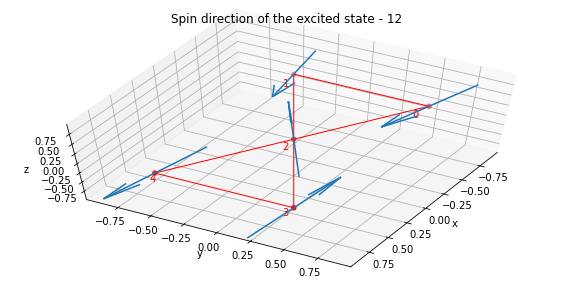

Eigenstate number:  13 ; Energy:  0.0
     Spin  0x 0.159041
     Spin  0y 0.0
     Spin  0z -0.390367
     Spin  1x 0.098339
     Spin  1y 0.0
     Spin  1z -0.846527
     Spin  2x -0.182157
     Spin  2y 0.0
     Spin  2z 0.912392
     Spin  3x -0.132026
     Spin  3y 0.0
     Spin  3z 0.282478
     Spin  4x 0.174075
     Spin  4y 0.0
     Spin  4z -0.925386


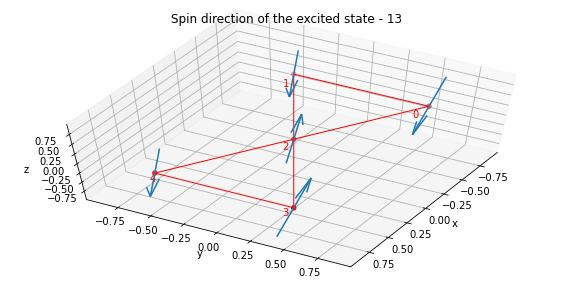

Eigenstate number:  14 ; Energy:  0.0
     Spin  0x 0.01725
     Spin  0y 0.0
     Spin  0z -0.087348
     Spin  1x 0.028345
     Spin  1y 0.0
     Spin  1z -0.152329
     Spin  2x 0.032928
     Spin  2y 0.0
     Spin  2z 0.46946
     Spin  3x 0.029166
     Spin  3y 0.0
     Spin  3z -0.028704
     Spin  4x 0.135979
     Spin  4y 0.0
     Spin  4z 0.162729


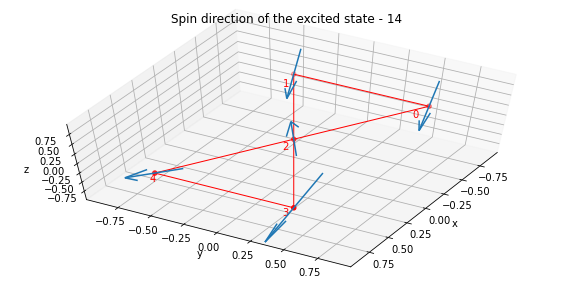

Eigenstate number:  15 ; Energy:  0.0
     Spin  0x -0.25317
     Spin  0y 0.0
     Spin  0z -0.077051
     Spin  1x -0.057075
     Spin  1y 0.0
     Spin  1z -0.193805
     Spin  2x -0.051376
     Spin  2y 0.0
     Spin  2z 0.192655
     Spin  3x -0.180674
     Spin  3y 0.0
     Spin  3z -0.045553
     Spin  4x 0.144545
     Spin  4y 0.0
     Spin  4z 0.12725


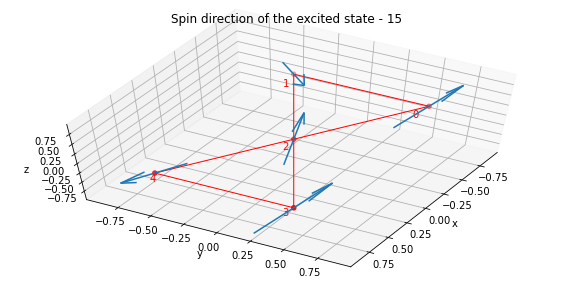

Eigenstate number:  16 ; Energy:  0.0
     Spin  0x -0.352941
     Spin  0y -0.020705
     Spin  0z -0.053014
     Spin  1x -0.073388
     Spin  1y 0.059717
     Spin  1z -0.226856
     Spin  2x -0.076984
     Spin  2y -0.114089
     Spin  2z 0.054271
     Spin  3x -0.193415
     Spin  3y 0.058798
     Spin  3z -0.069339
     Spin  4x 0.16457
     Spin  4y 0.071095
     Spin  4z 0.184204


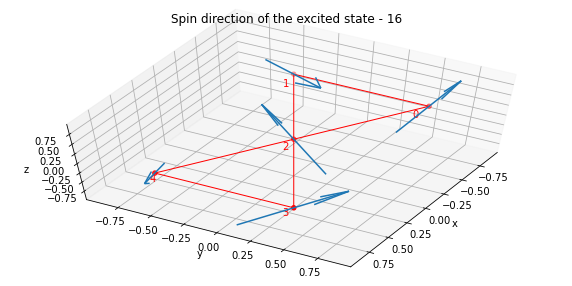

Eigenstate number:  17 ; Energy:  0.0
     Spin  0x -0.352941
     Spin  0y 0.020705
     Spin  0z -0.053014
     Spin  1x -0.073388
     Spin  1y -0.059717
     Spin  1z -0.226856
     Spin  2x -0.076984
     Spin  2y 0.114089
     Spin  2z 0.054271
     Spin  3x -0.193415
     Spin  3y -0.058798
     Spin  3z -0.069339
     Spin  4x 0.16457
     Spin  4y -0.071095
     Spin  4z 0.184204


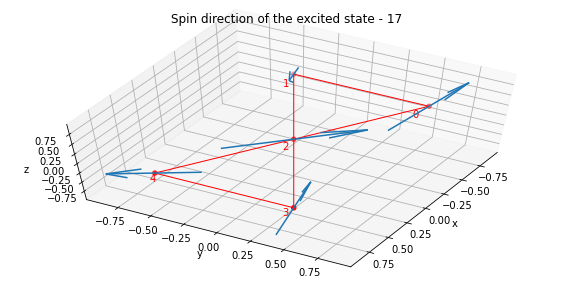

Eigenstate number:  18 ; Energy:  0.0
     Spin  0x -0.294848
     Spin  0y 0.0
     Spin  0z 0.003824
     Spin  1x 0.222367
     Spin  1y 0.0
     Spin  1z -0.185689
     Spin  2x 0.266951
     Spin  2y 0.0
     Spin  2z -0.375389
     Spin  3x -0.138878
     Spin  3y 0.0
     Spin  3z -0.041942
     Spin  4x 0.105055
     Spin  4y 0.0
     Spin  4z 0.151444


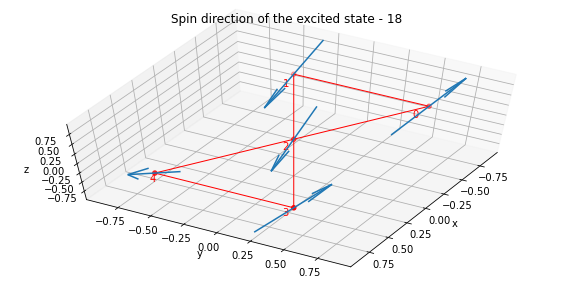

Eigenstate number:  19 ; Energy:  0.0
     Spin  0x 0.0
     Spin  0y 0.0
     Spin  0z 0.5
     Spin  1x 0.0
     Spin  1y 0.0
     Spin  1z -0.833333
     Spin  2x 0.0
     Spin  2y 0.0
     Spin  2z -1.0
     Spin  3x 0.0
     Spin  3y 0.0
     Spin  3z -0.833333
     Spin  4x 0.0
     Spin  4y 0.0
     Spin  4z -0.833333


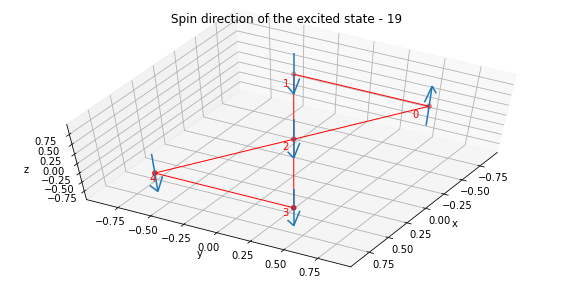

Eigenstate number:  20 ; Energy:  0.0
     Spin  0x -0.307284
     Spin  0y 0.0
     Spin  0z -0.066013
     Spin  1x -0.14706
     Spin  1y 0.0
     Spin  1z -0.100816
     Spin  2x 0.080399
     Spin  2y 0.0
     Spin  2z -0.564484
     Spin  3x 0.188254
     Spin  3y 0.0
     Spin  3z -0.127898
     Spin  4x 0.067706
     Spin  4y 0.0
     Spin  4z 0.039267


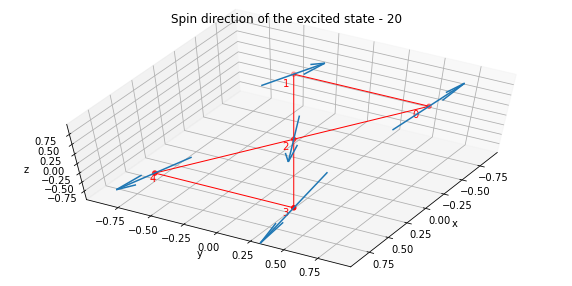

Eigenstate number:  21 ; Energy:  0.0
     Spin  0x 0.0
     Spin  0y 0.0
     Spin  0z -0.469574
     Spin  1x 0.0
     Spin  1y 0.0
     Spin  1z 0.830932
     Spin  2x 0.0
     Spin  2y 0.0
     Spin  2z 0.946237
     Spin  3x 0.0
     Spin  3y 0.0
     Spin  3z 0.765558
     Spin  4x 0.0
     Spin  4y 0.0
     Spin  4z 0.765558


Eigenstate number:  22 ; Energy:  0.0
     Spin  0x -0.111324
     Spin  0y 0.074281
     Spin  0z -0.012738
     Spin  1x 0.631067
     Spin  1y -0.022711
     Spin  1z 0.089299
     Spin  2x 0.047173
     Spin  2y 0.091159
     Spin  2z 0.325794
     Spin  3x 0.110895
     Spin  3y -0.016854
     Spin  3z 0.151278
     Spin  4x -0.117373
     Spin  4y 0.007026
     Spin  4z 0.211768


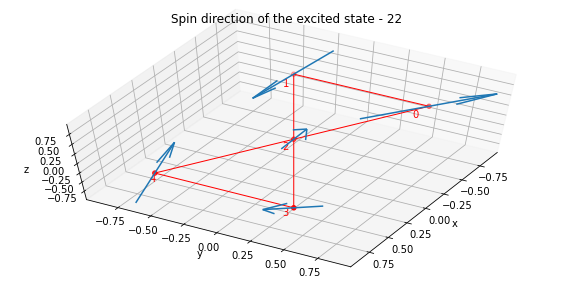

Eigenstate number:  23 ; Energy:  0.0
     Spin  0x -0.111324
     Spin  0y -0.074281
     Spin  0z -0.012738
     Spin  1x 0.631067
     Spin  1y 0.022711
     Spin  1z 0.089299
     Spin  2x 0.047173
     Spin  2y -0.091159
     Spin  2z 0.325794
     Spin  3x 0.110895
     Spin  3y 0.016854
     Spin  3z 0.151278
     Spin  4x -0.117373
     Spin  4y -0.007026
     Spin  4z 0.211768


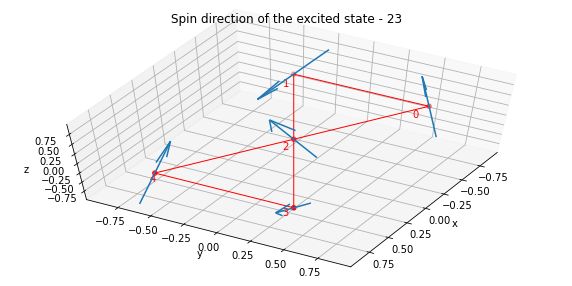

Eigenstate number:  24 ; Energy:  32.0
     Spin  0x 0.0
     Spin  0y 0.0
     Spin  0z 0.0
     Spin  1x 0.0
     Spin  1y 0.0
     Spin  1z 0.0
     Spin  2x 0.256265
     Spin  2y 0.0
     Spin  2z -0.966607
     Spin  3x 0.0
     Spin  3y 0.0
     Spin  3z 0.0
     Spin  4x 0.0
     Spin  4y 0.0
     Spin  4z 0.0


Eigenstate number:  25 ; Energy:  32.0
     Spin  0x 0.0
     Spin  0y 0.0
     Spin  0z 0.0
     Spin  1x 0.0
     Spin  1y 0.0
     Spin  1z 0.0
     Spin  2x 0.0
     Spin  2y 0.0
     Spin  2z 1.0
     Spin  3x 0.0
     Spin  3y 0.0
     Spin  3z 0.0
     Spin  4x 0.0
     Spin  4y 0.0
     Spin  4z 0.0


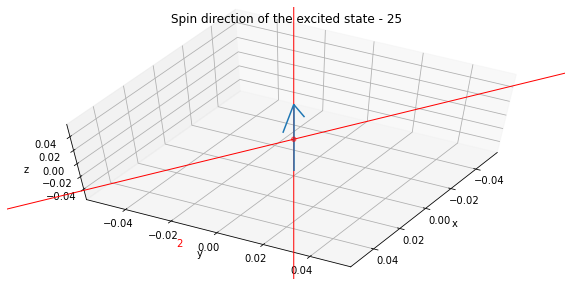

Eigenstate number:  26 ; Energy:  96.0
     Spin  0x 0.0
     Spin  0y 0.0
     Spin  0z -0.6
     Spin  1x 0.0
     Spin  1y 0.0
     Spin  1z -0.6
     Spin  2x 0.0
     Spin  2y 0.0
     Spin  2z -0.6
     Spin  3x 0.0
     Spin  3y 0.0
     Spin  3z -0.6
     Spin  4x 0.0
     Spin  4y 0.0
     Spin  4z -0.6


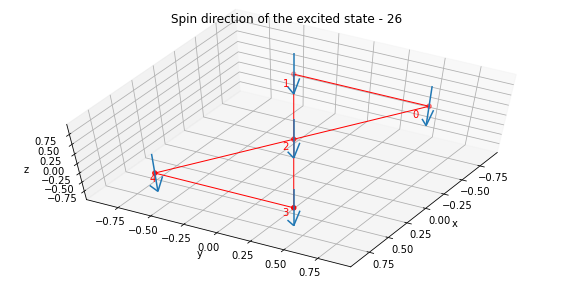

Eigenstate number:  27 ; Energy:  96.0
     Spin  0x -0.015258
     Spin  0y 0.0
     Spin  0z 0.200067
     Spin  1x -0.015258
     Spin  1y 0.0
     Spin  1z 0.200067
     Spin  2x -0.015258
     Spin  2y 0.0
     Spin  2z 0.200067
     Spin  3x -0.015258
     Spin  3y 0.0
     Spin  3z 0.200067
     Spin  4x -0.015258
     Spin  4y 0.0
     Spin  4z 0.200067


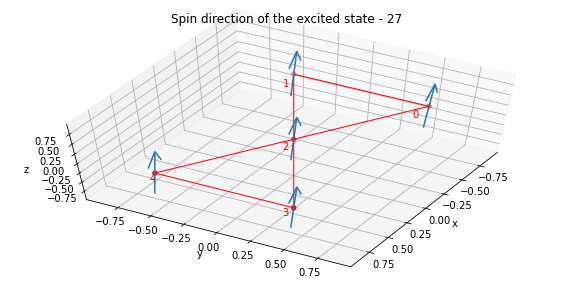

Eigenstate number:  28 ; Energy:  96.0
     Spin  0x 0.0
     Spin  0y 0.0
     Spin  0z 1.0
     Spin  1x 0.0
     Spin  1y 0.0
     Spin  1z 1.0
     Spin  2x 0.0
     Spin  2y 0.0
     Spin  2z 1.0
     Spin  3x 0.0
     Spin  3y 0.0
     Spin  3z 1.0
     Spin  4x 0.0
     Spin  4y 0.0
     Spin  4z 1.0


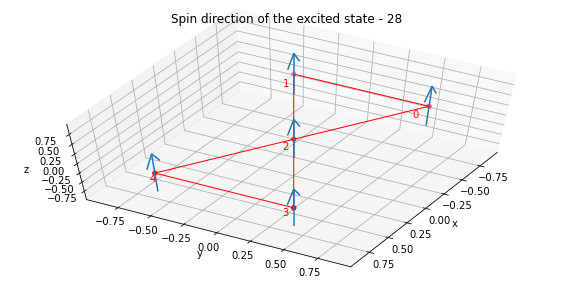

Eigenstate number:  29 ; Energy:  96.0
     Spin  0x 0.0
     Spin  0y 0.0
     Spin  0z -1.0
     Spin  1x 0.0
     Spin  1y 0.0
     Spin  1z -1.0
     Spin  2x 0.0
     Spin  2y 0.0
     Spin  2z -1.0
     Spin  3x 0.0
     Spin  3y 0.0
     Spin  3z -1.0
     Spin  4x 0.0
     Spin  4y 0.0
     Spin  4z -1.0


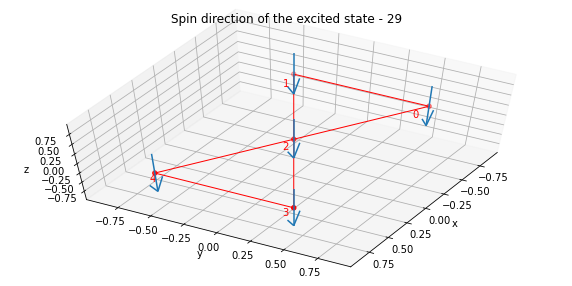

Eigenstate number:  30 ; Energy:  96.0
     Spin  0x 0.078245
     Spin  0y 0.0
     Spin  0z -0.198275
     Spin  1x 0.078245
     Spin  1y 0.0
     Spin  1z -0.198275
     Spin  2x 0.078245
     Spin  2y 0.0
     Spin  2z -0.198275
     Spin  3x 0.078245
     Spin  3y 0.0
     Spin  3z -0.198275
     Spin  4x 0.078245
     Spin  4y 0.0
     Spin  4z -0.198275


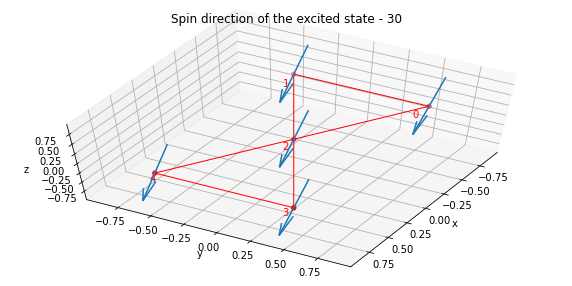

Eigenstate number:  31 ; Energy:  96.0
     Spin  0x 0.0
     Spin  0y 0.0
     Spin  0z 0.597952
     Spin  1x 0.0
     Spin  1y 0.0
     Spin  1z 0.597952
     Spin  2x 0.0
     Spin  2y 0.0
     Spin  2z 0.597952
     Spin  3x 0.0
     Spin  3y 0.0
     Spin  3z 0.597952
     Spin  4x 0.0
     Spin  4y 0.0
     Spin  4z 0.597952


In [222]:
zz=np.zeros(nqubit)
for i in range(nqubit):
    zz[i]=z[i]-0.75

for i,(ei,ai) in enumerate(zip(num_result[0],num_result[2])):
        u=[]
        v=[]
        w=[]
        
        print("Eigenstate number: ",i,"; Energy: ",round(np.real(ei),10))
        if i<2:
            print("GROUND STATE - ",i)
        for js,(name_s,s) in enumerate(spins):
            if (js%3)==0:
                u.append(round(ai[js][0],6))
            if (js%3)==1:
                v.append(round(ai[js][0],6))
            if(js%3)==2:
                w.append(round(ai[js][0],6))
                
            print("     Spin ",name_s,round(ai[js][0],6))
       
        fig = plt.figure(figsize=(10,5))
        ax = fig.gca(projection='3d')

        
        if i<2:
            ax.set_title("Spin direction of the ground state - "+str(i))
            ax.quiver(x,y,z,u,v,w,length=0.1, pivot='middle', normalize=True)
        else:
            ax.set_title("Spin direction of the excited state - "+str(i))
            #If we introduce pivot='middle' in quiver the arrows start from the site
            if i==24 or i==25:
                ax.quiver(x,y,z,u,v,w,length=0.1, pivot='middle', normalize=True)
            else:
                ax.quiver(x,y,z,u,v,w,length=1.0, pivot='middle', normalize=True)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.view_init(60,30)
        set_axes_equal(ax)
        
        ax.scatter(x,y,z,color="r")
        ax.plot(x,y,z,"r",linewidth="1")
        ax.plot([-0.866,0,0.866],[0.5,0,-0.5],[0,0,0],"r",linewidth="1")
        
        for i,val in enumerate(x):
            ax.text(x[i]-0.2,y[i]-0.2,zz[i],i,color='red')
            
        plt.show()

### Spin-spin correlation functions on the eigenstates of $\Pi_{0,0}H\Pi_{0,0}$

We now want to study the spin-spin correlation functions, defined as follow:

$$ \langle S_i S_j \rangle_C =\langle S_i S_j \rangle - \langle S_i\rangle \langle S_j \rangle = \langle \sum_{\alpha=\{x,y,z\}} S_i^{\alpha} S_j^{\alpha} \rangle - \langle S_i\rangle \langle S_j \rangle$$

$S_i^{\alpha}$ is the spin operator acting on site $i$ of component $\alpha=\{x,y,z\}$ and the angular brackets refer to an expectation value. The "bow-tie" lattice is composed by $5$ sites, therefore we have to manage $25$ different spin-spin correlation functions. Because of simmetry considerations, we expect that $\langle S_i S_j \rangle_C=\langle S_j S_i \rangle_C$.

In [223]:
def generate_spinspin_operators(nqubit):
    spin_spin=[]
    for i in range(nqubit):
        for j in range(nqubit):
            xi = PauliOp(generate_pauli([i],[],nqubit));
            xj = PauliOp(generate_pauli([j],[],nqubit));
            
            yi = PauliOp(generate_pauli([i],[i],nqubit));
            yj = PauliOp(generate_pauli([j],[j],nqubit));
            
            zi = PauliOp(generate_pauli([],[i],nqubit));
            zj = PauliOp(generate_pauli([],[j],nqubit));
            
            spin_spin.append( (str(i)+'x-'+str(j)+'x',xi.compose(xj)))
            spin_spin.append( (str(i)+'y-'+str(j)+'y',yi.compose(yj)) )
            spin_spin.append( (str(i)+'z-'+str(j)+'z',zi.compose(zj)) )
            
    return spin_spin

In [224]:
spin_spin=generate_spinspin_operators(nqubit)
print("Spin-spin operators number: "+str(len(spin_spin)))
#for name_s,s in spin_spin:
#    print(name_s+' '+str(s))

Spin-spin operators number: 75


In [225]:
num_result2=diagonalize_H(num_op.to_pauli_op(),spin_spin)

In [226]:
name=[]
for (name_s,s) in spins:
    name.append(name_s)
print(name)

['0x', '0y', '0z', '1x', '1y', '1z', '2x', '2y', '2z', '3x', '3y', '3z', '4x', '4y', '4z']


Eigenstate number:  0 ; Energy:  -96.0
Spin-spin correlation values:
     Spin-spin  0-0  3.0
     Spin-spin  0-1  -3.0
     Spin-spin  0-2  0.0
     Spin-spin  0-3  0.0
     Spin-spin  0-4  0.0
     Spin-spin  1-0  -3.0
     Spin-spin  1-1  3.0
     Spin-spin  1-2  0.0
     Spin-spin  1-3  0.0
     Spin-spin  1-4  0.0
     Spin-spin  2-0  0.0
     Spin-spin  2-1  0.0
     Spin-spin  2-2  2.0
     Spin-spin  2-3  0.0
     Spin-spin  2-4  0.0
     Spin-spin  3-0  0.0
     Spin-spin  3-1  0.0
     Spin-spin  3-2  0.0
     Spin-spin  3-3  3.0
     Spin-spin  3-4  -3.0
     Spin-spin  4-0  0.0
     Spin-spin  4-1  0.0
     Spin-spin  4-2  0.0
     Spin-spin  4-3  -3.0
     Spin-spin  4-4  3.0


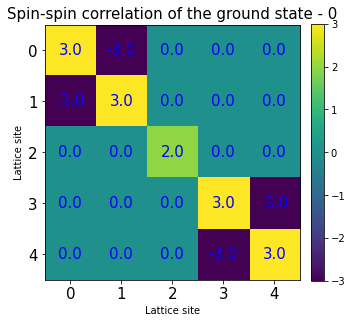

Eigenstate number:  1 ; Energy:  -96.0
Spin-spin correlation values:
     Spin-spin  0-0  3.0
     Spin-spin  0-1  -3.0
     Spin-spin  0-2  0.0
     Spin-spin  0-3  0.0
     Spin-spin  0-4  0.0
     Spin-spin  1-0  -3.0
     Spin-spin  1-1  3.0
     Spin-spin  1-2  0.0
     Spin-spin  1-3  0.0
     Spin-spin  1-4  0.0
     Spin-spin  2-0  0.0
     Spin-spin  2-1  0.0
     Spin-spin  2-2  2.0
     Spin-spin  2-3  0.0
     Spin-spin  2-4  0.0
     Spin-spin  3-0  0.0
     Spin-spin  3-1  0.0
     Spin-spin  3-2  0.0
     Spin-spin  3-3  3.0
     Spin-spin  3-4  -3.0
     Spin-spin  4-0  0.0
     Spin-spin  4-1  0.0
     Spin-spin  4-2  0.0
     Spin-spin  4-3  -3.0
     Spin-spin  4-4  3.0


Eigenstate number:  2 ; Energy:  -64.0
Spin-spin correlation values:
     Spin-spin  0-0  2.392414
     Spin-spin  0-1  0.392414
     Spin-spin  0-2  -1.905057
     Spin-spin  0-3  0.392414
     Spin-spin  0-4  0.392414
     Spin-spin  1-0  0.392414
     Spin-spin  1-1  2.392414
     Spin-spin  1-2  -1.905057
     Spin-spin  1-3  0.392414
     Spin-spin  1-4  0.392414
     Spin-spin  2-0  -1.905057
     Spin-spin  2-1  -1.905057
     Spin-spin  2-2  2.729962
     Spin-spin  2-3  -1.905057
     Spin-spin  2-4  -1.905057
     Spin-spin  3-0  0.392414
     Spin-spin  3-1  0.392414
     Spin-spin  3-2  -1.905057
     Spin-spin  3-3  2.392414
     Spin-spin  3-4  0.392414
     Spin-spin  4-0  0.392414
     Spin-spin  4-1  0.392414
     Spin-spin  4-2  -1.905057
     Spin-spin  4-3  0.392414
     Spin-spin  4-4  2.392414


Eigenstate number:  3 ; Energy:  -64.0
Spin-spin correlation values:
     Spin-spin  0-0  2.909808
     Spin-spin  0-1  0.909808
     Spin-spin  0-2  -1.560128
     Spin-spin  0-3  0.909808
     Spin-spin  0-4  0.909808
     Spin-spin  1-0  0.909808
     Spin-spin  1-1  2.909808
     Spin-spin  1-2  -1.560128
     Spin-spin  1-3  0.909808
     Spin-spin  1-4  0.909808
     Spin-spin  2-0  -1.560128
     Spin-spin  2-1  -1.560128
     Spin-spin  2-2  2.959915
     Spin-spin  2-3  -1.560128
     Spin-spin  2-4  -1.560128
     Spin-spin  3-0  0.909808
     Spin-spin  3-1  0.909808
     Spin-spin  3-2  -1.560128
     Spin-spin  3-3  2.909808
     Spin-spin  3-4  0.909808
     Spin-spin  4-0  0.909808
     Spin-spin  4-1  0.909808
     Spin-spin  4-2  -1.560128
     Spin-spin  4-3  0.909808
     Spin-spin  4-4  2.909808


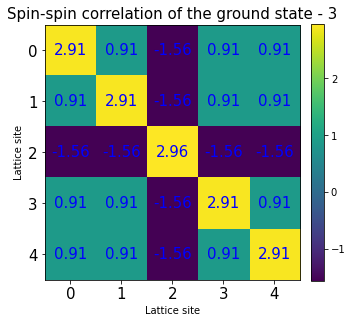

Eigenstate number:  4 ; Energy:  -64.0
Spin-spin correlation values:
     Spin-spin  0-0  2.19
     Spin-spin  0-1  0.19
     Spin-spin  0-2  -2.04
     Spin-spin  0-3  0.19
     Spin-spin  0-4  0.19
     Spin-spin  1-0  0.19
     Spin-spin  1-1  2.19
     Spin-spin  1-2  -2.04
     Spin-spin  1-3  0.19
     Spin-spin  1-4  0.19
     Spin-spin  2-0  -2.04
     Spin-spin  2-1  -2.04
     Spin-spin  2-2  2.64
     Spin-spin  2-3  -2.04
     Spin-spin  2-4  -2.04
     Spin-spin  3-0  0.19
     Spin-spin  3-1  0.19
     Spin-spin  3-2  -2.04
     Spin-spin  3-3  2.19
     Spin-spin  3-4  0.19
     Spin-spin  4-0  0.19
     Spin-spin  4-1  0.19
     Spin-spin  4-2  -2.04
     Spin-spin  4-3  0.19
     Spin-spin  4-4  2.19


Eigenstate number:  5 ; Energy:  -64.0
Spin-spin correlation values:
     Spin-spin  0-0  2.88937
     Spin-spin  0-1  0.88937
     Spin-spin  0-2  -1.573754
     Spin-spin  0-3  0.88937
     Spin-spin  0-4  0.88937
     Spin-spin  1-0  0.88937
     Spin-spin  1-1  2.88937
     Spin-spin  1-2  -1.573754
     Spin-spin  1-3  0.88937
     Spin-spin  1-4  0.88937
     Spin-spin  2-0  -1.573754
     Spin-spin  2-1  -1.573754
     Spin-spin  2-2  2.950831
     Spin-spin  2-3  -1.573754
     Spin-spin  2-4  -1.573754
     Spin-spin  3-0  0.88937
     Spin-spin  3-1  0.88937
     Spin-spin  3-2  -1.573754
     Spin-spin  3-3  2.88937
     Spin-spin  3-4  0.88937
     Spin-spin  4-0  0.88937
     Spin-spin  4-1  0.88937
     Spin-spin  4-2  -1.573754
     Spin-spin  4-3  0.88937
     Spin-spin  4-4  2.88937


Eigenstate number:  6 ; Energy:  -0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.993545
     Spin-spin  0-1  0.617812
     Spin-spin  0-2  0.247105
     Spin-spin  0-3  0.011444
     Spin-spin  0-4  -0.624867
     Spin-spin  1-0  0.617812
     Spin-spin  1-1  2.931379
     Spin-spin  1-2  0.175676
     Spin-spin  1-3  -0.003736
     Spin-spin  1-4  -1.730444
     Spin-spin  2-0  0.247105
     Spin-spin  2-1  0.175676
     Spin-spin  2-2  2.904761
     Spin-spin  2-3  0.192204
     Spin-spin  2-4  -0.242024
     Spin-spin  3-0  0.011444
     Spin-spin  3-1  -0.003736
     Spin-spin  3-2  0.192204
     Spin-spin  3-3  2.993617
     Spin-spin  3-4  -0.348541
     Spin-spin  4-0  -0.624867
     Spin-spin  4-1  -1.730444
     Spin-spin  4-2  -0.242024
     Spin-spin  4-3  -0.348541
     Spin-spin  4-4  2.994972


Eigenstate number:  7 ; Energy:  -0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.965029
     Spin-spin  0-1  0.515706
     Spin-spin  0-2  0.099018
     Spin-spin  0-3  -0.670243
     Spin-spin  0-4  -0.169954
     Spin-spin  1-0  0.515706
     Spin-spin  1-1  2.96139
     Spin-spin  1-2  0.096099
     Spin-spin  1-3  -0.144533
     Spin-spin  1-4  -1.120923
     Spin-spin  2-0  0.099018
     Spin-spin  2-1  0.096099
     Spin-spin  2-2  2.311715
     Spin-spin  2-3  0.146707
     Spin-spin  2-4  -0.366287
     Spin-spin  3-0  -0.670243
     Spin-spin  3-1  -0.144533
     Spin-spin  3-2  0.146707
     Spin-spin  3-3  2.91563
     Spin-spin  3-4  -0.709201
     Spin-spin  4-0  -0.169954
     Spin-spin  4-1  -1.120923
     Spin-spin  4-2  -0.366287
     Spin-spin  4-3  -0.709201
     Spin-spin  4-4  2.949796


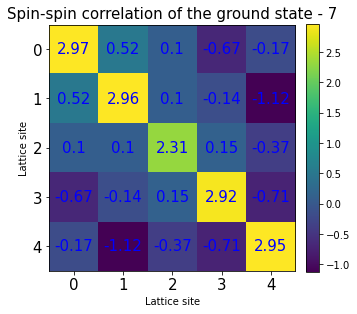

Eigenstate number:  8 ; Energy:  -0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.965029
     Spin-spin  0-1  0.515706
     Spin-spin  0-2  0.099018
     Spin-spin  0-3  -0.670243
     Spin-spin  0-4  -0.169954
     Spin-spin  1-0  0.515706
     Spin-spin  1-1  2.96139
     Spin-spin  1-2  0.096099
     Spin-spin  1-3  -0.144533
     Spin-spin  1-4  -1.120923
     Spin-spin  2-0  0.099018
     Spin-spin  2-1  0.096099
     Spin-spin  2-2  2.311715
     Spin-spin  2-3  0.146707
     Spin-spin  2-4  -0.366287
     Spin-spin  3-0  -0.670243
     Spin-spin  3-1  -0.144533
     Spin-spin  3-2  0.146707
     Spin-spin  3-3  2.91563
     Spin-spin  3-4  -0.709201
     Spin-spin  4-0  -0.169954
     Spin-spin  4-1  -1.120923
     Spin-spin  4-2  -0.366287
     Spin-spin  4-3  -0.709201
     Spin-spin  4-4  2.949796


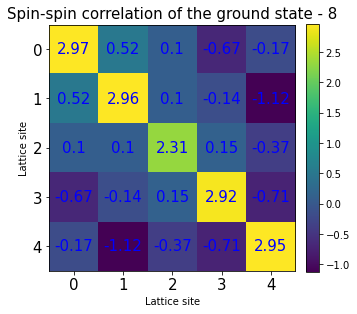

Eigenstate number:  9 ; Energy:  -0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.919615
     Spin-spin  0-1  0.426243
     Spin-spin  0-2  -0.201509
     Spin-spin  0-3  -0.230991
     Spin-spin  0-4  -0.835265
     Spin-spin  1-0  0.426243
     Spin-spin  1-1  2.977147
     Spin-spin  1-2  -0.090677
     Spin-spin  1-3  -0.03697
     Spin-spin  1-4  -1.194904
     Spin-spin  2-0  -0.201509
     Spin-spin  2-1  -0.090677
     Spin-spin  2-2  2.732178
     Spin-spin  2-3  -0.255709
     Spin-spin  2-4  0.173086
     Spin-spin  3-0  -0.230991
     Spin-spin  3-1  -0.03697
     Spin-spin  3-2  -0.255709
     Spin-spin  3-3  2.805356
     Spin-spin  3-4  -0.537719
     Spin-spin  4-0  -0.835265
     Spin-spin  4-1  -1.194904
     Spin-spin  4-2  0.173086
     Spin-spin  4-3  -0.537719
     Spin-spin  4-4  2.960096


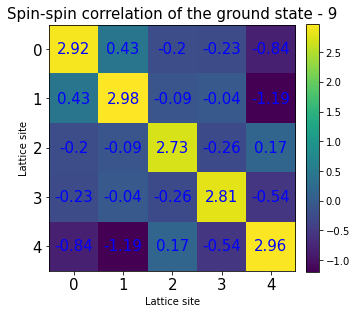

Eigenstate number:  10 ; Energy:  -0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.919615
     Spin-spin  0-1  0.426243
     Spin-spin  0-2  -0.201509
     Spin-spin  0-3  -0.230991
     Spin-spin  0-4  -0.835265
     Spin-spin  1-0  0.426243
     Spin-spin  1-1  2.977147
     Spin-spin  1-2  -0.090677
     Spin-spin  1-3  -0.03697
     Spin-spin  1-4  -1.194904
     Spin-spin  2-0  -0.201509
     Spin-spin  2-1  -0.090677
     Spin-spin  2-2  2.732178
     Spin-spin  2-3  -0.255709
     Spin-spin  2-4  0.173086
     Spin-spin  3-0  -0.230991
     Spin-spin  3-1  -0.03697
     Spin-spin  3-2  -0.255709
     Spin-spin  3-3  2.805356
     Spin-spin  3-4  -0.537719
     Spin-spin  4-0  -0.835265
     Spin-spin  4-1  -1.194904
     Spin-spin  4-2  0.173086
     Spin-spin  4-3  -0.537719
     Spin-spin  4-4  2.960096


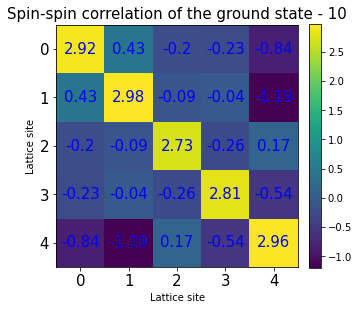

Eigenstate number:  11 ; Energy:  -0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.696133
     Spin-spin  0-1  0.42107
     Spin-spin  0-2  -0.592783
     Spin-spin  0-3  -0.808584
     Spin-spin  0-4  0.1747
     Spin-spin  1-0  0.42107
     Spin-spin  1-1  2.78477
     Spin-spin  1-2  -0.591353
     Spin-spin  1-3  -1.559914
     Spin-spin  1-4  -0.319888
     Spin-spin  2-0  -0.592783
     Spin-spin  2-1  -0.591353
     Spin-spin  2-2  2.793195
     Spin-spin  2-3  0.009151
     Spin-spin  2-4  -0.740176
     Spin-spin  3-0  -0.808584
     Spin-spin  3-1  -1.559914
     Spin-spin  3-2  0.009151
     Spin-spin  3-3  2.835915
     Spin-spin  3-4  -1.480827
     Spin-spin  4-0  0.1747
     Spin-spin  4-1  -0.319888
     Spin-spin  4-2  -0.740176
     Spin-spin  4-3  -1.480827
     Spin-spin  4-4  2.592623


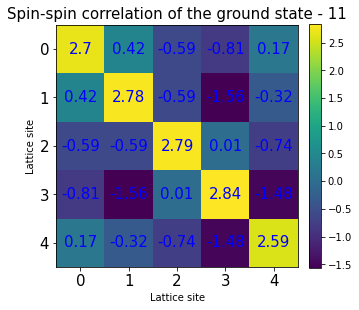

Eigenstate number:  12 ; Energy:  -0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.696133
     Spin-spin  0-1  0.42107
     Spin-spin  0-2  -0.592783
     Spin-spin  0-3  -0.808584
     Spin-spin  0-4  0.1747
     Spin-spin  1-0  0.42107
     Spin-spin  1-1  2.78477
     Spin-spin  1-2  -0.591353
     Spin-spin  1-3  -1.559914
     Spin-spin  1-4  -0.319888
     Spin-spin  2-0  -0.592783
     Spin-spin  2-1  -0.591353
     Spin-spin  2-2  2.793195
     Spin-spin  2-3  0.009151
     Spin-spin  2-4  -0.740176
     Spin-spin  3-0  -0.808584
     Spin-spin  3-1  -1.559914
     Spin-spin  3-2  0.009151
     Spin-spin  3-3  2.835915
     Spin-spin  3-4  -1.480827
     Spin-spin  4-0  0.1747
     Spin-spin  4-1  -0.319888
     Spin-spin  4-2  -0.740176
     Spin-spin  4-3  -1.480827
     Spin-spin  4-4  2.592623


Eigenstate number:  13 ; Energy:  0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.82232
     Spin-spin  0-1  0.436657
     Spin-spin  0-2  -0.810502
     Spin-spin  0-3  -2.567055
     Spin-spin  0-4  0.038486
     Spin-spin  1-0  0.436657
     Spin-spin  1-1  2.273722
     Spin-spin  1-2  -1.687573
     Spin-spin  1-3  -1.412821
     Spin-spin  1-4  -0.001342
     Spin-spin  2-0  -0.810502
     Spin-spin  2-1  -1.687573
     Spin-spin  2-2  2.13436
     Spin-spin  2-3  -0.017095
     Spin-spin  2-4  -1.906238
     Spin-spin  3-0  -2.567055
     Spin-spin  3-1  -1.412821
     Spin-spin  3-2  -0.017095
     Spin-spin  3-3  2.902775
     Spin-spin  3-4  -0.743295
     Spin-spin  4-0  0.038486
     Spin-spin  4-1  -0.001342
     Spin-spin  4-2  -1.906238
     Spin-spin  4-3  -0.743295
     Spin-spin  4-4  2.113359


Eigenstate number:  14 ; Energy:  0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.992073
     Spin-spin  0-1  -0.618025
     Spin-spin  0-2  -0.679382
     Spin-spin  0-3  0.540525
     Spin-spin  0-4  -0.824951
     Spin-spin  1-0  -0.618025
     Spin-spin  1-1  2.975993
     Spin-spin  1-2  -0.133123
     Spin-spin  1-3  -0.499241
     Spin-spin  1-4  -0.732274
     Spin-spin  2-0  -0.679382
     Spin-spin  2-1  -0.133123
     Spin-spin  2-2  2.778523
     Spin-spin  2-3  -0.508273
     Spin-spin  2-4  0.169461
     Spin-spin  3-0  0.540525
     Spin-spin  3-1  -0.499241
     Spin-spin  3-2  -0.508273
     Spin-spin  3-3  2.998325
     Spin-spin  3-4  0.049769
     Spin-spin  4-0  -0.824951
     Spin-spin  4-1  -0.732274
     Spin-spin  4-2  0.169461
     Spin-spin  4-3  0.049769
     Spin-spin  4-4  2.955029


Eigenstate number:  15 ; Energy:  0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.929968
     Spin-spin  0-1  -0.170207
     Spin-spin  0-2  -0.962466
     Spin-spin  0-3  0.297091
     Spin-spin  0-4  -1.200956
     Spin-spin  1-0  -0.170207
     Spin-spin  1-1  2.959182
     Spin-spin  1-2  -0.313747
     Spin-spin  1-3  0.225928
     Spin-spin  1-4  -1.322291
     Spin-spin  2-0  -0.962466
     Spin-spin  2-1  -0.313747
     Spin-spin  2-2  2.960244
     Spin-spin  2-3  -1.061026
     Spin-spin  2-4  0.335536
     Spin-spin  3-0  0.297091
     Spin-spin  3-1  0.225928
     Spin-spin  3-2  -1.061026
     Spin-spin  3-3  2.965282
     Spin-spin  3-4  -0.095736
     Spin-spin  4-0  -1.200956
     Spin-spin  4-1  -1.322291
     Spin-spin  4-2  0.335536
     Spin-spin  4-3  -0.095736
     Spin-spin  4-4  2.962914


Eigenstate number:  16 ; Energy:  0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.872194
     Spin-spin  0-1  0.383657
     Spin-spin  0-2  -0.757584
     Spin-spin  0-3  -0.160509
     Spin-spin  0-4  -0.899537
     Spin-spin  1-0  0.383657
     Spin-spin  1-1  2.939584
     Spin-spin  1-2  -0.855549
     Spin-spin  1-3  0.056499
     Spin-spin  1-4  -0.984381
     Spin-spin  2-0  -0.757584
     Spin-spin  2-1  -0.855549
     Spin-spin  2-2  2.978112
     Spin-spin  2-3  -1.087822
     Spin-spin  2-4  0.334508
     Spin-spin  3-0  -0.160509
     Spin-spin  3-1  0.056499
     Spin-spin  3-2  -1.087822
     Spin-spin  3-3  2.954326
     Spin-spin  3-4  -0.822539
     Spin-spin  4-0  -0.899537
     Spin-spin  4-1  -0.984381
     Spin-spin  4-2  0.334508
     Spin-spin  4-3  -0.822539
     Spin-spin  4-4  2.933931


Eigenstate number:  17 ; Energy:  0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.872194
     Spin-spin  0-1  0.383657
     Spin-spin  0-2  -0.757584
     Spin-spin  0-3  -0.160509
     Spin-spin  0-4  -0.899537
     Spin-spin  1-0  0.383657
     Spin-spin  1-1  2.939584
     Spin-spin  1-2  -0.855549
     Spin-spin  1-3  0.056499
     Spin-spin  1-4  -0.984381
     Spin-spin  2-0  -0.757584
     Spin-spin  2-1  -0.855549
     Spin-spin  2-2  2.978112
     Spin-spin  2-3  -1.087822
     Spin-spin  2-4  0.334508
     Spin-spin  3-0  -0.160509
     Spin-spin  3-1  0.056499
     Spin-spin  3-2  -1.087822
     Spin-spin  3-3  2.954326
     Spin-spin  3-4  -0.822539
     Spin-spin  4-0  -0.899537
     Spin-spin  4-1  -0.984381
     Spin-spin  4-2  0.334508
     Spin-spin  4-3  -0.822539
     Spin-spin  4-4  2.933931


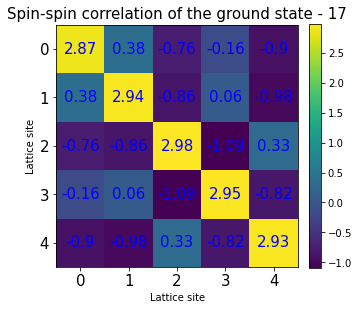

Eigenstate number:  18 ; Energy:  0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.91305
     Spin-spin  0-1  -1.436718
     Spin-spin  0-2  -0.633151
     Spin-spin  0-3  0.302141
     Spin-spin  0-4  0.214853
     Spin-spin  1-0  -1.436718
     Spin-spin  1-1  2.916073
     Spin-spin  1-2  0.038226
     Spin-spin  1-3  -0.484977
     Spin-spin  1-4  -0.957074
     Spin-spin  2-0  -0.633151
     Spin-spin  2-1  0.038226
     Spin-spin  2-2  2.78782
     Spin-spin  2-3  -0.098639
     Spin-spin  2-4  -0.25419
     Spin-spin  3-0  0.302141
     Spin-spin  3-1  -0.484977
     Spin-spin  3-2  -0.098639
     Spin-spin  3-3  2.978954
     Spin-spin  3-4  0.057059
     Spin-spin  4-0  0.214853
     Spin-spin  4-1  -0.957074
     Spin-spin  4-2  -0.25419
     Spin-spin  4-3  0.057059
     Spin-spin  4-4  2.966028


Eigenstate number:  19 ; Energy:  0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.75
     Spin-spin  0-1  -2.083333
     Spin-spin  0-2  -1.0
     Spin-spin  0-3  -2.083333
     Spin-spin  0-4  -2.083333
     Spin-spin  1-0  -2.083333
     Spin-spin  1-1  2.305556
     Spin-spin  1-2  0.0
     Spin-spin  1-3  0.305556
     Spin-spin  1-4  0.305556
     Spin-spin  2-0  -1.0
     Spin-spin  2-1  0.0
     Spin-spin  2-2  2.0
     Spin-spin  2-3  0.0
     Spin-spin  2-4  0.0
     Spin-spin  3-0  -2.083333
     Spin-spin  3-1  0.305556
     Spin-spin  3-2  0.0
     Spin-spin  3-3  2.305556
     Spin-spin  3-4  0.305556
     Spin-spin  4-0  -2.083333
     Spin-spin  4-1  0.305556
     Spin-spin  4-2  0.0
     Spin-spin  4-3  0.305556
     Spin-spin  4-4  2.305556


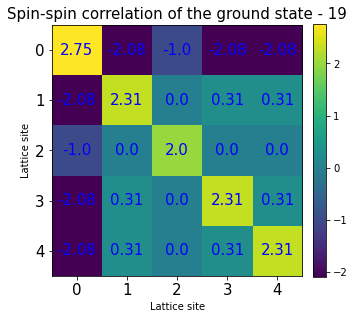

Eigenstate number:  20 ; Energy:  0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.901219
     Spin-spin  0-1  -0.456706
     Spin-spin  0-2  -0.741927
     Spin-spin  0-3  0.488842
     Spin-spin  0-4  -1.200178
     Spin-spin  1-0  -0.456706
     Spin-spin  1-1  2.968209
     Spin-spin  1-2  -1.087914
     Spin-spin  1-3  -0.386478
     Spin-spin  1-4  0.57712
     Spin-spin  2-0  -0.741927
     Spin-spin  2-1  -1.087914
     Spin-spin  2-2  2.674894
     Spin-spin  2-3  -0.477291
     Spin-spin  2-4  0.270995
     Spin-spin  3-0  0.488842
     Spin-spin  3-1  -0.386478
     Spin-spin  3-2  -0.477291
     Spin-spin  3-3  2.948203
     Spin-spin  3-4  -1.247116
     Spin-spin  4-0  -1.200178
     Spin-spin  4-1  0.57712
     Spin-spin  4-2  0.270995
     Spin-spin  4-3  -1.247116
     Spin-spin  4-4  2.993874


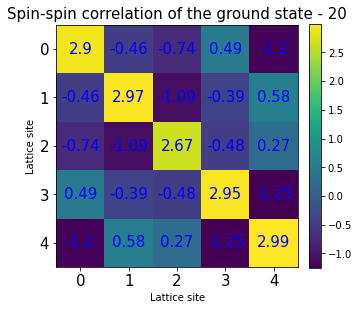

Eigenstate number:  21 ; Energy:  0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.779501
     Spin-spin  0-1  -1.873066
     Spin-spin  0-2  -0.940783
     Spin-spin  0-3  -2.110955
     Spin-spin  0-4  -2.110955
     Spin-spin  1-0  -1.873066
     Spin-spin  1-1  2.309551
     Spin-spin  1-2  0.089475
     Spin-spin  1-3  0.356783
     Spin-spin  1-4  0.356783
     Spin-spin  2-0  -0.940783
     Spin-spin  2-1  0.089475
     Spin-spin  2-2  2.104635
     Spin-spin  2-3  0.085961
     Spin-spin  2-4  0.085961
     Spin-spin  3-0  -2.110955
     Spin-spin  3-1  0.356783
     Spin-spin  3-2  0.085961
     Spin-spin  3-3  2.413921
     Spin-spin  3-4  0.413921
     Spin-spin  4-0  -2.110955
     Spin-spin  4-1  0.356783
     Spin-spin  4-2  0.085961
     Spin-spin  4-3  0.413921
     Spin-spin  4-4  2.413921


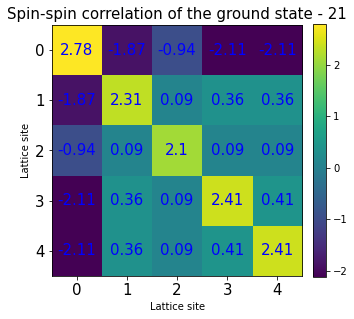

Eigenstate number:  22 ; Energy:  0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.981927
     Spin-spin  0-1  -0.750737
     Spin-spin  0-2  0.1361
     Spin-spin  0-3  0.014735
     Spin-spin  0-4  -1.02857
     Spin-spin  1-0  -0.750737
     Spin-spin  1-1  2.593265
     Spin-spin  1-2  -0.568912
     Spin-spin  1-3  0.158339
     Spin-spin  1-4  -0.62994
     Spin-spin  2-0  0.1361
     Spin-spin  2-1  -0.568912
     Spin-spin  2-2  2.883323
     Spin-spin  2-3  -1.223111
     Spin-spin  2-4  -0.672594
     Spin-spin  3-0  0.014735
     Spin-spin  3-1  0.158339
     Spin-spin  3-2  -1.223111
     Spin-spin  3-3  2.964533
     Spin-spin  3-4  -0.227647
     Spin-spin  4-0  -1.02857
     Spin-spin  4-1  -0.62994
     Spin-spin  4-2  -0.672594
     Spin-spin  4-3  -0.227647
     Spin-spin  4-4  2.941328


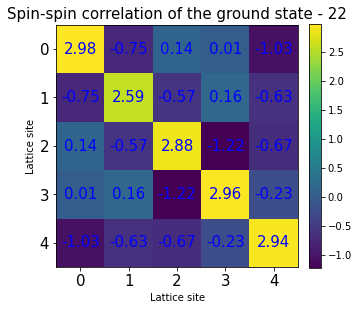

Eigenstate number:  23 ; Energy:  0.0
Spin-spin correlation values:
     Spin-spin  0-0  2.981927
     Spin-spin  0-1  -0.750737
     Spin-spin  0-2  0.1361
     Spin-spin  0-3  0.014735
     Spin-spin  0-4  -1.02857
     Spin-spin  1-0  -0.750737
     Spin-spin  1-1  2.593265
     Spin-spin  1-2  -0.568912
     Spin-spin  1-3  0.158339
     Spin-spin  1-4  -0.62994
     Spin-spin  2-0  0.1361
     Spin-spin  2-1  -0.568912
     Spin-spin  2-2  2.883323
     Spin-spin  2-3  -1.223111
     Spin-spin  2-4  -0.672594
     Spin-spin  3-0  0.014735
     Spin-spin  3-1  0.158339
     Spin-spin  3-2  -1.223111
     Spin-spin  3-3  2.964533
     Spin-spin  3-4  -0.227647
     Spin-spin  4-0  -1.02857
     Spin-spin  4-1  -0.62994
     Spin-spin  4-2  -0.672594
     Spin-spin  4-3  -0.227647
     Spin-spin  4-4  2.941328


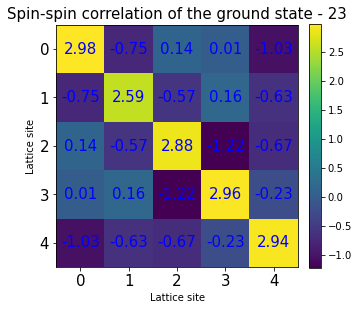

Eigenstate number:  24 ; Energy:  32.0
Spin-spin correlation values:
     Spin-spin  0-0  3.0
     Spin-spin  0-1  1.0
     Spin-spin  0-2  0.0
     Spin-spin  0-3  -2.0
     Spin-spin  0-4  -2.0
     Spin-spin  1-0  1.0
     Spin-spin  1-1  3.0
     Spin-spin  1-2  0.0
     Spin-spin  1-3  -2.0
     Spin-spin  1-4  -2.0
     Spin-spin  2-0  0.0
     Spin-spin  2-1  0.0
     Spin-spin  2-2  2.0
     Spin-spin  2-3  0.0
     Spin-spin  2-4  0.0
     Spin-spin  3-0  -2.0
     Spin-spin  3-1  -2.0
     Spin-spin  3-2  0.0
     Spin-spin  3-3  3.0
     Spin-spin  3-4  1.0
     Spin-spin  4-0  -2.0
     Spin-spin  4-1  -2.0
     Spin-spin  4-2  0.0
     Spin-spin  4-3  1.0
     Spin-spin  4-4  3.0


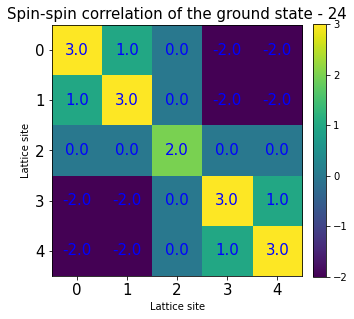

Eigenstate number:  25 ; Energy:  32.0
Spin-spin correlation values:
     Spin-spin  0-0  3.0
     Spin-spin  0-1  1.0
     Spin-spin  0-2  0.0
     Spin-spin  0-3  -2.0
     Spin-spin  0-4  -2.0
     Spin-spin  1-0  1.0
     Spin-spin  1-1  3.0
     Spin-spin  1-2  0.0
     Spin-spin  1-3  -2.0
     Spin-spin  1-4  -2.0
     Spin-spin  2-0  0.0
     Spin-spin  2-1  0.0
     Spin-spin  2-2  2.0
     Spin-spin  2-3  0.0
     Spin-spin  2-4  0.0
     Spin-spin  3-0  -2.0
     Spin-spin  3-1  -2.0
     Spin-spin  3-2  0.0
     Spin-spin  3-3  3.0
     Spin-spin  3-4  1.0
     Spin-spin  4-0  -2.0
     Spin-spin  4-1  -2.0
     Spin-spin  4-2  0.0
     Spin-spin  4-3  1.0
     Spin-spin  4-4  3.0


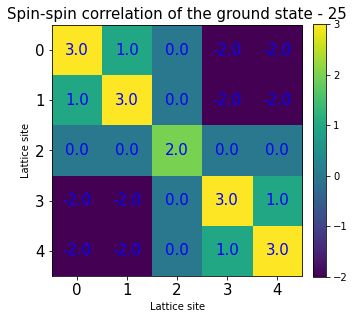

Eigenstate number:  26 ; Energy:  96.0
Spin-spin correlation values:
     Spin-spin  0-0  2.64
     Spin-spin  0-1  0.64
     Spin-spin  0-2  0.64
     Spin-spin  0-3  0.64
     Spin-spin  0-4  0.64
     Spin-spin  1-0  0.64
     Spin-spin  1-1  2.64
     Spin-spin  1-2  0.64
     Spin-spin  1-3  0.64
     Spin-spin  1-4  0.64
     Spin-spin  2-0  0.64
     Spin-spin  2-1  0.64
     Spin-spin  2-2  2.64
     Spin-spin  2-3  0.64
     Spin-spin  2-4  0.64
     Spin-spin  3-0  0.64
     Spin-spin  3-1  0.64
     Spin-spin  3-2  0.64
     Spin-spin  3-3  2.64
     Spin-spin  3-4  0.64
     Spin-spin  4-0  0.64
     Spin-spin  4-1  0.64
     Spin-spin  4-2  0.64
     Spin-spin  4-3  0.64
     Spin-spin  4-4  2.64


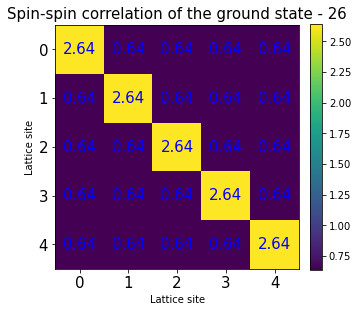

Eigenstate number:  27 ; Energy:  96.0
Spin-spin correlation values:
     Spin-spin  0-0  2.95974
     Spin-spin  0-1  0.95974
     Spin-spin  0-2  0.95974
     Spin-spin  0-3  0.95974
     Spin-spin  0-4  0.95974
     Spin-spin  1-0  0.95974
     Spin-spin  1-1  2.95974
     Spin-spin  1-2  0.95974
     Spin-spin  1-3  0.95974
     Spin-spin  1-4  0.95974
     Spin-spin  2-0  0.95974
     Spin-spin  2-1  0.95974
     Spin-spin  2-2  2.95974
     Spin-spin  2-3  0.95974
     Spin-spin  2-4  0.95974
     Spin-spin  3-0  0.95974
     Spin-spin  3-1  0.95974
     Spin-spin  3-2  0.95974
     Spin-spin  3-3  2.95974
     Spin-spin  3-4  0.95974
     Spin-spin  4-0  0.95974
     Spin-spin  4-1  0.95974
     Spin-spin  4-2  0.95974
     Spin-spin  4-3  0.95974
     Spin-spin  4-4  2.95974


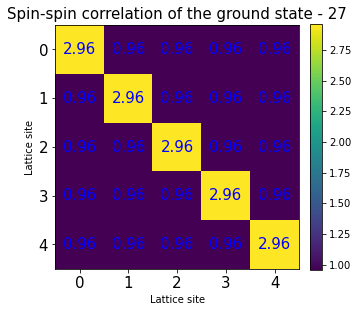

Eigenstate number:  28 ; Energy:  96.0
Spin-spin correlation values:
     Spin-spin  0-0  2.0
     Spin-spin  0-1  0.0
     Spin-spin  0-2  0.0
     Spin-spin  0-3  0.0
     Spin-spin  0-4  0.0
     Spin-spin  1-0  0.0
     Spin-spin  1-1  2.0
     Spin-spin  1-2  0.0
     Spin-spin  1-3  0.0
     Spin-spin  1-4  0.0
     Spin-spin  2-0  0.0
     Spin-spin  2-1  0.0
     Spin-spin  2-2  2.0
     Spin-spin  2-3  0.0
     Spin-spin  2-4  0.0
     Spin-spin  3-0  0.0
     Spin-spin  3-1  0.0
     Spin-spin  3-2  0.0
     Spin-spin  3-3  2.0
     Spin-spin  3-4  0.0
     Spin-spin  4-0  0.0
     Spin-spin  4-1  0.0
     Spin-spin  4-2  0.0
     Spin-spin  4-3  0.0
     Spin-spin  4-4  2.0


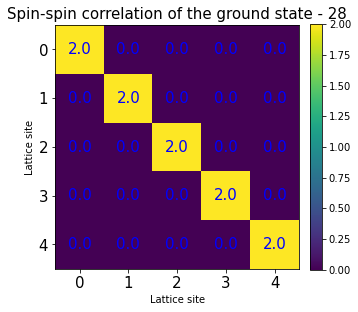

Eigenstate number:  29 ; Energy:  96.0
Spin-spin correlation values:
     Spin-spin  0-0  2.0
     Spin-spin  0-1  0.0
     Spin-spin  0-2  0.0
     Spin-spin  0-3  0.0
     Spin-spin  0-4  0.0
     Spin-spin  1-0  0.0
     Spin-spin  1-1  2.0
     Spin-spin  1-2  0.0
     Spin-spin  1-3  0.0
     Spin-spin  1-4  0.0
     Spin-spin  2-0  0.0
     Spin-spin  2-1  0.0
     Spin-spin  2-2  2.0
     Spin-spin  2-3  0.0
     Spin-spin  2-4  0.0
     Spin-spin  3-0  0.0
     Spin-spin  3-1  0.0
     Spin-spin  3-2  0.0
     Spin-spin  3-3  2.0
     Spin-spin  3-4  0.0
     Spin-spin  4-0  0.0
     Spin-spin  4-1  0.0
     Spin-spin  4-2  0.0
     Spin-spin  4-3  0.0
     Spin-spin  4-4  2.0


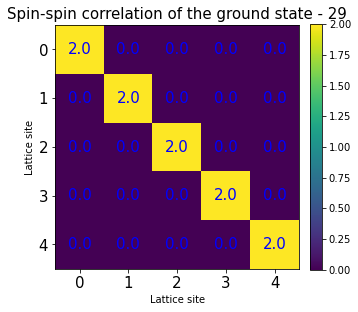

Eigenstate number:  30 ; Energy:  96.0
Spin-spin correlation values:
     Spin-spin  0-0  2.954565
     Spin-spin  0-1  0.954565
     Spin-spin  0-2  0.954565
     Spin-spin  0-3  0.954565
     Spin-spin  0-4  0.954565
     Spin-spin  1-0  0.954565
     Spin-spin  1-1  2.954565
     Spin-spin  1-2  0.954565
     Spin-spin  1-3  0.954565
     Spin-spin  1-4  0.954565
     Spin-spin  2-0  0.954565
     Spin-spin  2-1  0.954565
     Spin-spin  2-2  2.954565
     Spin-spin  2-3  0.954565
     Spin-spin  2-4  0.954565
     Spin-spin  3-0  0.954565
     Spin-spin  3-1  0.954565
     Spin-spin  3-2  0.954565
     Spin-spin  3-3  2.954565
     Spin-spin  3-4  0.954565
     Spin-spin  4-0  0.954565
     Spin-spin  4-1  0.954565
     Spin-spin  4-2  0.954565
     Spin-spin  4-3  0.954565
     Spin-spin  4-4  2.954565


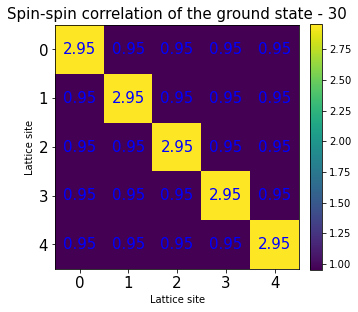

Eigenstate number:  31 ; Energy:  96.0
Spin-spin correlation values:
     Spin-spin  0-0  2.642453
     Spin-spin  0-1  0.642453
     Spin-spin  0-2  0.642453
     Spin-spin  0-3  0.642453
     Spin-spin  0-4  0.642453
     Spin-spin  1-0  0.642453
     Spin-spin  1-1  2.642453
     Spin-spin  1-2  0.642453
     Spin-spin  1-3  0.642453
     Spin-spin  1-4  0.642453
     Spin-spin  2-0  0.642453
     Spin-spin  2-1  0.642453
     Spin-spin  2-2  2.642453
     Spin-spin  2-3  0.642453
     Spin-spin  2-4  0.642453
     Spin-spin  3-0  0.642453
     Spin-spin  3-1  0.642453
     Spin-spin  3-2  0.642453
     Spin-spin  3-3  2.642453
     Spin-spin  3-4  0.642453
     Spin-spin  4-0  0.642453
     Spin-spin  4-1  0.642453
     Spin-spin  4-2  0.642453
     Spin-spin  4-3  0.642453
     Spin-spin  4-4  2.642453


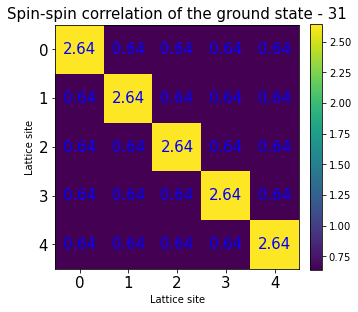

In [227]:
for i,(ei,ai,a2i) in enumerate(zip(num_result[0],num_result[2],num_result2[2])):
        print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
        print("Spin-spin correlation values:")
        
        ss=[0]*(nqubit*nqubit)
        s=[0]*(nqubit*nqubit)
        M=np.zeros((nqubit,nqubit))
        
        n=0
        p=0
        for j in range(nqubit):
            for k in range(nqubit):
                sj=0
                sk=0
                for l in range(3):
                    ss[p] += a2i[n][0]
                    sj+=ai[3*j+l][0]**2
                    sk+=ai[3*k+l][0]**2
                    n += 1
                
                s[p]=pow(sj,0.5)*pow(sk,0.5)
                M[j,k]=ss[p]-s[p]
                print("     Spin-spin ",str(j)+"-"+str(k)+" ",round(ss[p]-s[p],6))
                p+=1

        #Here we create a visual representation of the spin-spin correlation values
        fig, ax = plt.subplots(figsize=(5,10))
        im = ax.imshow(M)
        
        ax.set_xticks(np.arange(nqubit))
        ax.set_yticks(np.arange(nqubit))
        ax.set_xticklabels(np.arange(nqubit), fontsize=15)
        ax.set_yticklabels(np.arange(nqubit), fontsize=15)

        ax.set_xlabel("Lattice site")
        ax.set_ylabel("Lattice site")
        
        fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04)

        for ii in range(nqubit):
            for jj in range(nqubit):
                text = ax.text(jj, ii, round(M[ii, jj],2),
                               ha="center", va="center", color="b", fontsize=15)

        ax.set_title("Spin-spin correlation of the ground state - "+str(i), fontsize=15)
        fig.tight_layout()
        plt.show()

## Eigenstates of $H$ corresponding to eigenvalue $1$ of $\Pi_{0,0}$

We are looking for eigenstates of $H$ which are symmetrical to the horizontal and vertical axis of the "bow-tie" lattice, namely simultaneous eigenstates of $H$ and $\Pi_{0,0}$ with eigenvalue $1$ of $\Pi_{0,0}$.

### Diagonalization with projection

We already know that $[H,\Pi_{a,b}]=0$, therefore they share a set of common eigenstates. If we consider the set of eigenstates  of $H$, $\{|\psi_i\rangle\}_{i=0}^{31}$, also $\{\Pi_{a,b}|\psi_i\rangle\}_{i=0}^{31}$ are eigenstates of $H$ with the same eigenvalue. 

However, we want to look at the eigenstates of $H$ which correspond to the eigenspace of $\Pi_{a,b}$ with eigenvalue equal to $1$, $S_1$. If we call $V$ the vector space in which $\Pi_{a,b}$ works, we can say that: $V=S_1 \oplus S_1^\perp = S_1 \oplus S_0$. In other words we want to project the states $\{|\psi_i\rangle\}_{i=0}^{31}$ on the subspace $S_1$.

We have the eigenstates of $\Pi_{a,b}$ corresponding to the subspace $S_1$, $\{|\chi_i^{(1)}\}_{i=0}^{13}$ ($dim S_1=14$), therefore the projected vectors $\{|\xi_i\rangle\}_{i=0}^{31}$ can be defined as:

$$|\xi_i\rangle = \sum_{j=0}^{13}\langle \chi_j^{(1)}|\psi_i \rangle |\chi_j^{(1)} \rangle$$

We are sure they are eigenvectors of $\Pi_{a,b}$ with eigenvalue $1$, but we have to look for those which are eigenvectors of $H$. 

We look for the eigenstates of $H$, $\{|\psi_i\rangle\}_{i=0}^{31}$.

In [228]:
H_result = NumPyEigensolver(operator=H,k=2**H.num_qubits).run()

In [229]:
#We remind that H_result[1] gives the eigenvectors
H_eigv=[]
for i in range(len(H_result['eigenvalues'])):
    print("Energy: ",np.round(abs(H_result['eigenvalues'][i]),15))
    psi_i = H_result['eigenstates'][i].primitive.to_dict()
    for k in psi_i.keys():
        print("     ",k,psi_i[k])
    #By the following way we print the eigenvector corresponding to the eigenstate
    H_eigv.append(H_result['eigenstates'][i].primitive.data)

Energy:  6.000000000000009
      00001 (6.736417602666151e-18-0j)
      00010 (5.270583383895385e-17-0j)
      00011 (-1.0178581006680763e-16+0j)
      00100 (1.041473234341202e-16-0j)
      00101 (0.028535423211468403-0j)
      00110 (-0.02853542321146822+0j)
      00111 (1.7640449720400394e-17-0j)
      01000 (-1.5855383496390124e-16+0j)
      01001 (0.1963297118867725-0j)
      01010 (-0.5557035440814843+0j)
      01011 (-0.012322357323604512+0j)
      01100 (0.35937383219471175-0j)
      01101 (-0.00038392700544724834+0j)
      01110 (0.012706284329052077-0j)
      01111 (1.2995670527167851e-17-0j)
      10000 (9.117141207718854e-17-0j)
      10001 (-0.22486513509824124+0j)
      10010 (0.5842389672929523+0j)
      10011 (0.012322357323604772-0j)
      10100 (-0.3593738321947113+0j)
      10101 (-0.010586603752447328+0j)
      10110 (-0.001735753571157322+0j)
      10111 (-1.2945312253432305e-17+0j)
      11000 (-8.488942531886718e-17+0j)
      11001 (0.010970530757894682-0j)
     

      11101 (-0.028402934961631016+0j)
      11110 (0.028402934961631064-0j)
Energy:  1.999999999999997
      00001 (-3.4793898323040616e-17+0j)
      00010 (-1.3857659239404952e-16+0j)
      00011 (-0.05176560553076067+0j)
      00100 (1.5626373808653834e-16-0j)
      00101 (1.6995804305171829e-16-0j)
      00110 (7.841070169342725e-17-0j)
      00111 (0.5750249172143472+0j)
      01000 (1.2139269866129443e-16-0j)
      01001 (0.025882802765380537-0j)
      01010 (0.025882802765380467-0j)
      01011 (4.2913332864810305e-17-0j)
      01100 (-1.9390154850580154e-17+0j)
      01101 (-0.28751245860717356+0j)
      01110 (-0.2875124586071739+0j)
      01111 (-5.809773935143592e-17+0j)
      10000 (2.182856851307517e-16-0j)
      10001 (0.025882802765380644-0j)
      10010 (0.02588280276538054-0j)
      10011 (-1.2374240112388998e-17+0j)
      10100 (3.163576090970718e-18-0j)
      10101 (-0.2875124586071739+0j)
      10110 (-0.287512458607174+0j)
      10111 (5.741656088928033e-17-0j)
   

In [230]:
H_energies=H_result['eigenvalues']
for i in range(len(H_eigv)):
    print("Eigenvector with energy: ",H_energies[i])
    print(H_eigv[i])

Eigenvector with energy:  (-6.000000000000009+0j)
[-0.00000000e+00+0.j  6.73641760e-18-0.j  5.27058338e-17-0.j
 -1.01785810e-16+0.j  1.04147323e-16-0.j  2.85354232e-02-0.j
 -2.85354232e-02+0.j  1.76404497e-17-0.j -1.58553835e-16+0.j
  1.96329712e-01-0.j -5.55703544e-01+0.j -1.23223573e-02+0.j
  3.59373832e-01-0.j -3.83927005e-04+0.j  1.27062843e-02-0.j
  1.29956705e-17-0.j  9.11714121e-17-0.j -2.24865135e-01+0.j
  5.84238967e-01+0.j  1.23223573e-02-0.j -3.59373832e-01+0.j
 -1.05866038e-02+0.j -1.73575357e-03+0.j -1.29453123e-17+0.j
 -8.48894253e-17+0.j  1.09705308e-02-0.j -1.09705308e-02+0.j
 -2.16938993e-20+0.j -7.10135569e-18+0.j  3.79664879e-17-0.j
 -3.79664879e-17+0.j -0.00000000e+00+0.j]
Eigenvector with energy:  (-6+0j)
[ 0.00000000e+00+0.j  7.92471334e-17+0.j -1.23271574e-16+0.j
 -5.40606098e-17+0.j -5.47156179e-17+0.j -3.35605085e-01+0.j
  3.35605085e-01+0.j  1.93538276e-16+0.j  1.45280939e-16+0.j
 -2.68303432e-01+0.j -5.71414641e-02+0.j -1.08669768e-01+0.j
  3.25444896e-01+0.j

Now we project these vectors on the subspace $S_1$.

In [231]:
proj_v=[]
for psi in H_eigv:
    vec=np.zeros(2**nqubit,dtype='complex128')
    for chi in P_eigv:
        vec=np.add(vec,np.dot(np.dot(np.conjugate(chi),psi),chi))
    proj_v.append(vec)
#print(proj_v)

#Here we approximate the vector components to the 4th decimal digit
for i in range(len(proj_v)):
    for j in range(2**nqubit):
        proj_v[i][j]=round(proj_v[i][j],4)
print("Number of projected vectors: ",len(proj_v))
print(proj_v)

Number of projected vectors:  32
[array([ 0.    +0.j,  0.    -0.j,  0.    +0.j, -0.    -0.j,  0.    +0.j,
        0.    +0.j,  0.    -0.j,  0.    +0.j, -0.    +0.j,  0.3634+0.j,
       -0.2956+0.j,  0.0078+0.j,  0.    -0.j,  0.0155-0.j, -0.0222+0.j,
        0.    +0.j,  0.    +0.j, -0.2956+0.j,  0.3634+0.j,  0.0078+0.j,
        0.    +0.j, -0.0222+0.j,  0.0155-0.j, -0.    +0.j, -0.    -0.j,
        0.0078+0.j,  0.0078+0.j, -0.    +0.j,  0.    +0.j,  0.    +0.j,
       -0.    +0.j,  0.    +0.j]), array([ 0.    +0.j, -0.    +0.j,  0.    -0.j, -0.    +0.j, -0.    +0.j,
        0.    +0.j,  0.    +0.j,  0.    +0.j,  0.    -0.j, -0.2557+0.j,
        0.203 +0.j, -0.0132-0.j,  0.    +0.j,  0.0059+0.j, -0.0074-0.j,
        0.    -0.j,  0.    -0.j,  0.203 +0.j, -0.2557+0.j, -0.0132-0.j,
        0.    +0.j, -0.0074-0.j,  0.0059+0.j,  0.    -0.j, -0.    +0.j,
       -0.0132-0.j, -0.0132-0.j,  0.    +0.j,  0.    +0.j, -0.    -0.j,
        0.    -0.j,  0.    +0.j]), array([ 0.    +0.j, -0.    +0.j,

We want to keep only the linear indipendent vectors between the projected ones.

In [232]:
import sympy

_, inds = sympy.Matrix(proj_v).T.rref()
print("Indices of linear indipendent vectors (",len(inds),") :",inds)
li_proj_v=[]
for ind in inds:
    li_proj_v.append(proj_v[ind])
#print(li_proj_v)

Indices of linear indipendent vectors ( 14 ) : (0, 1, 2, 3, 4, 6, 7, 8, 9, 20, 21, 26, 27, 28)


Are these linear indipendent projected vectors eigenstates of $H$?

In [233]:
sim_v=[]
for i in range(len(li_proj_v)):
    for en in H_energies:
        if np.all(round(np.dot(np.dot(np.conjugate(li_proj_v[i]),mat_H),li_proj_v[i]),0)==round(en,0)):
            print("Eigenstate number: ",i," Energy: ",en)
            print(li_proj_v[i])
            sim_v.append(li_proj_v[i])
            break
print(len(sim_v))

Eigenstate number:  2  Energy:  (-7.382618686729141e-16+0j)
[ 0.    +0.j -0.    +0.j -0.    -0.j  0.    +0.j -0.    +0.j  0.    +0.j
  0.    +0.j -0.    +0.j -0.    -0.j -0.0662+0.j  0.0305+0.j -0.0374-0.j
  0.    +0.j  0.0754+0.j -0.1029-0.j -0.    -0.j  0.    -0.j  0.0305+0.j
 -0.0662+0.j -0.0374-0.j  0.    +0.j -0.1029-0.j  0.0754+0.j  0.    -0.j
  0.    +0.j -0.0374-0.j -0.0374-0.j  0.    +0.j -0.    +0.j -0.    -0.j
  0.    -0.j  0.    +0.j]
Eigenstate number:  4  Energy:  (-7.382618686729141e-16+0j)
[ 0.    +0.j -0.    +0.j -0.    -0.j  0.    +0.j -0.    +0.j  0.    +0.j
  0.    +0.j  0.    +0.j  0.    -0.j -0.0237+0.j  0.0202+0.j  0.001 -0.j
  0.    +0.j -0.0042+0.j  0.0059-0.j  0.    -0.j -0.    -0.j  0.0202+0.j
 -0.0237+0.j  0.001 -0.j  0.    +0.j  0.0059-0.j -0.0042+0.j  0.    -0.j
  0.    +0.j  0.001 -0.j  0.001 -0.j  0.    +0.j  0.    +0.j  0.    -0.j
  0.    -0.j  0.    +0.j]
Eigenstate number:  9  Energy:  (1.9999999999999973+0j)
[ 0.000e+00+0.j  2.250e-02+0.j  2.250e-02-

- We create the projection operators relative to horizontal and vertical axis, respectively.

$$\Pi_v(a)=\frac{1+(-1)^aR_v}{2}, \quad \Pi_h(b)=\frac{1+(-1)^bR_h}{2} \rightarrow \Pi_{a,b}=\Pi_v(a)\Pi_h(b)$$

In [514]:
a=1
b=1

Pv=np.add(Id,np.dot((-1)**a,Rv))
Pv=np.dot(1/2,Pv)
print("Projection operator of Rv")
print(Pv)

Ph=np.add(Id,np.dot((-1)**b,Rh))
Ph=np.dot(1/2,Ph)
print("Projection operator of Rh")
print(Ph)

Projection operator of Rv
[[0. +0.j 0. +0.j 0. +0.j ... 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0. +0.j ... 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0.5+0.j ... 0. +0.j 0. +0.j 0. +0.j]
 ...
 [0. +0.j 0. +0.j 0. +0.j ... 0.5+0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j ... 0. +0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j ... 0. +0.j 0. +0.j 0. +0.j]]
Projection operator of Rh
[[ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j ...  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j  0.5+0.j ...  0. +0.j  0. +0.j  0. +0.j]
 ...
 [ 0. +0.j  0. +0.j  0. +0.j ...  0.5+0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j ... -0.5+0.j  0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j ...  0. +0.j  0. +0.j  0. +0.j]]


#### $\Pi_v^\dagger=\Pi_v$ , $\Pi_h^\dagger=\Pi_h$

In [515]:
if  np.all(np.transpose(np.conjugate(Pv))==Pv):
    print("Pv is equal to its adjoint!")
if  np.all(np.transpose(np.conjugate(Ph))==Ph):
    print("Ph is equal to its adjoint!")

Pv is equal to its adjoint!
Ph is equal to its adjoint!


- We observe that VQE algorithm doesn't support the use of $\textbf{ComposedOp}$ class as operator argument. By the way we can see above the comments on how to create a $\textbf{SummedOp}$ element of $\textbf{CircuitOp}$ operators when dealing with operators $\Pi_{a,b}^{(i)}$. If we use use those classes, we can create the main operator and the auxiliary operator to use as arguments inside the VQE function with the following commands. 

In [452]:
#op=P@H@P
#aux_op=P@P
#print(op)

- We show a method to evaluate exactly the expected value on an operator (identity in this example). We use the $\textbf{CircuitStateFn}$ class and the NumPy operations (look at the lines with arrows).

In [453]:
#Here we set the eigenvalues of our symmetry operators, (-1)^a for R_v and (-1)^b for R_h
a=0
b=0

#psi_1   = Zero(H.num_qubits)                            # tensor product of zeros: |0)|0)|0)|0)|0)
psi=[]
psi_vec=[]

for i in range(4):
    c_T = QuantumCircuit(QuantumRegister(H.num_qubits,'q') )
    if i==1:
        if a==1:
            c_T.u(2*np.pi,0,0,0)
        c_T.swap(1,4)
        c_T.swap(0,3)   
    if i==2:
        if b==1:
            c_T.u(2*np.pi,0,0,0)
        c_T.swap(3,4)
        c_T.swap(0,1)
    if i==3:
        if (a+b)==1:
            c_T.u(2*np.pi,0,0,0)
        c_T.swap(3,4)
        c_T.swap(0,1)
        c_T.swap(1,4)
        c_T.swap(0,3)
    psi_vec.append(CircuitStateFn(c_T))       #<---------
    psi.append(Custom(H.num_qubits,state='zero',circuit=c_T)) # Here I custom the circuit
    display(Markdown(r"Initial state $\Pi_{a,b}^{(i)}|0\rangle^{\otimes 5}$ with i="+str(i)))
    print(psi[i].construct_circuit().draw())
print(psi_vec)

Initial state $\Pi_{a,b}^{(i)}|0\rangle^{\otimes 5}$ with i=0

     
q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     
q_4: 
     


Initial state $\Pi_{a,b}^{(i)}|0\rangle^{\otimes 5}$ with i=1

               ┌───┐               
q_0: ──■───────┤ X ├───────■───────
       │       └─┬─┘┌───┐  │       
q_1: ──┼────■────┼──┤ X ├──┼────■──
       │    │    │  └─┬─┘  │    │  
q_2: ──┼────┼────┼────┼────┼────┼──
     ┌─┴─┐  │    │    │  ┌─┴─┐  │  
q_3: ┤ X ├──┼────■────┼──┤ X ├──┼──
     └───┘┌─┴─┐       │  └───┘┌─┴─┐
q_4: ─────┤ X ├───────■───────┤ X ├
          └───┘               └───┘


Initial state $\Pi_{a,b}^{(i)}|0\rangle^{\otimes 5}$ with i=2

          ┌───┐     
q_0: ──■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├
     └───┘     └───┘
q_2: ───────────────
          ┌───┐     
q_3: ──■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐
q_4: ┤ X ├──■──┤ X ├
     └───┘     └───┘


Initial state $\Pi_{a,b}^{(i)}|0\rangle^{\otimes 5}$ with i=3

          ┌───┐               ┌───┐               
q_0: ──■──┤ X ├──■────■───────┤ X ├───────■───────
     ┌─┴─┐└─┬─┘┌─┴─┐  │       └─┬─┘┌───┐  │       
q_1: ┤ X ├──■──┤ X ├──┼────■────┼──┤ X ├──┼────■──
     └───┘     └───┘  │    │    │  └─┬─┘  │    │  
q_2: ─────────────────┼────┼────┼────┼────┼────┼──
          ┌───┐     ┌─┴─┐  │    │    │  ┌─┴─┐  │  
q_3: ──■──┤ X ├──■──┤ X ├──┼────■────┼──┤ X ├──┼──
     ┌─┴─┐└─┬─┘┌─┴─┐└───┘┌─┴─┐       │  └───┘┌─┴─┐
q_4: ┤ X ├──■──┤ X ├─────┤ X ├───────■───────┤ X ├
     └───┘     └───┘     └───┘               └───┘
[CircuitStateFn(<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f9732acefa0>, coeff=1.0, is_measurement=False), CircuitStateFn(<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f9732bf8880>, coeff=1.0, is_measurement=False), CircuitStateFn(<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f9733221b80>, coeff=1.0, is_measurement=False), CircuitStateFn(<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0

In [454]:
from qiskit.aqua.operators import state_fns
vqe_den=[]
Id=WeightedPauliOperator([(1.0,generate_pauli([],[],nqubit))])
Id=Id.to_opflow()
print(Id)

for i in range(4):
    vqe_den.append(psi_vec[i].adjoint().compose(Id).compose(psi_vec[i]).eval().real)   #<--------
    print('Value:', vqe_den[i])

IIIII
Value: 1.0
Value: 1.0
Value: 1.0
Value: 1.0


- We show another method to make the evaluation of expectation values (https://quantumcomputing.stackexchange.com/questions/12080/evaluating-expectation-values-of-operators-in-qiskit)

In [455]:
from qiskit.aqua.operators import CircuitStateFn,StateFn,CircuitSampler,PauliExpectation
from qiskit.aqua.operators import MatrixExpectation
v=CircuitStateFn(c_T)

# define the state to sample
measurable_expression = StateFn(num_op, is_measurement=True).compose(v) 

# convert to expectation value
expectation = PauliExpectation().convert(measurable_expression)  

# get state sampler (you can also pass the backend directly)
sampler = CircuitSampler(quantum_instance_2).convert(expectation) 

# evaluate
print(sampler.eval().real) 

#print(v.adjoint().compose(op).compose(v).eval().real)

Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.


-0.21949999999999942
